# Ucitavanje podataka

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [11]:
import os
os.getcwd()


'C:\\Users\\Lenovo T450'

In [12]:
os.chdir('C:\\Users\\Lenovo T450\\Desktop\\PO projekat')

In [13]:
os.getcwd()

'C:\\Users\\Lenovo T450\\Desktop\\PO projekat'

In [118]:
day = pd.read_csv('day.csv')



hour = pd.read_csv('hour.csv')



#procenat null vrednosti po kolonama
null_percent_col = round(100*(day.isnull().sum()/len(day)), 2).sort_values(ascending=False)
#po redovima
null_percent_rows = round((day.isnull().sum(axis=1)/len(day))*100,2).sort_values(ascending=False)
#dolazimo do zakljucka da nemamo null vrednosti



In [7]:
null_percent_col

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

# Predobrada podataka

Izbacujemo kolonu instant jer je u pitanju samo redni broj uzorka, dteday jer vec imamo informaciju o mesecu i godini pa je redudantno, casual i registered jer njihov zbir daje cnt na ciju cemo se predikciju fokusirati.

In [119]:

day.drop("instant", axis=1, inplace=True)

day.drop("dteday", axis=1, inplace=True)
day.drop("casual", axis=1, inplace=True)
day.drop("registered", axis=1, inplace=True)
hour.drop("dteday", axis=1, inplace=True)



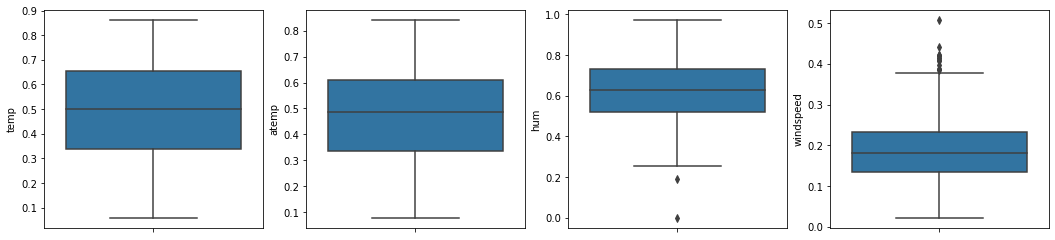

In [9]:
#crtanje boxplotova za odredjena numericka obelezja

cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=day)
    i+=1

# temp i atemp nemaju outliera, hum ih ima malo dok windspeed poseduje odredjeni broj

<Figure size 1080x2160 with 0 Axes>

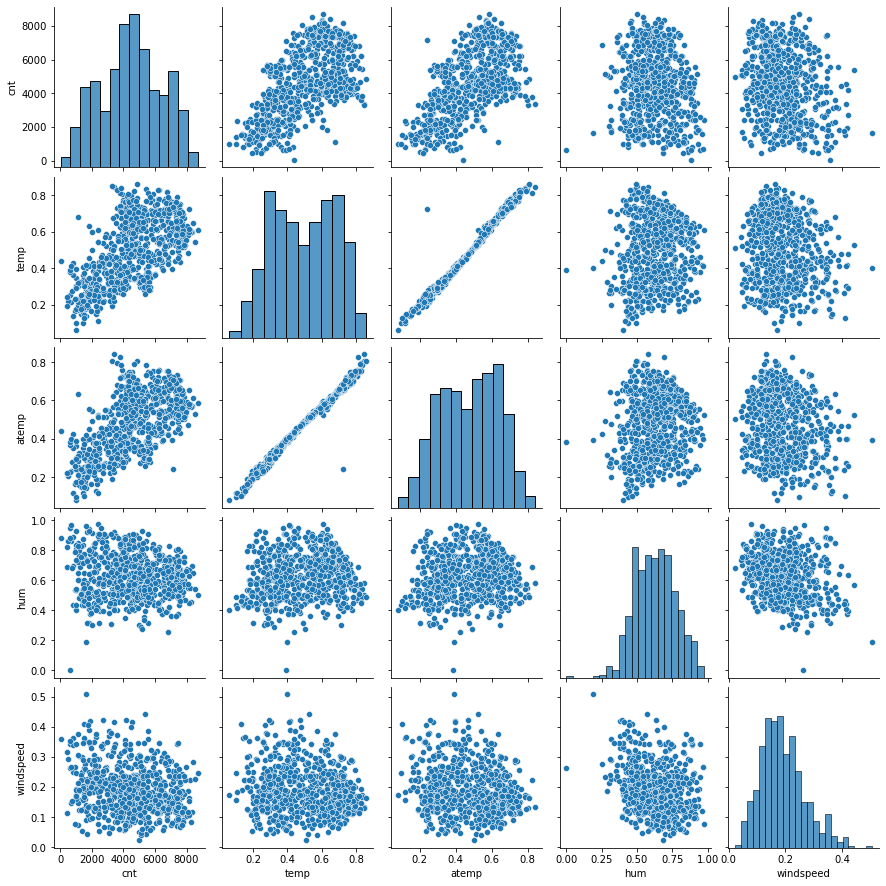

In [10]:
#veza izmedju odredjenih numerickih obelezja

plt.figure(figsize = (15,30))
sns.pairplot(data=day,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

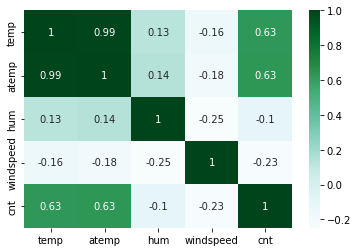

In [11]:
# heatmapa numerickih obelezja
sns.heatmap(day[['temp','atemp','hum','windspeed','cnt']].corr(), cmap='BuGn', annot = True)
plt.show()


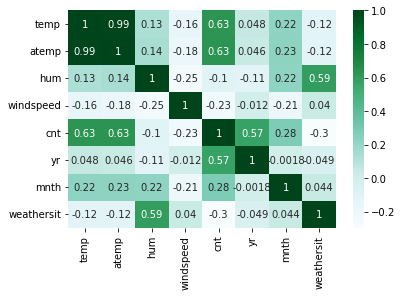

In [12]:
# heatmapa 
sns.heatmap(day[['temp','atemp','hum','windspeed','cnt','yr','mnth','weathersit']].corr(), cmap='BuGn', annot = True)
plt.show()

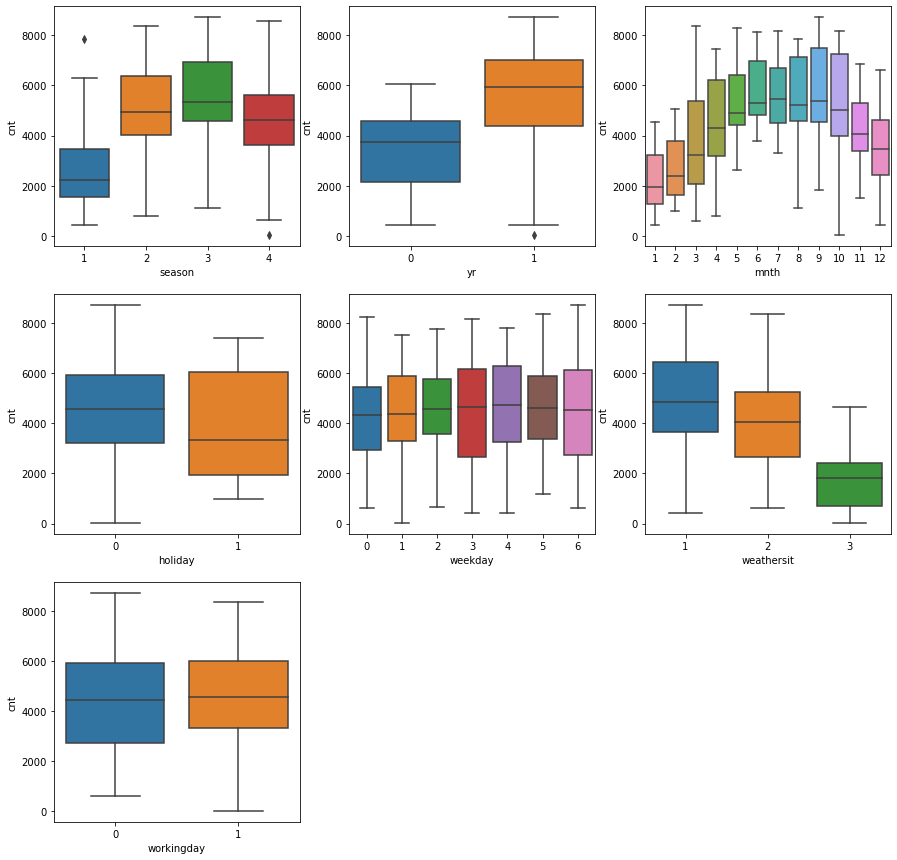

In [15]:
#boxplotovi posebno za kategoricke promenljive

vars_cat = ['season','yr','mnth','holiday','weekday','weathersit','workingday']
plt.figure(figsize=(15, 15))
for i in enumerate(vars_cat):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data=day, x=i[1], y='cnt')
plt.show()


Vidimo da je potraznja za biciklima na leto i jesen najveca, da je u 2012 veca nego u 2011 sto moze indicirati porast tokom godina, da je uglavnom nebitno koji je dan u nedelji, da li je radni dan ili vikend i da li je praznik.

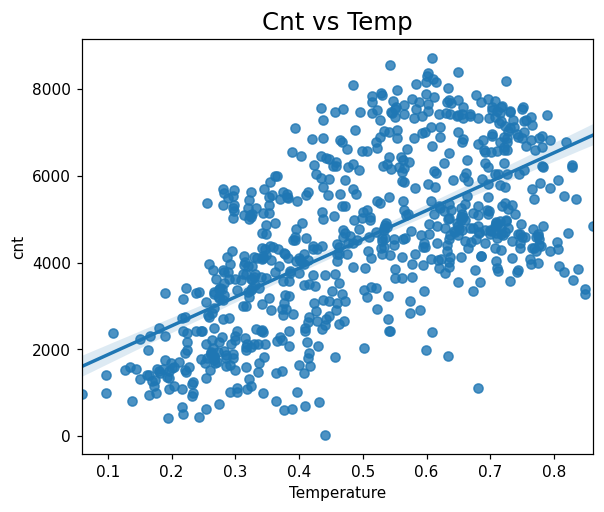

In [546]:
plt.figure(figsize=(6,5),dpi=110)
plt.title("Cnt vs Temp",fontsize=16)
sns.regplot(data=day,y="cnt",x="temp")
plt.xlabel("Temperature")
plt.show()

#uocavamo pozitivnu korelaciju broja iznajmljenih bicikala i temperature sto smo mogli videti i u mapi korelacije

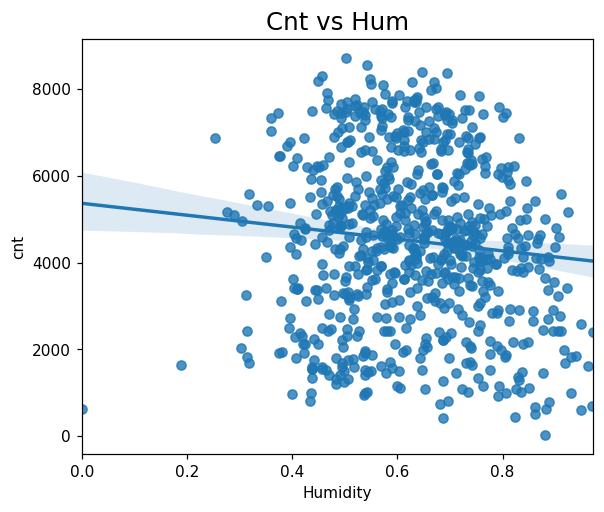

In [547]:
plt.figure(figsize=(6,5),dpi=110)
plt.title("Cnt vs Hum",fontsize=16)
sns.regplot(data=day,y="cnt",x="hum")
plt.xlabel("Humidity")
plt.show()

#uocavamo blago negativnu korelaciju izmedju vlaznosti vazduha i broja iznajmljenih bicikala

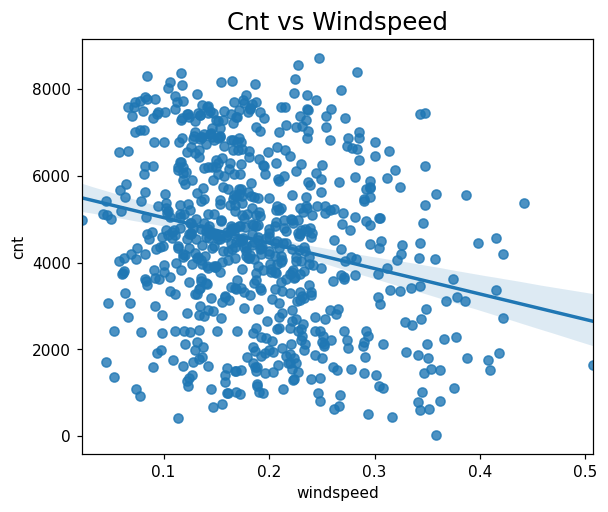

In [548]:
plt.figure(figsize=(6,5),dpi=110)
plt.title("Cnt vs Windspeed",fontsize=16)
sns.regplot(data=day,y="cnt",x="windspeed")
plt.show()
#negativna korelacija izmedju brzine vetra i broja iznajmljenih bicikala

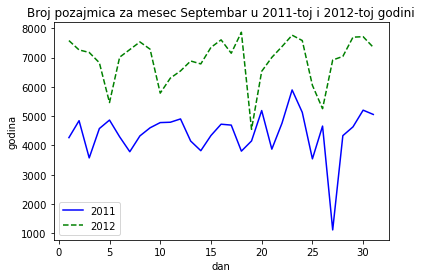

In [9]:
septembar_2011 = day.loc[(day.yr == 0) & (day.mnth == 8), :]
septembar_2012 = day.loc[(day.yr == 1) & (day.mnth == 8), :]

plt.figure()
plt.plot(np.arange(1,32), septembar_2011.cnt, "-b", label = "2011")
plt.plot(np.arange(1,32), septembar_2012.cnt, "--g",label = "2012")
plt.xlabel("dan")
plt.ylabel("godina")
plt.title("Broj pozajmica za mesec Septembar u 2011-toj i 2012-toj godini")
plt.legend(loc = "best")

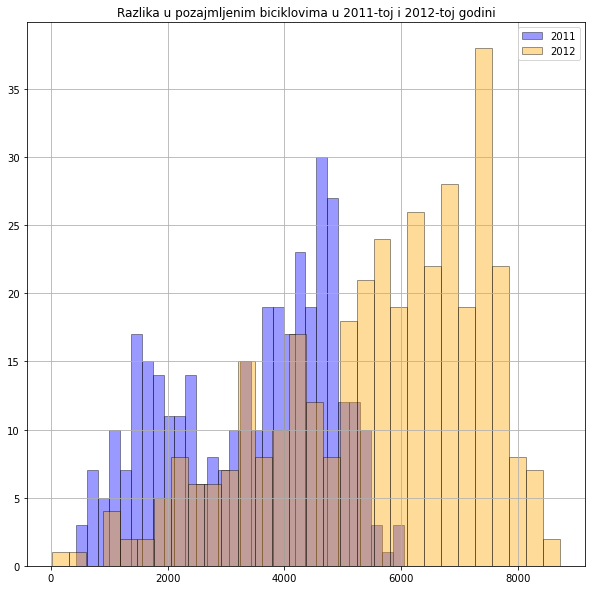

In [20]:
#Razlika u pozajmljenim biciklovima tokom ove 2 godine

df_year = day.set_index('yr')
df_year.head()

plt.figure(figsize = (10,10))
plt.hist(df_year.loc[0,"cnt"],bins = 30, color = "blue", alpha = 0.4, label = "2011",edgecolor = "black")
plt.hist(df_year.loc[1,"cnt"],bins = 30, color = "orange", alpha = 0.4, label = "2012", edgecolor = "black")
plt.grid()
plt.legend()
plt.title("Razlika u pozajmljenim biciklovima u 2011-toj i 2012-toj godini");

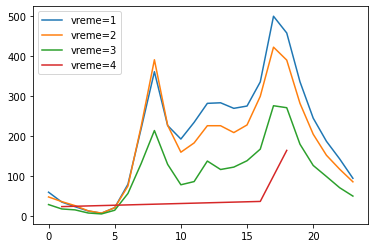

In [120]:
# Prosecno koriscenje bicikala tokom 24 sata u razlicitim vremenskim uslovima

plt.figure()  
for w in [1,2,3,4]:
    vremenski_uslovi = hour[
                      (hour.weathersit == w)].groupby("hr").agg({
                                                                  "cnt":"mean"
                                                               }) 
    plt.plot(vremenski_uslovi.cnt, label = ("vreme=" +str(w)))
plt.legend(loc = "best")

In [29]:
day['weathersit'].describe()

count    731.000000
mean       1.395349
std        0.544894
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: weathersit, dtype: float64

# Priprema podataka za regresiju

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

y=day.pop('cnt')

X=day




x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

y_test




703    6606
33     1550
300    3747
456    6041
633    7538
       ... 
718    5267
360    1162
350    2739
572    6861
31     1360
Name: cnt, Length: 110, dtype: int64

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import datasets

def model_evaluation(y_test, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(y_test, y_predicted) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-(1-r2)*(N-1)/(N-d-1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)
    
    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res=pd.concat([pd.DataFrame(y.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))

In [32]:
#standardizacija promenljivih

scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)
x_train_std = pd.DataFrame(x_train_std)
x_test_std = pd.DataFrame(x_test_std)
x_train_std.columns = list(X.columns)
x_test_std.columns = list(X.columns)
x_train_std



season        yr      mnth   holiday   weekday  workingday  weathersit  \
0    0.447101 -1.011336  0.445040 -0.162623 -0.497709    0.689246   -0.725292   
1    1.351498  0.988791  1.028098 -0.162623  0.993018    0.689246   -0.725292   
2    1.351498 -1.011336  1.028098 -0.162623 -0.994618    0.689246    1.098215   
3    0.447101  0.988791  0.736569 -0.162623  0.993018    0.689246   -0.725292   
4   -0.457296  0.988791 -1.012606 -0.162623 -0.000800    0.689246    1.098215   
..        ...       ...       ...       ...       ...         ...         ...   
616 -1.361693 -1.011336 -1.012606 -0.162623 -1.491527   -1.450862   -0.725292   
617 -0.457296 -1.011336 -0.721077 -0.162623 -1.491527   -1.450862   -0.725292   
618  1.351498 -1.011336  0.736569 -0.162623 -0.000800    0.689246    1.098215   
619 -1.361693  0.988791 -1.012606 -0.162623 -1.491527   -1.450862   -0.725292   
620 -0.457296 -1.011336 -0.721077 -0.162623 -0.000800    0.689246    1.098215   

         temp     atemp       hum  windspeed  
0    1.533369  1.536961 -0.422406  -0.508436  
1   -0.337099 -0.273461 -0.643327   0.580513  
2   -0.632677 -0.528650  0.923734  -1.387356  
3    0.558880  0.590540  0.272756  -0.468131  
4    0.184787  0.225327  1.350850  -1.306791  
..        ...       ...       ...        ...  
616 -0.631674 -0.603014 -0.726577   1.041039  
617 -0.230873 -0.194930 -1.064554   1.467587  
618  0.757471  0.610364  1.545261  -0.540753  
619 -0.756976 -0.730039 -1.083119   0.418346  
620 -0.475652 -0.371668  1.336125   0.781844  

[621 rows x 11 columns]

Mean squared error:  689887.7068315033
Mean absolute error:  587.9126218254356
Root mean squared error:  830.5947909970922
R2 score:  0.8381232628820613
R2 adjusted score:  0.8351993809308341
       y       y_pred
0    985  6208.268741
1    801  1554.540862
2   1349  3044.053309
3   1562  4323.895360
4   1600  6759.019526
5   1606  7229.989887
6   1510   753.998522
7    959  2131.112415
8    822  7134.168355
9   1321  6452.834950
10  1263  2919.883648
11  1162  2103.557957
12  1406  4048.919825
13  1421  5448.928576
14  1248  2351.032237
15  1204  2009.957031
16  1000  2342.898474
17   683  7438.463141
18  1650  5677.245356
19  1927  2958.800933


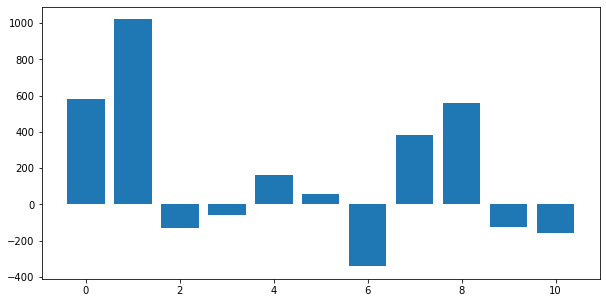

koeficijenti:  [ 580.44671247 1021.05973431 -130.09811037  -60.94634473  160.20263076
   57.44304373 -342.45875501  385.33992504  557.12797703 -125.72427197
 -157.85278478]


In [40]:


first_regression_model = LinearRegression(fit_intercept=True)

# Obuka
first_regression_model.fit(x_train_std, y_train)

# Testiranje
y_predicted = first_regression_model.predict(x_test_std)

# Evaluacija
model_evaluation(y_test, y_predicted, x_train_std.shape[0], x_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(first_regression_model.coef_)),first_regression_model.coef_)
plt.show()
print("koeficijenti: ", first_regression_model.coef_)




In [41]:
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    
    first_regression_model = LinearRegression(fit_intercept=True)
    # Obuka
    first_regression_model.fit(X_train, Y_train)

    # Testiranje
    Y_pred = first_regression_model.predict(X_test)
    
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj

print("prosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)


mse = 772548.8915061345
mae = 629.3578030207508
rmse = 878.9476045283556
r2 score = 0.7793128891659261
r2 adjusted = 0.7742972730106062



mse = 709181.3150622089
mae = 632.2703979295779
rmse = 842.1290370615473
r2 score = 0.7810815778372551
r2 adjusted = 0.776116417746966



mse = 630955.0372591041
mae = 591.8189613751351
rmse = 794.3267824133239
r2 score = 0.8389177974181582
r2 adjusted = 0.8352643866379514



mse = 657961.4875584311
mae = 639.7607460128108
rmse = 811.1482525151805
r2 score = 0.7725905854255731
r2 adjusted = 0.767432846125947



mse = 579158.0878135569
mae = 600.954718061388
rmse = 761.0243674243006
r2 score = 0.8432037376912495
r2 adjusted = 0.8396475338038345



prosek mse = 669960.9638398871
prosek mae = 618.8325252799326
prosek rmse = 817.5152087885416
prosek r2 = 0.8030213175076323
prosek r2 adjusted = 0.798551691465061


['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x7 x8', 'x7 x9', 'x7 x10', 'x8 x9', 'x8 x10', 'x9 x10']
Mean squared error:  634436.9882594143
Mean absolute error:  569.2676215618865
Root mean squared error:  796.5155292016686
R2 score:  0.8511343388940117
R2 adjusted score:  0.8333994406395077
       y       y_pred
0    985  6470.747408
1    801  1296.410020
2   1349  3256.765729
3   1562  4799.917781
4   1600  7322.775486
5   1606  7164.701061
6   1510    43.851554
7    959  3358.751852
8    822  7446.594686
9   1321  6380.

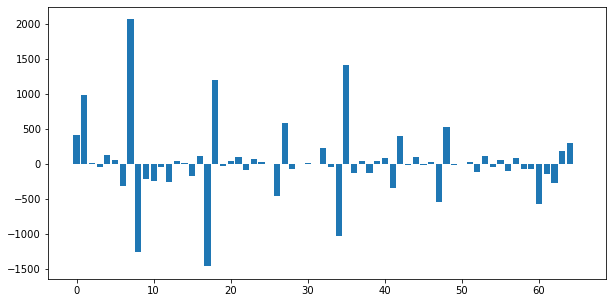

koeficijenti:  [ 4.16423347e+02  9.89078453e+02  1.69489202e+01 -3.81336884e+01
  1.32540791e+02  6.13995945e+01 -3.15468027e+02  2.06036590e+03
 -1.25032680e+03 -2.16600056e+02 -2.42161043e+02 -4.14099718e+01
 -2.52066540e+02  4.85469220e+01  9.33032825e+00 -1.77848014e+02
  1.06366566e+02 -1.46124018e+03  1.20042133e+03 -2.55564285e+01
  4.47857833e+01  9.40107557e+01 -8.01319379e+01  6.65801014e+01
  2.69606156e+01  1.67293700e+00 -4.50285164e+02  5.87528640e+02
 -6.76429976e+01  4.98651890e+00  1.71695293e+01 -2.93092093e+00
  2.26735760e+02 -5.05727004e+01 -1.02993110e+03  1.40287912e+03
 -1.26181902e+02  4.15162507e+01 -1.26141213e+02  4.53417182e+01
  8.53709135e+01 -3.42456601e+02  3.98194019e+02 -1.60363148e+01
  9.51017358e+01 -2.19737877e+01  2.51149471e+01 -5.46723627e+02
  5.30359371e+02 -1.85303048e+01 -2.02762817e+00  2.82454346e+01
 -1.19585258e+02  1.07748270e+02 -4.69146075e+01  5.97911793e+01
 -1.02579582e+02  8.53873435e+01 -7.72876267e+01 -7.80536400e+01
 -5.762790

In [34]:
#drugacija hipoteza, samo interakcije

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

print(poly.get_feature_names())

# Linearna regresija sa hipotezom y=b0+b1x1+b2x2+...+bnxn+c1x1x2+c2x1x3+...

# Inicijalizacija
regression_model_inter = LinearRegression()

# Obuka modela
regression_model_inter.fit(x_inter_train, y_train)

# Testiranje
y_predicted = regression_model_inter.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


#Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_inter.coef_)),regression_model_inter.coef_)
plt.show()
print("koeficijenti: ", regression_model_inter.coef_)




mse = 535708.34515625
mae = 519.6685
rmse = 731.9209965264353
r2 score = 0.8469690032021787
r2 adjusted score = 0.8434910260022283





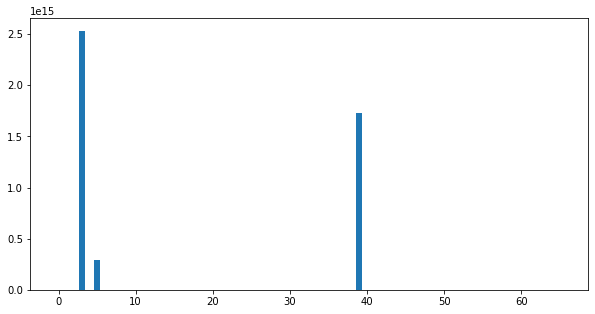

koeficijenti: 


 [ 3.39915974e+02  1.01244100e+03  1.84707784e+02  2.53092764e+15
  7.81422981e+01  2.94910626e+14 -2.70329883e+02  2.40397198e+03
 -1.68383243e+03 -2.41000000e+02 -2.64414062e+02 -1.14234375e+02
 -2.00437500e+02  3.75625000e+01  1.76250000e+01 -1.14812500e+02
  4.00000000e+01 -5.57625000e+02  2.07843750e+02  1.01875000e+01
  3.24375000e+01  2.27812500e+02  7.72656250e+01  1.59453125e+01
  4.46875000e+01  6.56250000e+00 -9.34664062e+02  9.84398438e+02
 -1.49718750e+02 -4.28437500e+01  4.46250000e+01 -4.44687500e+01
  1.74500000e+02 -6.87500000e-01 -1.31331250e+03  1.61056250e+03
 -2.79687500e+02  3.03750000e+01 -1.33312500e+02  1.73041361e+15
  1.70804688e+02  5.94875000e+02 -5.45312500e+02 -1.09968750e+02
 -4.22500000e+01 -1.61875000e+01 -6.60937500e+00 -6.16875000e+01
  7.83750000e+01 -4.94062500e+01  3.63046875e+01 -2.81250000e+01
 -5.51562500e+02  5.20312500e+02 -3.45937500e+01  7.57968750e+01
 -3.86937500e+02  3.99250000e+02 -4.42031250e+01 -7.29062500e+01
 -4.615

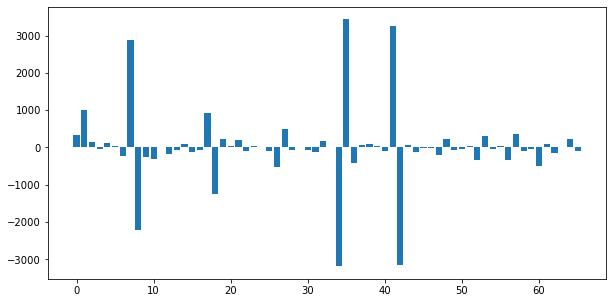

koeficijenti: 


 [  325.06245405  1015.15556675   148.53061096   -32.77253844
   119.37201941    34.37478048  -221.01935847  2888.50970171
 -2218.71706633  -265.12340032  -314.01422534    21.71972561
  -171.17411965   -76.40143167    92.85053959  -130.67761434
   -60.82632459   924.22777853 -1237.67360164   235.95706724
    42.10819631   189.17591432   -86.12678564    38.1056521
    21.97561425  -100.41670587  -516.88737453   498.5896968
   -69.92762466     7.04344742   -56.61944017  -127.52968662
   167.18848143    23.74014782 -3190.44269304  3434.27841316
  -412.75901884    72.45290703   104.24449607    41.94039792
  -101.34478716  3263.31137381 -3150.8825317     65.57774103
  -109.53654055    -5.26334283    -8.53101563  -214.45450308
   225.74646568   -57.84777317   -34.59501152    33.27403654
  -349.75069087   312.95730727   -44.75200261    49.62331371
  -347.07819793   360.41480052   -98.58372486   -45.00558178
  -485.43026774    93.36404587  -155.82430445    14.81153226
   219.4

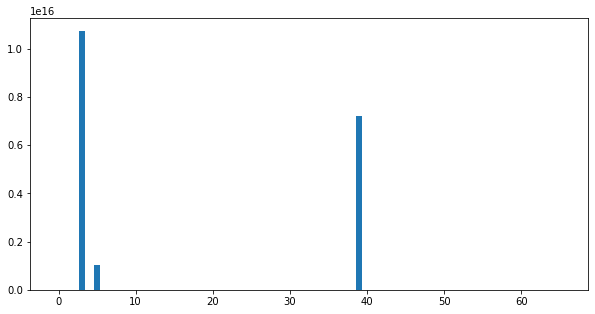

koeficijenti: 


 [ 3.51089721e+02  9.90924537e+02  1.48562620e+02  1.07424117e+16
  4.22522111e+01  1.03631100e+15 -2.80764363e+02  1.54339422e+03
 -8.24761270e+02 -2.90437500e+02 -2.54406250e+02 -3.72500000e+01
 -1.44000000e+02  5.00000000e+02 -7.71875000e+00 -9.65000000e+01
  1.86000000e+02 -3.75250000e+02 -2.09687500e+01 -2.70000000e+01
  7.25000000e+01  2.35312500e+02 -2.71765625e+02  3.24062500e+01
 -8.75000000e-01 -1.05000000e+01 -1.47262500e+03  1.48925000e+03
 -1.20000000e+02  3.96250000e+01 -4.46750000e+02 -2.44218750e+01
  1.41750000e+02 -1.53000000e+02 -2.33625000e+03  2.66975000e+03
 -2.49000000e+02  5.05000000e+01 -2.69046875e+02  7.23193621e+15
  6.54609375e+01 -3.41787500e+03  3.58312500e+03 -3.07593750e+02
  1.46750000e+02 -4.87500000e+00  6.50000000e+00 -3.09875000e+02
  3.43375000e+02 -8.43750000e+01 -1.97500000e+01 -1.80000000e+01
 -7.48750000e+02  7.43750000e+02 -4.07500000e+01  6.25000000e+01
 -2.95000000e+02  2.56750000e+02 -3.06875000e+01 -1.90937500e+01
 -4.708

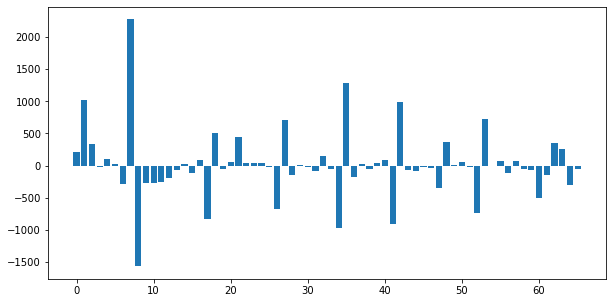

koeficijenti: 


 [  215.63001157  1022.38541001   335.80581006   -27.78230841
    96.6414088     32.27921429  -287.0845847   2277.77657328
 -1570.98233646  -269.3693774   -278.61397838  -261.01630358
  -196.98920339   -75.99481482    19.8422497   -113.7914129
    90.94210075  -826.94913415   502.42812854   -49.13750853
    58.61849781   448.24947483    35.6471661     40.26919203
    37.78651662   -28.92449174  -669.52368536   716.51697353
  -144.41520913    15.47223199   -28.74014596   -84.02583915
   143.68100127   -47.50372595  -966.67079367  1291.91349565
  -184.95177536    27.1900462    -60.85625717    34.25715047
    94.27427407  -904.72894039   985.81434747   -68.76480118
   -87.5648888    -19.39197354   -44.60827509  -349.05400569
   367.5497656     13.01349346    51.71925944   -19.67065518
  -732.78072847   719.27272283    -3.58011666    70.48302901
  -113.05844494    66.89888133   -59.2454367    -76.3705815
  -503.31020547  -145.41635259   346.35076315   258.85146293
  -296.8

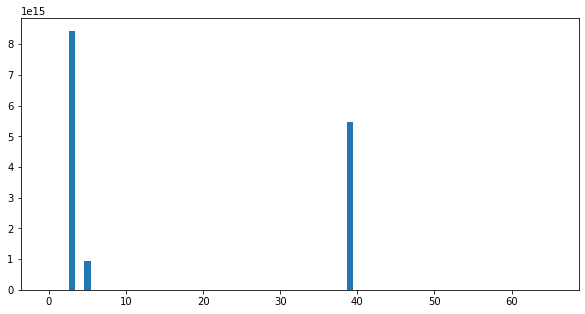

koeficijenti: 


 [ 1.91624811e+02  1.00560902e+03  2.41103668e+02  8.43437350e+15
  1.20071718e+02  9.30610453e+14 -2.38126843e+02  2.69955358e+03
 -1.97801254e+03 -2.63718750e+02 -2.94375000e+02 -1.96500000e+02
 -1.66250000e+02 -1.52500000e+02  3.82500000e+01 -8.55000000e+01
  8.22500000e+01 -1.35875000e+02 -2.26250000e+02 -4.72500000e+01
  3.50000000e+01  3.68437500e+02  1.25875000e+02  3.55625000e+01
  5.88125000e+01 -5.36250000e+01 -5.69875000e+02  6.09375000e+02
 -1.36375000e+02 -9.00000000e+00  5.22500000e+01 -4.32500000e+01
  1.30000000e+02 -9.55000000e+01 -1.94225000e+03  2.20600000e+03
 -1.89000000e+02  6.17500000e+01  1.68750000e+02  5.46609876e+15
  1.50004395e+02  1.11287500e+03 -1.02350000e+03 -4.09687500e+01
 -2.83125000e+01  2.25000000e+00  1.58750000e+01 -4.46000000e+02
  4.81500000e+02 -7.05312500e+01  1.55625000e+01 -3.71875000e+01
 -3.48000000e+02  3.37500000e+02 -3.20000000e+01  6.08750000e+01
  3.30000000e+01 -4.22500000e+01 -4.55000000e+01 -1.08750000e+02
 -4.877

In [43]:

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)

    x_inter_train.shape
    #print(poly.get_feature_names())
    
        # Inicijalizacija
    regression_model_inter = LinearRegression()

    # Obuka modela
    regression_model_inter.fit(x_inter_train, Y_train)

    # Testiranje
    Y_pred = regression_model_inter.predict(x_inter_test)
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
    print("\n\n\nmse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted score = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj
    #Ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(regression_model_inter.coef_)),regression_model_inter.coef_)
    plt.show()
    print("koeficijenti: \n\n\n", regression_model_inter.coef_)
    
print("\n\n\nprosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)
       

Mean squared error:  613125.1950284091
Mean absolute error:  563.7806818181818
Root mean squared error:  783.0231127038392
R2 score:  0.8561349839500192
R2 adjusted score:  0.8357342358177015
       y    y_pred
0    985  6549.500
1    801  1533.125
2   1349  3344.875
3   1562  4790.875
4   1600  7438.875
5   1606  7076.625
6   1510   421.750
7    959  2764.250
8    822  7038.500
9   1321  6134.000
10  1263  1574.500
11  1162  3447.250
12  1406  4558.125
13  1421  5287.875
14  1248  2347.000
15  1204  2701.000
16  1000  2599.625
17   683  7672.750
18  1650  5046.250
19  1927   320.000


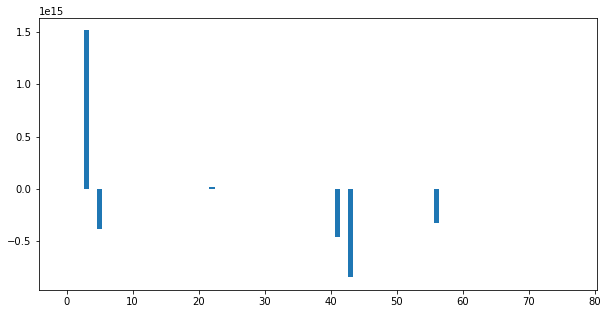

koeficijenti:  [ 3.17762745e+02  3.65680328e+11  1.20014255e+02  1.51610822e+15
  1.16596693e+02 -3.89148075e+14 -2.28417261e+02  3.11117055e+03
 -2.31000820e+03 -2.94093750e+02 -3.33750000e+02 -1.55312500e+02
  6.40693359e+01 -2.41250000e+01  4.74218750e+01  1.09765625e+00
 -1.18531250e+02 -3.64062500e+01  1.32773438e+02 -2.18976562e+02
  5.93437500e+01 -3.62812500e+01  1.62195040e+13 -8.30468750e+00
 -6.74453125e+01  7.79375000e+01  3.21337891e+01 -2.22109375e+01
 -1.05525781e+03  1.20271094e+03 -6.41250000e+01  4.17968750e+00
 -8.87500000e+01  3.07031250e+01 -2.09726562e+01  1.69492188e+02
  7.62656250e+01 -2.28168750e+03  2.49903125e+03 -1.60562500e+02
  1.30093750e+02 -4.58954252e+14 -1.08375000e+02 -8.48771875e+14
  1.06609375e+02 -3.90289062e+02  4.85324219e+02 -6.78027344e+01
  8.99238281e+01 -7.01328125e+01 -4.24687500e+01  6.66718750e+01
 -8.18320312e+02  8.23035156e+02 -5.77656250e+01 -8.89843750e+00
 -3.29717393e+14  5.08056641e+01 -1.75812500e+02  1.56453125e+02
 -7.186328

In [44]:
#hipoteza interakcije i kvadrata

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

# Linearna regresija sa hipotezom y=b0+b1x1+b2x2+...+bnxn+c1x1x2+c2x1x3+...+d1x1^2+d2x2^2+...+dnxn^2

# Inicijalizacija
regression_model_degree = LinearRegression()

# Obuka modela
regression_model_degree.fit(x_inter_train, y_train)

# Testiranje
y_predicted = regression_model_degree.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_degree.coef_)),regression_model_degree.coef_)
plt.show()
print("koeficijenti: ", regression_model_degree.coef_)



mse = 504359.839625
mae = 494.107
rmse = 710.1829620773791
r2 score = 0.855924049530923
r2 adjusted = 0.8526495961111713





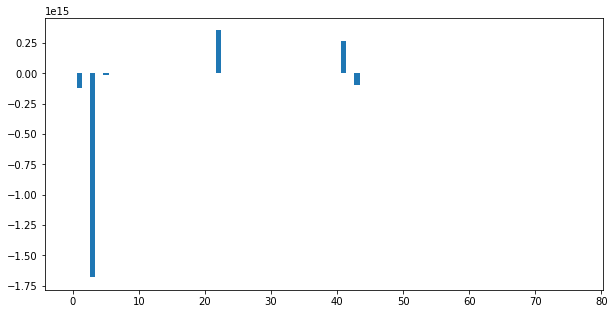

koeficijenti:

  [ 2.57731737e+02 -1.18894223e+14  2.83880599e+02 -1.68152367e+15
  6.86293603e+01 -1.21372560e+13 -2.03209759e+02  2.88628295e+03
 -2.23664997e+03 -2.97953125e+02 -3.45437500e+02 -1.16265625e+02
  8.51914062e+01  7.72500000e+01  3.74218750e+00  5.29687500e+00
 -7.13828125e+01 -1.71250000e+01  1.38600000e+03 -1.62406250e+03
  4.67500000e+01  2.65156250e+01  3.54634510e+14  4.13437500e+01
  8.67519531e+01  4.08593750e+00  4.35703125e+01 -2.74218750e+01
 -1.54364062e+03  1.59202344e+03 -1.21031250e+02 -3.99101562e+01
 -2.07453125e+02  6.88750000e+01 -4.89055176e+01  1.35007812e+02
  2.43046875e+01 -3.18603125e+03  3.37425000e+03 -2.50109375e+02
  5.25000000e+01  2.70026440e+14 -9.76875000e+01 -9.78659869e+13
  1.35765625e+02  8.17038086e+02 -7.71675781e+02 -9.46718750e+01
 -5.19062500e+01  2.78359375e+01 -3.26015625e+01 -1.84375000e+00
 -3.69968750e+02  4.01812500e+02 -6.64843750e+01  3.44609375e+01
  5.83103137e+12 -5.86718750e+00 -5.83585938e+02  5.49640625e+02
 -5.8728

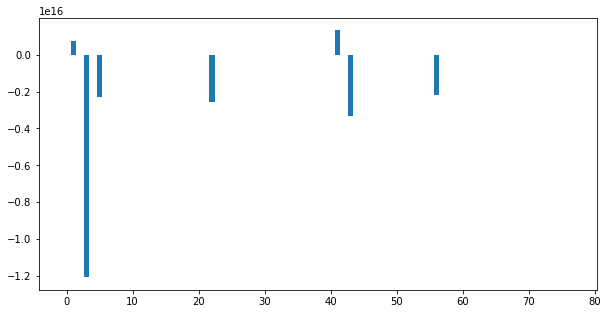

koeficijenti:

  [ 2.76399191e+02  7.61142934e+14  1.77091136e+02 -1.20797624e+16
  1.82897217e+02 -2.31026505e+15 -1.95217950e+02  3.52031724e+03
 -2.81950623e+03 -2.78250000e+02 -3.84562500e+02 -2.57671875e+02
  9.45625000e+01  4.70000000e+01 -9.18125000e+01  1.58796875e+02
 -1.84562500e+02 -1.30328125e+02  2.14700000e+03 -2.30400000e+03
  2.16625000e+02 -4.62343750e+01 -2.56291215e+15  1.71125000e+02
 -1.41250000e+01  1.53125000e+00  4.46562500e+01 -7.14687500e+01
 -1.42668750e+03  1.40868750e+03 -1.09156250e+02  1.46562500e+01
  1.02875000e+02 -3.62500000e+00 -1.89640625e+02  2.17937500e+02
  9.01250000e+01 -4.27500000e+03  4.38700000e+03 -3.80875000e+02
  1.52937500e+02  1.31686920e+15  9.56250000e+01 -3.30919487e+15
 -5.37500000e+01  3.30715625e+03 -3.23628125e+03  1.76875000e+01
 -1.83375000e+02 -3.75312500e+01  1.40625000e+01  2.23906250e+01
 -2.85781250e+02  3.14664062e+02 -1.12156250e+02 -5.05000000e+01
 -2.20756880e+15  6.53750000e+01 -2.51160156e+02  2.46843750e+02
 -8.5531

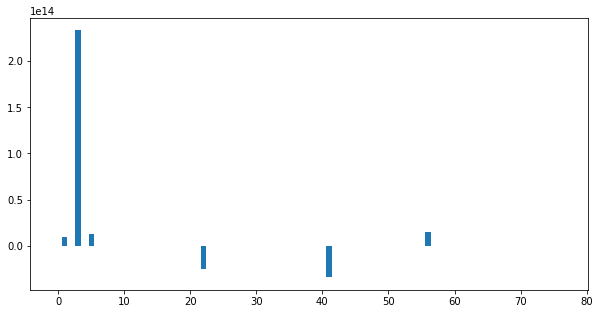

koeficijenti:

  [ 2.56955441e+02  9.27863809e+12  2.69516692e+02  2.33369219e+14
  6.48777882e+01  1.24539744e+13 -2.21353811e+02  2.46729166e+03
 -1.83691405e+03 -3.20378906e+02 -3.00483887e+02 -1.84687500e+02
  7.61621094e+01  1.17011719e+02  4.24011719e+02 -5.04853516e+01
 -7.39931641e+01  1.32826172e+02  8.39269531e+02 -1.07367188e+03
  2.45234375e+01  5.98613281e+01 -2.49094723e+13  8.15781250e+01
 -1.65237305e+02  2.88007812e+01 -2.27294922e+00 -2.79921875e+01
 -1.47784863e+03  1.52631934e+03 -1.12947510e+02  3.66259766e+01
 -1.62732422e+02 -3.76473633e+02  2.36270752e+01  1.34779297e+02
 -1.25231445e+02 -2.84611719e+03  3.03992969e+03 -2.24066406e+02
  6.78847656e+01 -3.43050487e+13 -1.50847656e+02 -7.50021842e+11
  8.64106445e+01 -2.18970825e+03  2.32660352e+03 -2.33848145e+02
  7.95410156e+01 -3.36718750e+01 -7.60742188e-01  2.34394531e+01
 -2.85200439e+02  3.25891357e+02 -1.18086914e+02 -3.59072266e+01
  1.54659665e+13  6.07128906e+00 -4.98704102e+02  4.85717773e+02
 -7.0010

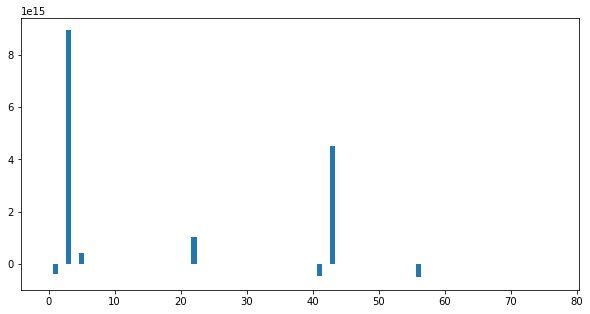

koeficijenti:

  [ 1.59881156e+02 -3.89793092e+14  4.40183280e+02  8.92658022e+15
  1.07466943e+02  4.20770610e+14 -2.71539967e+02  2.95513746e+03
 -2.31462878e+03 -2.91687500e+02 -3.35312500e+02 -1.15781250e+02
 -7.86250000e+01  3.47500000e+01 -8.76562500e+01 -1.60000000e+01
 -1.48625000e+02  7.53125000e+01  8.18250000e+02 -1.02725000e+03
 -2.01250000e+01  5.86250000e+01  1.02314664e+15  2.55250000e+02
  5.27265625e+01  6.34531250e+01  1.90625000e+01 -7.02031250e+01
 -1.59987500e+03  1.64118750e+03 -9.70000000e+01  3.91328125e+01
 -1.81406250e+02  2.06250000e+01 -3.08750000e+01  1.46859375e+02
 -8.71953125e+01 -2.12775000e+03  2.36875000e+03 -1.19500000e+02
  3.38125000e+01 -4.44563218e+14 -1.60000000e+01  4.50963322e+15
  9.69375000e+01 -6.65625000e+02  7.52703125e+02 -6.57500000e+01
 -5.10312500e+01  4.17187500e+01 -2.25625000e+01 -1.88750000e+01
 -7.13812500e+02  7.50562500e+02 -5.04062500e+01  4.36250000e+01
 -5.04662112e+14  3.38906250e+01 -6.88625000e+02  7.03468750e+02
 -3.7015

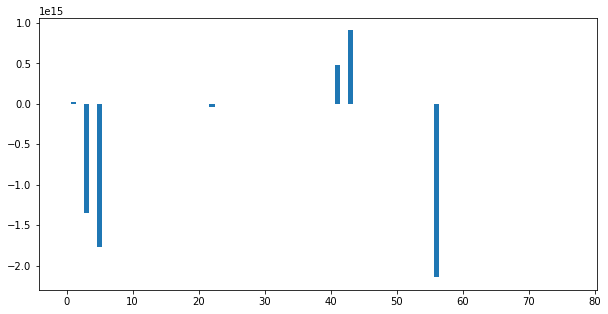

koeficijenti:

  [ 1.81468196e+02  1.69268115e+13  2.38682198e+02 -1.35277933e+15
  1.13300299e+02 -1.76677803e+15 -1.63563935e+02  3.21636864e+03
 -2.51789237e+03 -3.27367188e+02 -3.66687500e+02 -1.61906250e+02
 -1.05187500e+02  1.35937500e+01 -1.79859375e+02 -2.09257812e+01
 -1.32812500e+02  5.35156250e+00  1.35162500e+03 -1.58337500e+03
  7.09375000e+01  2.03437500e+01 -4.25301237e+13  2.79781250e+02
  1.28898438e+02  1.82187500e+01  5.08750000e+01 -9.79667969e+01
 -1.04328125e+03  1.08128125e+03 -1.29187500e+02  1.02734375e+01
 -4.23125000e+01  8.59218750e+01 -2.62500000e+00  1.71781250e+02
 -4.91484375e+01 -3.44110938e+03  3.56573438e+03 -2.37328125e+02
  1.25265625e+02  4.83021617e+14  1.89117188e+02  9.08661555e+14
  1.52125000e+02  1.20937500e+03 -1.11909375e+03 -4.67656250e+01
 -5.30937500e+01 -9.50937500e+01 -1.50000000e+01  5.79843750e+01
 -6.85687500e+02  7.47500000e+02 -1.14781250e+02 -2.33007812e+00
 -2.14700106e+15 -3.44140625e+00 -3.72812500e+02  3.68406250e+02
 -8.4312

In [45]:

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold
mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)

    #print(poly.get_feature_names())
    
        # Inicijalizacija
    regression_model_degree = LinearRegression()

    # Obuka modela
    regression_model_degree.fit(x_inter_train, Y_train)

    # Testiranje
    Y_pred = regression_model_degree.predict(x_inter_test)
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
    print("\n\nmse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj
    
    # Ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(regression_model_degree.coef_)),regression_model_degree.coef_)
    plt.show()
    print("koeficijenti:\n\n ", regression_model_degree.coef_)
    
print("\n\nprosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)

Mean squared error:  565921.4968662882
Mean absolute error:  544.0759895968437
Root mean squared error:  752.2775397858746
R2 score:  0.8672109613340465
R2 adjusted score:  0.8513913285687885
       y       y_pred
0    985  6361.125483
1    801  1145.465090
2   1349  3317.408197
3   1562  4808.394809
4   1600  7107.969308
5   1606  7059.330058
6   1510   120.562804
7    959  3498.570786
8    822  7363.276883
9   1321  6262.059308
10  1263  1827.555020
11  1162  3727.579026
12  1406  4560.503684
13  1421  5366.657995
14  1248  2448.825037
15  1204  2413.602063
16  1000  2651.987257
17   683  7602.495575
18  1650  5046.944319
19  1927   961.474610
vreme trajanja je:  0.029981136322021484  sekundi.


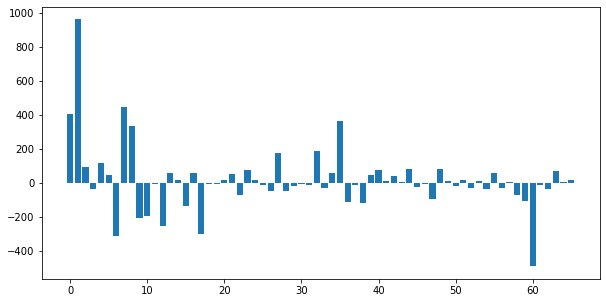

koeficijenti:  [ 406.07213869  964.21207157   94.60050658  -35.68143305  120.05208926
   48.07100812 -310.28295104  448.07757934  334.36895191 -209.25092684
 -192.53662806   -3.91579211 -252.3213642    56.92723776   14.97344488
 -136.02909474   57.83546205 -298.45208792   -3.64293766   -7.73804574
   17.26090853   50.68087904  -70.28129965   74.47407805   17.60616721
  -14.32926429  -46.84008948  178.86191354  -49.59207151  -17.00129149
   -4.33580079  -12.90679925  187.75929212  -31.62628097   56.07006248
  364.15742047 -115.12942701  -11.21963677 -121.1566782    43.95137105
   75.65365718    9.23210366   39.22447198    6.37944832   81.81721174
  -22.06150808   -4.61454657  -94.50928894   84.74488964   10.99728587
  -17.02214536   15.27570444  -30.5628707     8.92665351  -33.07712811
   59.73002877  -27.27936773    5.8363725   -70.10687688 -104.53951241
 -492.59536772  -15.1339891   -34.80106433   71.59806809    2.76777925
   18.10678144]


In [35]:
#ridge regresija
from sklearn.linear_model import RidgeCV




#ovde odredjujemo koje je alpha najbolje za ridge regresiju
regr_cv = RidgeCV(alphas=[0.1, 1.0, 5.0, 10.0 ,11.0,12.0,13.0,14.0, 15.0,16.0,17.0,18.0,19.0, 20.0,30.0,40.0])
model_cv = regr_cv.fit(x_train_std, y_train)
model_cv.alpha_

import time
start = time.time()

x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

#Inicijalizacija
ridge_model = Ridge(alpha=13)

# Obuka modela
ridge_model.fit(x_inter_train, y_train)

# Testiranje
y_predicted = ridge_model.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
plt.show()
print("koeficijenti: ", ridge_model.coef_)

Mean squared error:  624828.3333935622
Mean absolute error:  586.2233900822429
Root mean squared error:  790.4608360909237
R2 score:  0.8533889343627732
R2 adjusted score:  0.8421894779599295
       y       y_pred
0    985  6758.268625
1    801  1197.830165
2   1349  3129.174410
3   1562  4677.921241
4   1600  7298.718456
5   1606  7191.800525
6   1510   160.478377
7    959  3700.877834
8    822  7379.197667
9   1321  5933.381284
10  1263  3143.971406
11  1162  3634.033660
12  1406  4457.589580
13  1421  5342.483033
14  1248  2509.919275
15  1204  2717.949637
16  1000  2796.171439
17   683  7850.994067
18  1650  5031.958419
19  1927   550.139122
vreme trajanja je:  0.01798868179321289  sekundi.


In [49]:
pca = PCA(n_components=0.9)
pca.fit(x_train_std)
X_train_r = pca.transform(x_train_std)
X_test_r = pca.transform(x_test_std)
print('Redukovani prostor ima dimenziju: ', pca.n_components_)



Redukovani prostor ima dimenziju:  8


PCA Redukcija dimenzionalnosti doprinosi blagom smanjivanju vremena obuke ali takodje pogorsava performanse

In [50]:
import time
start = time.time()

# start = time.time()
# regressor_rf_pca = RandomForestRegressor(n_estimators=100, max_depth=5,criterion='absolute_error',max_features=None,max_leaf_nodes=50,min_samples_leaf=1,min_weight_fraction_leaf=0.1)
# regressor_rf_pca.fit(X_train_r,Y1_train)
# y_predicted_pca = regressor_rf_pca.predict(X_test_r)
# model_evaluation(Y1_test, y_predicted_pca, X1_train.shape[0], X1_train.shape[1])

#Inicijalizacija
ridge_model_pca = Ridge(alpha=15)

x_inter_train = poly.fit_transform(X_train_r)
x_inter_test = poly.transform(X_test_r)

# Obuka modela
ridge_model_pca.fit(x_inter_train, y_train)

# Testiranje
y_predicted_pca = ridge_model_pca.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted_pca, x_inter_train.shape[0], x_inter_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

Mean squared error:  624828.3333935622
Mean absolute error:  586.2233900822429
Root mean squared error:  790.4608360909237
R2 score:  0.8533889343627732
R2 adjusted score:  0.8421894779599295
       y       y_pred
0    985  6758.268625
1    801  1197.830165
2   1349  3129.174410
3   1562  4677.921241
4   1600  7298.718456
5   1606  7191.800525
6   1510   160.478377
7    959  3700.877834
8    822  7379.197667
9   1321  5933.381284
10  1263  3143.971406
11  1162  3634.033660
12  1406  4457.589580
13  1421  5342.483033
14  1248  2509.919275
15  1204  2717.949637
16  1000  2796.171439
17   683  7850.994067
18  1650  5031.958419
19  1927   550.139122
vreme trajanja je:  0.01598978042602539  sekundi.




mse = 479182.28662996134
mae = 504.5728360899446
rmse = 692.2299376868652
r2 score = 0.8631162952119885
r2 adjusted = 0.8600053019213518





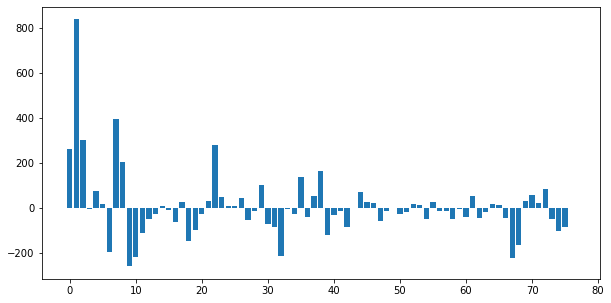

koeficijenti:

  [ 2.62968108e+02  8.38146506e+02  3.02932306e+02 -2.60674258e+00
  7.33519732e+01  1.84823122e+01 -1.97797075e+02  3.95389435e+02
  2.05250839e+02 -2.60080462e+02 -2.18187100e+02 -1.11063623e+02
 -5.11018241e+01 -2.90306843e+01  8.97209999e+00 -1.03285849e+01
 -6.16362046e+01  2.46412388e+01 -1.48870097e+02 -9.69636953e+01
 -2.54814475e+01  3.04599701e+01  2.80995715e+02  5.06295909e+01
  1.05344853e+01  9.34901364e+00  4.26935457e+01 -5.27921554e+01
 -1.28636820e+01  1.00948015e+02 -7.28127380e+01 -8.44773537e+01
 -2.12974538e+02 -3.35336495e+00 -2.64078385e+01  1.36581166e+02
 -3.90702234e+01  5.13583389e+01  1.62197183e+02 -1.21410802e+02
 -2.96888636e+01 -1.48510261e+01 -8.42997132e+01  6.62758659e-01
  6.87730981e+01  2.68764421e+01  2.21607927e+01 -5.95258374e+01
 -1.25606285e+01  1.32366198e-01 -2.66777151e+01 -1.77910092e+01
  1.89036326e+01  1.46621767e+01 -4.86635045e+01  2.61287431e+01
 -1.43960025e+01 -1.23502004e+01 -4.75902667e+01 -4.43739305e+00
 -4.2514

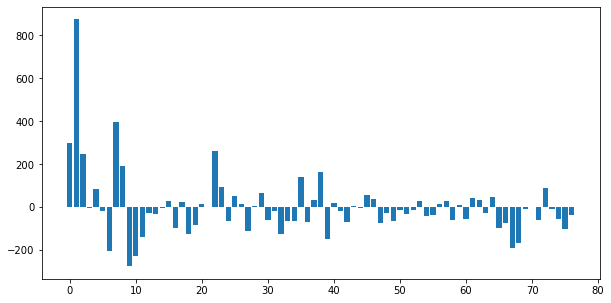

koeficijenti:

  [ 2.97101382e+02  8.75193552e+02  2.49330623e+02 -2.79214974e+00
  8.41175711e+01 -1.89640697e+01 -2.04521489e+02  3.97635997e+02
  1.91817730e+02 -2.75630778e+02 -2.27352955e+02 -1.37575393e+02
 -2.73235947e+01 -3.05998920e+01 -4.85241249e+00  2.76964575e+01
 -9.88707895e+01  2.22363053e+01 -1.25837870e+02 -8.30739933e+01
  1.34961755e+01  8.10571973e-01  2.59918151e+02  9.25546264e+01
 -6.53380985e+01  5.14651498e+01  1.48383604e+01 -1.10317756e+02
  6.26630235e+00  6.64642865e+01 -5.72118904e+01 -1.64615705e+01
 -1.26495024e+02 -6.27160868e+01 -6.27964992e+01  1.39858275e+02
 -7.08999544e+01  3.19167014e+01  1.63511460e+02 -1.49531790e+02
  1.77380686e+01 -1.53350938e+01 -6.89438980e+01  7.43531791e+00
 -2.93486357e+00  5.58137270e+01  3.82671120e+01 -7.44495021e+01
 -2.80583605e+01 -6.47316241e+01 -1.35688233e+01 -2.92333291e+01
 -1.49128402e+01  2.77932092e+01 -3.87813371e+01 -3.52573773e+01
  1.48313855e+01  3.03798093e+01 -6.06070127e+01  1.25375324e+01
 -5.3400

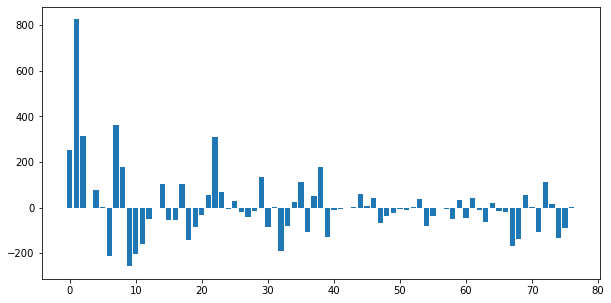

koeficijenti:

  [ 2.50375601e+02  8.25766410e+02  3.15590996e+02 -6.77302807e-01
  7.75938309e+01  2.02799832e+00 -2.13421876e+02  3.61039084e+02
  1.78994281e+02 -2.58501539e+02 -2.04854253e+02 -1.58318680e+02
 -5.11339059e+01 -3.94307814e+00  1.01920027e+02 -5.46505816e+01
 -5.56116065e+01  1.02312809e+02 -1.43711665e+02 -8.61773092e+01
 -3.30080507e+01  5.60386030e+01  3.07593335e+02  6.99496384e+01
 -4.95786861e+00  2.75580578e+01 -1.76708061e+01 -4.13605466e+01
 -1.71791894e+01  1.34741547e+02 -8.33829438e+01  4.34502949e+00
 -1.91402937e+02 -7.91537033e+01  2.44727121e+01  1.10484437e+02
 -1.06989932e+02  4.87450333e+01  1.78827380e+02 -1.30205128e+02
 -1.08953180e+01 -4.62952863e+00 -2.92511177e+00  7.15469337e-01
  5.92264637e+01  6.11590100e+00  4.02586602e+01 -6.95279680e+01
 -3.80388617e+01 -2.52734943e+01 -6.59589474e+00 -1.28329777e+01
  4.25965231e+00  3.57407314e+01 -8.03592627e+01 -3.86448245e+01
 -1.64713917e+00 -8.42990561e+00 -5.00383276e+01  3.16495024e+01
 -4.5682

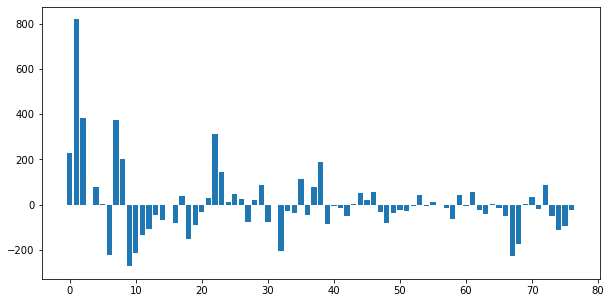

koeficijenti:

  [ 2.26791437e+02  8.18768422e+02  3.83291374e+02 -2.93247770e+00
  7.66037224e+01  1.44080267e+00 -2.22103215e+02  3.75966580e+02
  2.02341040e+02 -2.72958172e+02 -2.12395846e+02 -1.35033075e+02
 -1.06248665e+02 -4.44323031e+01 -6.87083745e+01 -1.92018500e+00
 -7.89558272e+01  3.65825744e+01 -1.50687369e+02 -8.96626567e+01
 -3.27677058e+01  2.91495031e+01  3.11930140e+02  1.44555287e+02
  1.04871533e+01  4.80389787e+01  2.60058029e+01 -7.68388403e+01
  2.12232919e+01  8.70741140e+01 -7.66319006e+01  6.11949985e-01
 -2.03977231e+02 -2.72934327e+01 -3.77896016e+01  1.15042490e+02
 -4.49846265e+01  7.89332449e+01  1.90374380e+02 -8.35506860e+01
 -4.14008059e+00 -1.61058055e+01 -5.22026692e+01  3.96278992e+00
  5.26878420e+01  1.88356034e+01  5.76810286e+01 -3.31038558e+01
 -7.97609745e+01 -3.50483025e+01 -2.54814457e+01 -2.82980596e+01
 -5.72802344e+00  4.10807056e+01 -6.13690544e+00  1.28906403e+01
 -1.06996777e+00 -1.48019215e+01 -6.52988830e+01  4.23682287e+01
 -7.6988

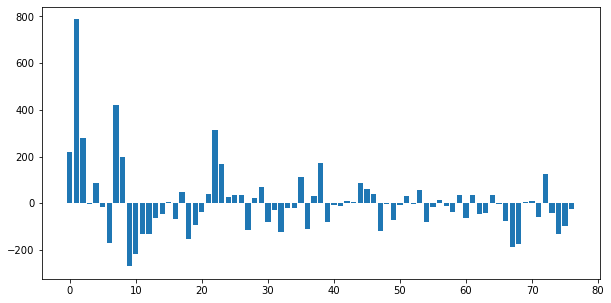

koeficijenti:

  [ 220.95739268  787.0769015   279.71316799   -1.74485094   85.70090641
  -14.34379645 -170.12838017  420.86533958  200.1120153  -270.36554026
 -216.96153577 -129.66520915 -131.50462061  -63.7043833   -45.18288235
    7.24025863  -68.74791975   48.43797115 -154.04975247  -93.38507367
  -37.93330328   40.0675527   313.25331747  167.92340971   26.51256554
   35.63184585   33.36044745 -113.67769376   24.64961608   70.68939757
  -79.42199827  -30.49824149 -124.39719096  -19.88394788  -19.60845366
  113.15614772 -109.24276861   29.10876502  170.61409922  -80.80860272
   -9.11326899   -9.95161557    9.26595507    5.13441353   88.87203243
   62.14767972   39.2115842  -120.17458208   -3.09627506  -70.12516991
   -5.82205729   31.62452561   -3.28294042   57.11254671  -80.74545653
  -17.34603729   12.83711589  -11.67788308  -38.8616892    37.33096558
  -63.56360924   33.98745324  -43.91701905  -41.65871341   37.36973287
   -1.81855158  -76.31586582 -185.91035821 -175.15542217    

In [52]:

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold


mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)

    #Inicijalizacija
    ridge_model = Ridge(alpha=13)

    # Obuka modela
    ridge_model.fit(x_inter_train, Y_train)

    # Testiranje
    Y_pred = ridge_model.predict(x_inter_test)


    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("\n\nmse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))

    print("\n\n")

    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj
    # Ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
    plt.show()
    print("koeficijenti:\n\n ", ridge_model.coef_)

print("\n\nprosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)

Raspodela gresaka na test skupu

0.8672109613340465

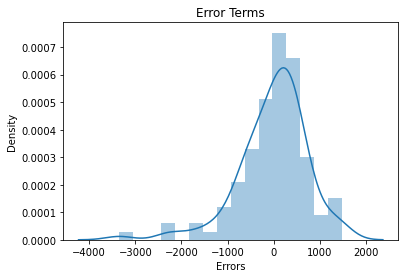

In [36]:

def plot_res_dist(act, pred):
    sns.distplot(act-pred)
    plt.title('Error Terms')
    plt.xlabel('Errors')

plot_res_dist(y_test, y_predicted)
r2_score(y_test,y_predicted)

Greske na test skupu

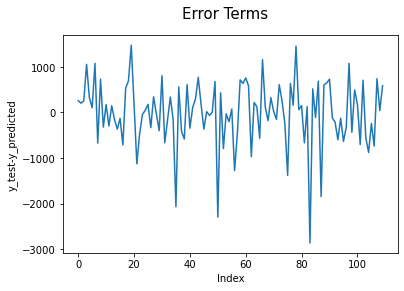

In [62]:
c = [i for i in range(0,len(x_test_std),1)]
plt.plot(c,y_test-y_predicted)
plt.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('y_test-y_predicted')
plt.show()

Text(0, 0.5, 'predvidjene vrednosti')

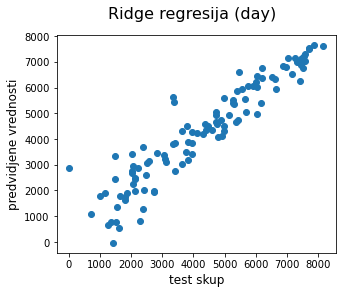

In [215]:
#test skup i predictovan test skup

fig = plt.figure(figsize=(5,4))
plt.scatter(y_test, y_predicted)
fig.suptitle('Ridge regresija (day)', fontsize = 16)              
plt.xlabel('test skup', fontsize = 12)                          
plt.ylabel('predvidjene vrednosti', fontsize = 12)

In [3]:
def plot_act_pred(act,pred,scale,dataname):
    c = [i for i in range(1,scale,1)]
    fig = plt.figure(figsize=(8,5))
    plt.plot(c,act, color="blue", linewidth=2.5, linestyle="-")
    plt.plot(c,pred, color="red",  linewidth=2.5, linestyle="-")
    fig.suptitle('Prave i predvidjene vrednosti - '+dataname, fontsize=20)               
                             
    
plot_act_pred(y_test,y_predicted,len(y_test)+1,'Test Skup')

#veliki procenat pravih i predvidjenih vrednosti se preklapa, nas model je dobro predvidjao

Mean squared error:  506612.70277599985
Mean absolute error:  520.264384001499
Root mean squared error:  711.7673094319518
R2 score:  0.8811273044934709
R2 adjusted score:  0.8642705870827845
       y       y_pred
0    985  6341.887654
1    801  1318.716950
2   1349  3496.415421
3   1562  4970.855553
4   1600  7233.520508
5   1606  7224.618403
6   1510   484.372914
7    959  2714.812108
8    822  6792.704355
9   1321  6139.545012
10  1263  1516.278501
11  1162  3523.740072
12  1406  4665.957829
13  1421  5426.765666
14  1248  2486.170358
15  1204  2551.954554
16  1000  2715.775827
17   683  7671.863266
18  1650  4644.454259
19  1927   764.070853


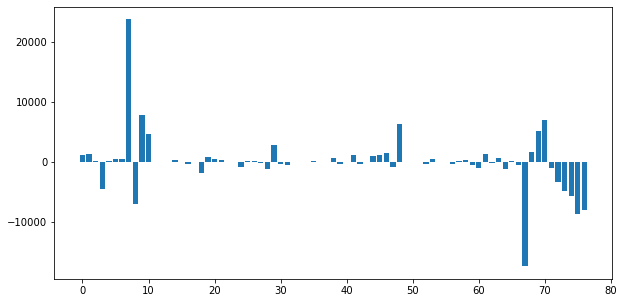

koeficijenti:  [ 1.09353762e+03  1.33891668e+03  9.80416376e+01 -4.48210389e+03
  2.07409831e+02  5.52898646e+02  4.70374144e+02  2.37402001e+04
 -7.03109061e+03  7.85278372e+03  4.70384680e+03 -5.65260650e+01
  6.38715912e+01 -3.30370678e+01  2.79518684e+02  4.31405130e+00
 -2.81183789e+02  2.10377817e+01 -1.85286513e+03  8.73360836e+02
  4.11139869e+02  3.31735323e+02  3.13761446e+01  3.18494323e+00
 -8.67186201e+02  7.37289438e+01  8.37166042e+01 -1.99784076e+02
 -1.14110920e+03  2.86868837e+03 -4.15052468e+02 -5.14418328e+02
 -1.27982589e+01  2.01672436e+01 -1.24445946e+00  1.25735199e+02
 -1.96942017e+00  4.76964132e+01  6.25241776e+02 -2.86890854e+02
 -8.36989156e+01  1.09879151e+03 -3.52068585e+02  0.00000000e+00
  9.91672576e+02  1.11728092e+03  1.54684964e+03 -8.20818349e+02
  6.25393849e+03 -1.87578761e+01 -3.50360226e+01  1.06746183e+01
 -3.88139173e+02  4.42161370e+02 -9.28763121e+01 -9.73502614e+01
 -3.39001310e+02  1.62938768e+02  3.19486877e+02 -5.75625062e+02
 -1.044952

In [67]:
#Lasso regresija
x_inter_train = poly.fit_transform(x_train)
x_inter_test = poly.transform(x_test)
# Model initialization
lasso_model = Lasso(alpha=0.01)

# Fit the data(train the model)
lasso_model.fit(x_inter_train, y_train)

# Predict
y_predicted = lasso_model.predict(x_inter_test)

# Evaluation
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


#ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
plt.show()
print("koeficijenti: ", lasso_model.coef_)

(496,)
(125,)


mse = 486290.4671026001
mae = 488.5251444406798
rmse = 697.3452997637542
r2 score = 0.8610857650681479
r2 adjusted = 0.8579286233651513





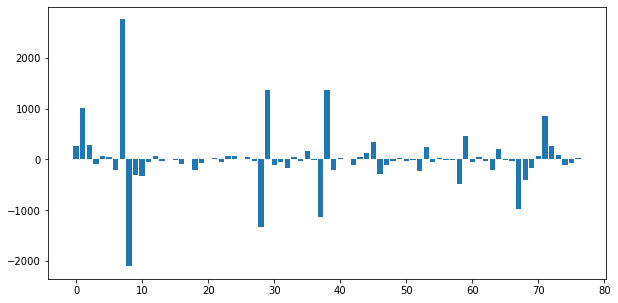

koeficijenti:

  [ 2.66958612e+02  1.01805369e+03  2.86309993e+02 -7.93546605e+01
  6.86376412e+01  5.61845219e+01 -2.06442642e+02  2.75552782e+03
 -2.10361134e+03 -2.99815877e+02 -3.32341888e+02 -4.06504093e+01
  6.12221440e+01 -2.24895867e+01  1.57558883e+01 -1.06884606e+01
 -8.89107474e+01  7.87619115e+00 -2.13195084e+02 -7.14316736e+01
  7.46686393e+00  2.67353870e+01 -5.47938203e+01  6.71041626e+01
  6.57260727e+01  5.65736243e+00  4.67784174e+01 -3.23168703e+01
 -1.32728551e+03  1.37086396e+03 -1.12681925e+02 -4.71401434e+01
 -1.74710667e+02  4.12106407e+01 -3.47625169e+01  1.58941029e+02
 -3.73186258e+00 -1.12267341e+03  1.35694762e+03 -2.04754898e+02
  3.05641089e+01  4.52175077e+00 -1.08533200e+02  4.59358750e+01
  1.24560788e+02  3.35312011e+02 -2.84279848e+02 -1.05961047e+02
 -3.54628355e+01  2.64946410e+01 -3.00937561e+01 -6.58869452e+00
 -2.19544494e+02  2.52589764e+02 -5.83813010e+01  3.69735938e+01
 -9.41100000e-01 -4.93230763e+00 -4.91932063e+02  4.52063885e+02
 -5.7309

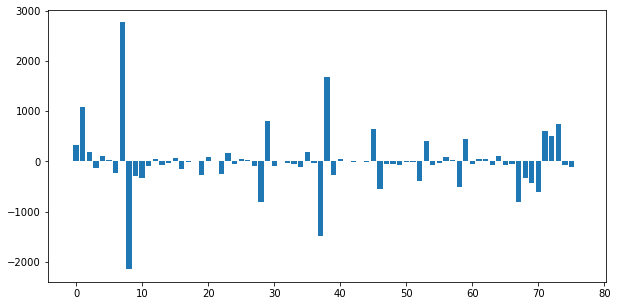

koeficijenti:

  [ 3.18204615e+02  1.08744116e+03  1.93631795e+02 -1.32952517e+02
  1.07236267e+02  2.49989933e+01 -2.37637790e+02  2.77535838e+03
 -2.15551323e+03 -2.97372621e+02 -3.40104778e+02 -9.15545460e+01
  4.14568264e+01 -6.65742272e+01 -3.21049988e+01  6.43510497e+01
 -1.44836627e+02 -1.14218908e+01  8.39248063e+00 -2.68266720e+02
  9.72198678e+01  1.17051728e+01 -2.54514647e+02  1.58321989e+02
 -5.43035987e+01  4.05834679e+01  2.71106590e+01 -9.46606934e+01
 -8.02732771e+02  8.04703223e+02 -8.22566227e+01  7.50080758e+00
 -3.54026441e+01 -4.75842594e+01 -1.02921905e+02  1.84882364e+02
 -2.54341017e+01 -1.48353785e+03  1.69394869e+03 -2.73431022e+02
  5.69055016e+01  6.64690692e+00 -1.06856629e+01 -3.78595796e-01
 -9.00106205e+00  6.49030491e+02 -5.42171346e+02 -4.75123380e+01
 -4.52975734e+01 -7.85634902e+01 -8.44577596e+00 -5.96105229e+00
 -3.92167971e+02  4.10057862e+02 -6.56517912e+01 -2.22114441e+01
  8.45972792e+01  3.75976753e+01 -5.00729193e+02  4.55810517e+02
 -5.1035

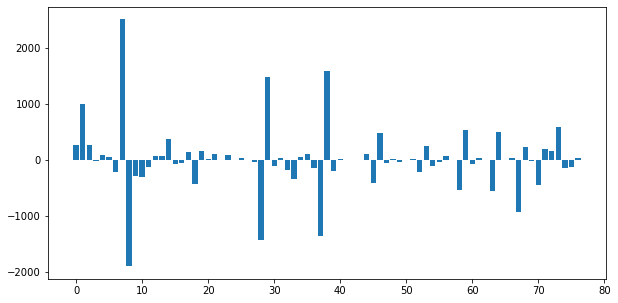

koeficijenti:

  [ 2.63935014e+02  1.00326880e+03  2.74563580e+02 -9.99419466e+00
  8.77395527e+01  4.92541008e+01 -2.18787163e+02  2.51324708e+03
 -1.90257244e+03 -2.92969879e+02 -3.00669309e+02 -1.32188803e+02
  6.41582461e+01  6.86485864e+01  3.80942699e+02 -7.73941067e+01
 -5.02096045e+01  1.48507729e+02 -4.28009717e+02  1.57208269e+02
  9.38224787e+00  9.82983137e+01 -0.00000000e+00  9.01588284e+01
 -2.87801369e+00  3.00236953e+01 -3.42714185e+00 -3.33085585e+01
 -1.42763870e+03  1.47839916e+03 -1.05455452e+02  3.29099772e+01
 -1.72191457e+02 -3.37128201e+02  5.06733605e+01  1.12495708e+02
 -1.40217712e+02 -1.35706799e+03  1.58602369e+03 -2.05695491e+02
  1.11297748e+01 -6.16937404e+00  5.35671405e+00  0.00000000e+00
  1.02050967e+02 -4.11145574e+02  4.82107619e+02 -5.76439007e+01
  1.03075012e+01 -3.24405648e+01 -3.06362793e-01  2.18938372e+01
 -2.15195126e+02  2.54643179e+02 -1.15443836e+02 -3.57811543e+01
  6.96662180e+01  6.88108600e+00 -5.44211962e+02  5.30591924e+02
 -6.7456

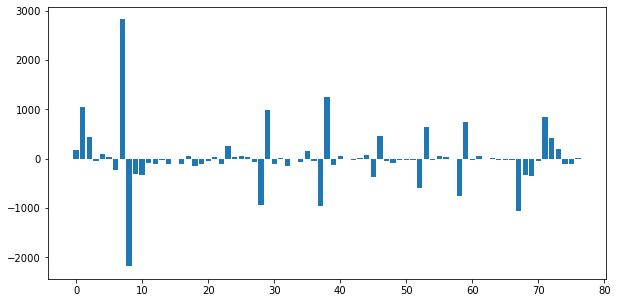

koeficijenti:

  [ 1.66924357e+02  1.04487309e+03  4.29823383e+02 -5.01794128e+01
  9.48739331e+01  2.41884162e+01 -2.34882244e+02  2.82538670e+03
 -2.18983805e+03 -3.16195707e+02 -3.36365294e+02 -9.04232398e+01
 -1.04104028e+02 -2.98113180e+01 -1.04564342e+02 -1.91320335e+00
 -1.15508826e+02  5.35374201e+01 -1.57834662e+02 -1.04533510e+02
 -4.45603208e+01  2.64751670e+01 -1.18666996e+02  2.63128251e+02
  4.12187549e+01  4.93401118e+01  3.78247338e+01 -6.45383657e+01
 -9.33021111e+02  9.88451885e+02 -1.14178115e+02  1.42233627e+01
 -1.48197354e+02 -3.11908280e+00 -6.10585846e+01  1.48238636e+02
 -4.39790733e+01 -9.53373555e+02  1.24068951e+03 -1.32398294e+02
  4.59665389e+01 -2.56857463e+00 -2.03289844e+01  6.51085960e+00
  8.18347970e+01 -3.69665915e+02  4.57389112e+02 -5.23878620e+01
 -8.78256640e+01 -2.11082150e+01 -2.47776321e+01 -3.22775279e+01
 -5.94315625e+02  6.34379498e+02 -2.04501648e+01  4.75515115e+01
  2.92799642e+01 -7.16447241e-01 -7.60343759e+02  7.41263803e+02
 -2.5540

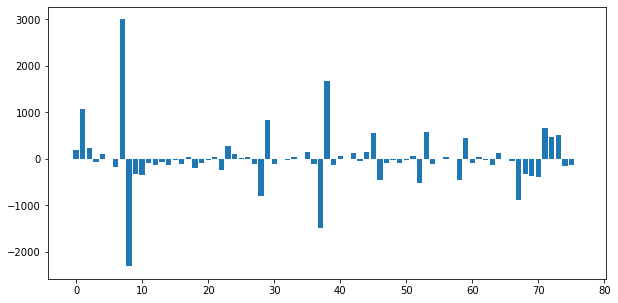

koeficijenti:

  [ 1.97344357e+02  1.07470904e+03  2.39719607e+02 -6.90675448e+01
  1.08328476e+02 -7.62646556e+00 -1.66001718e+02  3.00301824e+03
 -2.31162354e+03 -3.21856009e+02 -3.46617933e+02 -9.72986103e+01
 -1.19539256e+02 -6.38906470e+01 -1.37527549e+02 -1.57124967e+01
 -1.17997908e+02  5.20295088e+01 -1.92814365e+02 -9.09717503e+01
 -1.71371542e+01  4.31771620e+01 -2.30853205e+02  2.86648342e+02
  9.75846813e+01  2.02127119e+01  4.41954360e+01 -9.76084021e+01
 -7.98449711e+02  8.36007463e+02 -1.12313885e+02  1.05475191e+00
 -2.97786143e+01  5.17567762e+01 -1.06401363e+01  1.57322686e+02
 -9.75103629e+01 -1.48608279e+03  1.66941104e+03 -1.39390775e+02
  6.87208715e+01 -1.45984632e+00  1.29743494e+02 -4.22450730e+01
  1.48505343e+02  5.49967213e+02 -4.44585301e+02 -9.40746347e+01
 -2.59408513e+01 -8.54300850e+01 -1.21302369e+01  5.33320825e+01
 -5.22518083e+02  5.83685243e+02 -1.03529366e+02  2.07724558e+00
  3.75820958e+01  3.54121581e-01 -4.53295252e+02  4.49165120e+02
 -8.1794

In [69]:
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0
kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    print(train_index.shape)
    print(test_index.shape)
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)
    
    
    # Model initialization
    lasso_model = Lasso(alpha=0.01)

    # Fit the data(train the model)
    lasso_model.fit(x_inter_train, Y_train)

    # Predict
    Y_pred = lasso_model.predict(x_inter_test)



    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("\n\nmse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj
    #ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
    plt.show()
    print("koeficijenti:\n\n ", lasso_model.coef_)
    
print("\n\nprosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)


# Stabla odluke

In [90]:
day = pd.read_csv('day.csv')

day.drop("instant", axis=1, inplace=True)

day.drop("dteday", axis=1, inplace=True)
day.drop("casual", axis=1, inplace=True)
day.drop("registered", axis=1, inplace=True)
day

season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
0         1   0     1        0        6           0           2  0.344167   
1         1   0     1        0        0           0           2  0.363478   
2         1   0     1        0        1           1           1  0.196364   
3         1   0     1        0        2           1           1  0.200000   
4         1   0     1        0        3           1           1  0.226957   
..      ...  ..   ...      ...      ...         ...         ...       ...   
726       1   1    12        0        4           1           2  0.254167   
727       1   1    12        0        5           1           2  0.253333   
728       1   1    12        0        6           0           2  0.253333   
729       1   1    12        0        0           0           1  0.255833   
730       1   1    12        0        1           1           2  0.215833   

        atemp       hum  windspeed   cnt  
0    0.363625  0.805833   0.160446   985  
1    0.353739  0.696087   0.248539   801  
2    0.189405  0.437273   0.248309  1349  
3    0.212122  0.590435   0.160296  1562  
4    0.229270  0.436957   0.186900  1600  
..        ...       ...        ...   ...  
726  0.226642  0.652917   0.350133  2114  
727  0.255046  0.590000   0.155471  3095  
728  0.242400  0.752917   0.124383  1341  
729  0.231700  0.483333   0.350754  1796  
730  0.223487  0.577500   0.154846  2729  

[731 rows x 12 columns]

In [91]:

#KREIRANJE DUMMY VARIJABLI ZA ODREDJENA OBELEZJA

day = pd.get_dummies(data=day,columns=["season","mnth","weekday","weathersit"],drop_first=True)


day

yr  holiday  workingday      temp     atemp       hum  windspeed   cnt  \
0     0        0           0  0.344167  0.363625  0.805833   0.160446   985   
1     0        0           0  0.363478  0.353739  0.696087   0.248539   801   
2     0        0           1  0.196364  0.189405  0.437273   0.248309  1349   
3     0        0           1  0.200000  0.212122  0.590435   0.160296  1562   
4     0        0           1  0.226957  0.229270  0.436957   0.186900  1600   
..   ..      ...         ...       ...       ...       ...        ...   ...   
726   1        0           1  0.254167  0.226642  0.652917   0.350133  2114   
727   1        0           1  0.253333  0.255046  0.590000   0.155471  3095   
728   1        0           0  0.253333  0.242400  0.752917   0.124383  1341   
729   1        0           0  0.255833  0.231700  0.483333   0.350754  1796   
730   1        0           1  0.215833  0.223487  0.577500   0.154846  2729   

     season_2  season_3  ...  mnth_11  mnth_12  weekday_1  weekday_2  \
0           0         0  ...        0        0          0          0   
1           0         0  ...        0        0          0          0   
2           0         0  ...        0        0          1          0   
3           0         0  ...        0        0          0          1   
4           0         0  ...        0        0          0          0   
..        ...       ...  ...      ...      ...        ...        ...   
726         0         0  ...        0        1          0          0   
727         0         0  ...        0        1          0          0   
728         0         0  ...        0        1          0          0   
729         0         0  ...        0        1          0          0   
730         0         0  ...        0        1          1          0   

     weekday_3  weekday_4  weekday_5  weekday_6  weathersit_2  weathersit_3  
0            0          0          0          1             1             0  
1            0          0          0          0             1             0  
2            0          0          0          0             0             0  
3            0          0          0          0             0             0  
4            1          0          0          0             0             0  
..         ...        ...        ...        ...           ...           ...  
726          0          1          0          0             1             0  
727          0          0          1          0             1             0  
728          0          0          0          1             1             0  
729          0          0          0          0             0             0  
730          0          0          0          0             1             0  

[731 rows x 30 columns]

In [92]:

Y=day.pop('cnt')

X=day

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.15, random_state=46)



# Decision tree

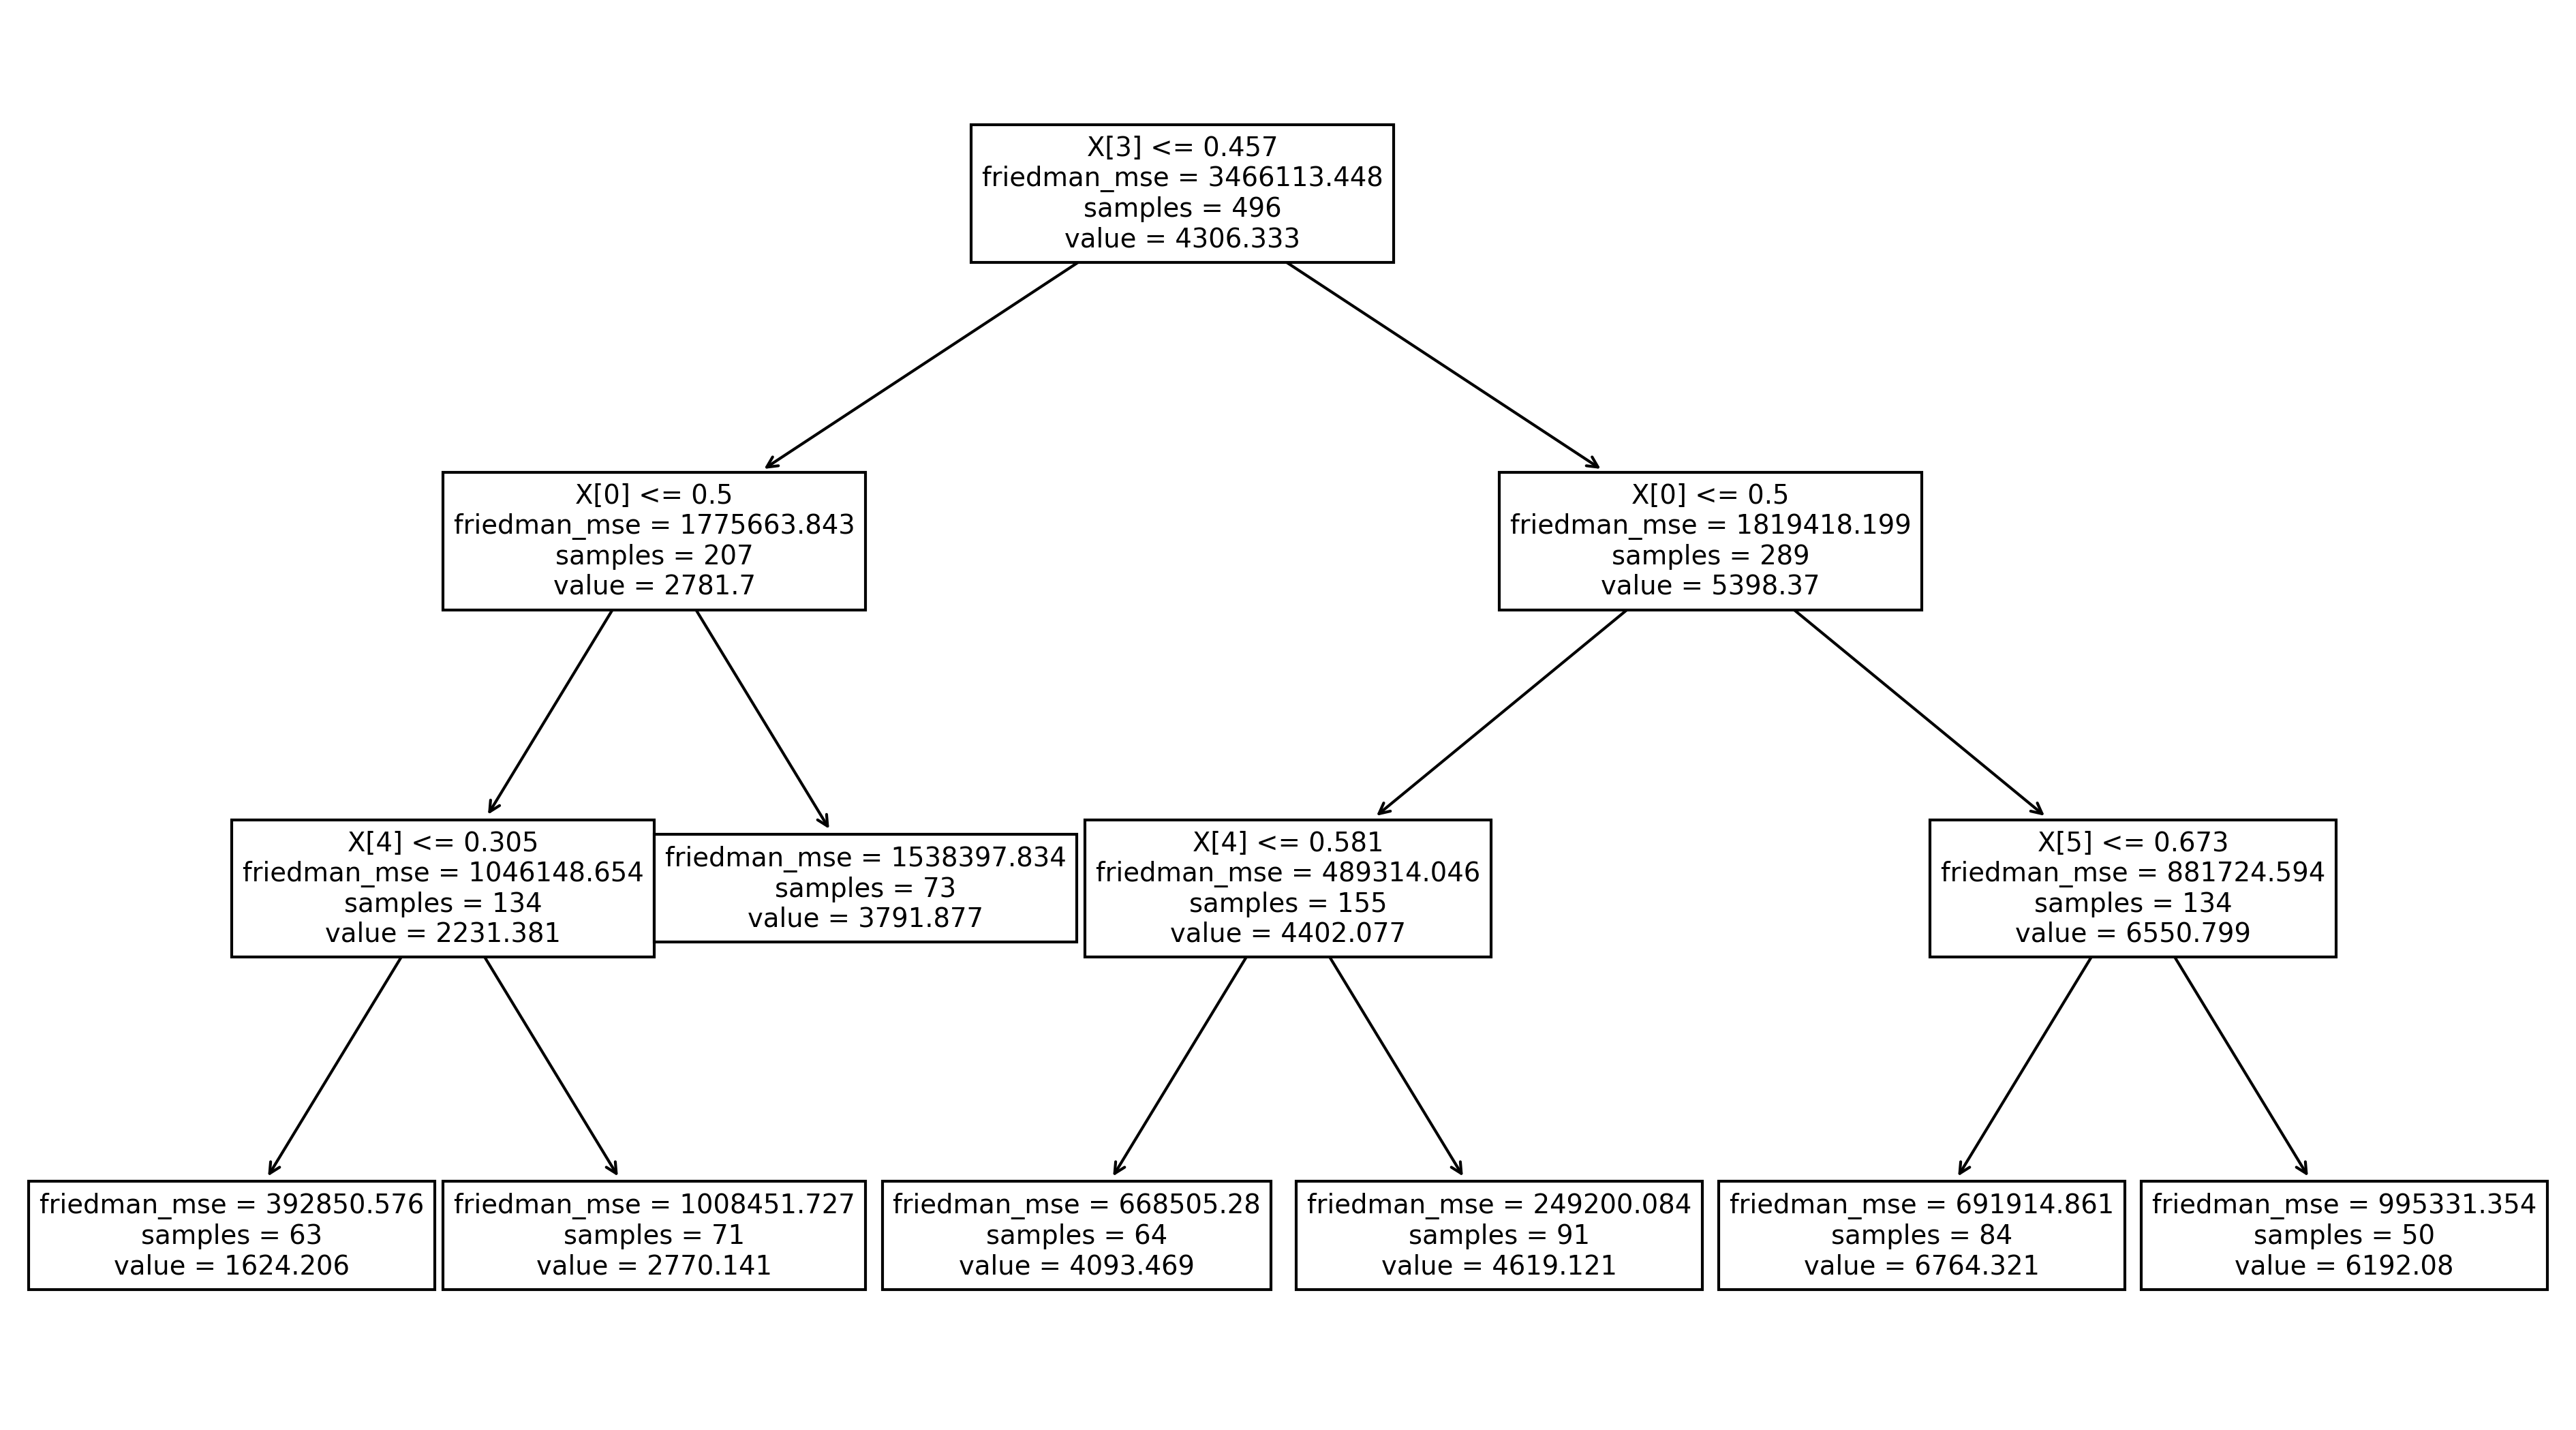

mse = 1114781.2150770419
mae = 778.4489239520296
rmse = 1055.832001351087
r2 score = 0.681550451664201
r2 adjusted = 0.661732775909398





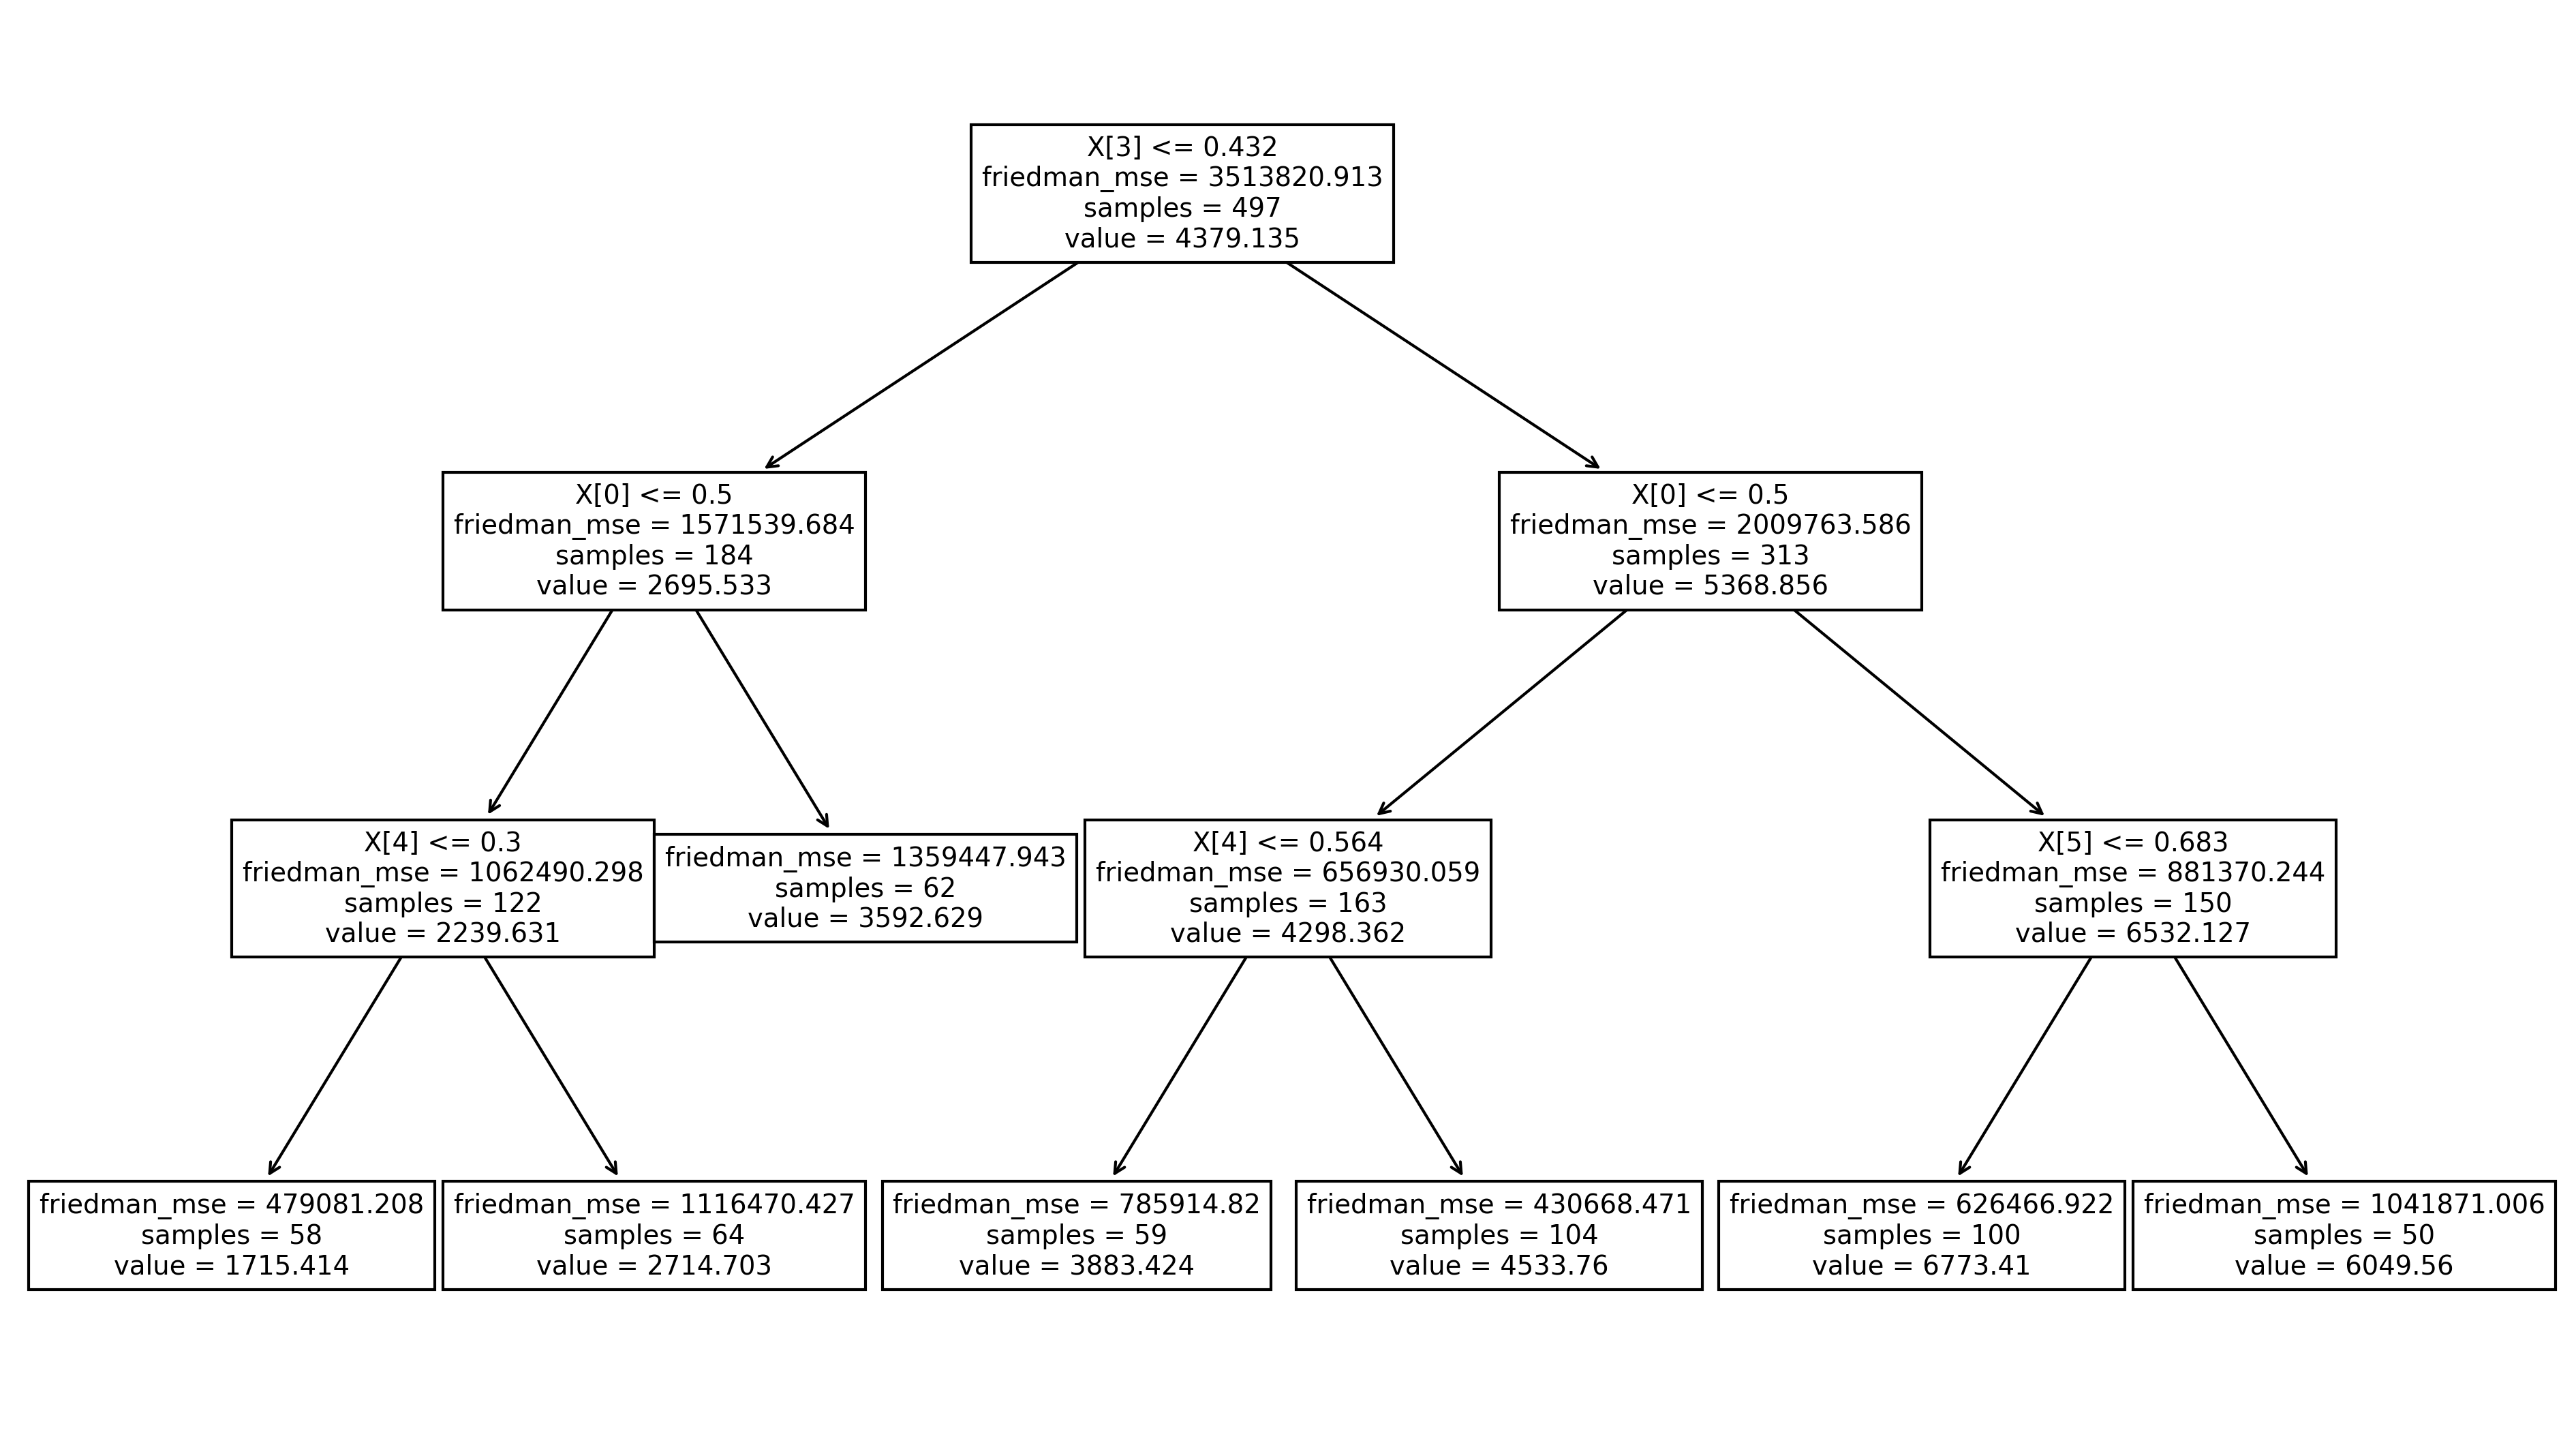

mse = 841259.1159433926
mae = 729.4993574027186
rmse = 917.2017858374419
r2 score = 0.7403102501703698
r2 adjusted = 0.724183905962534





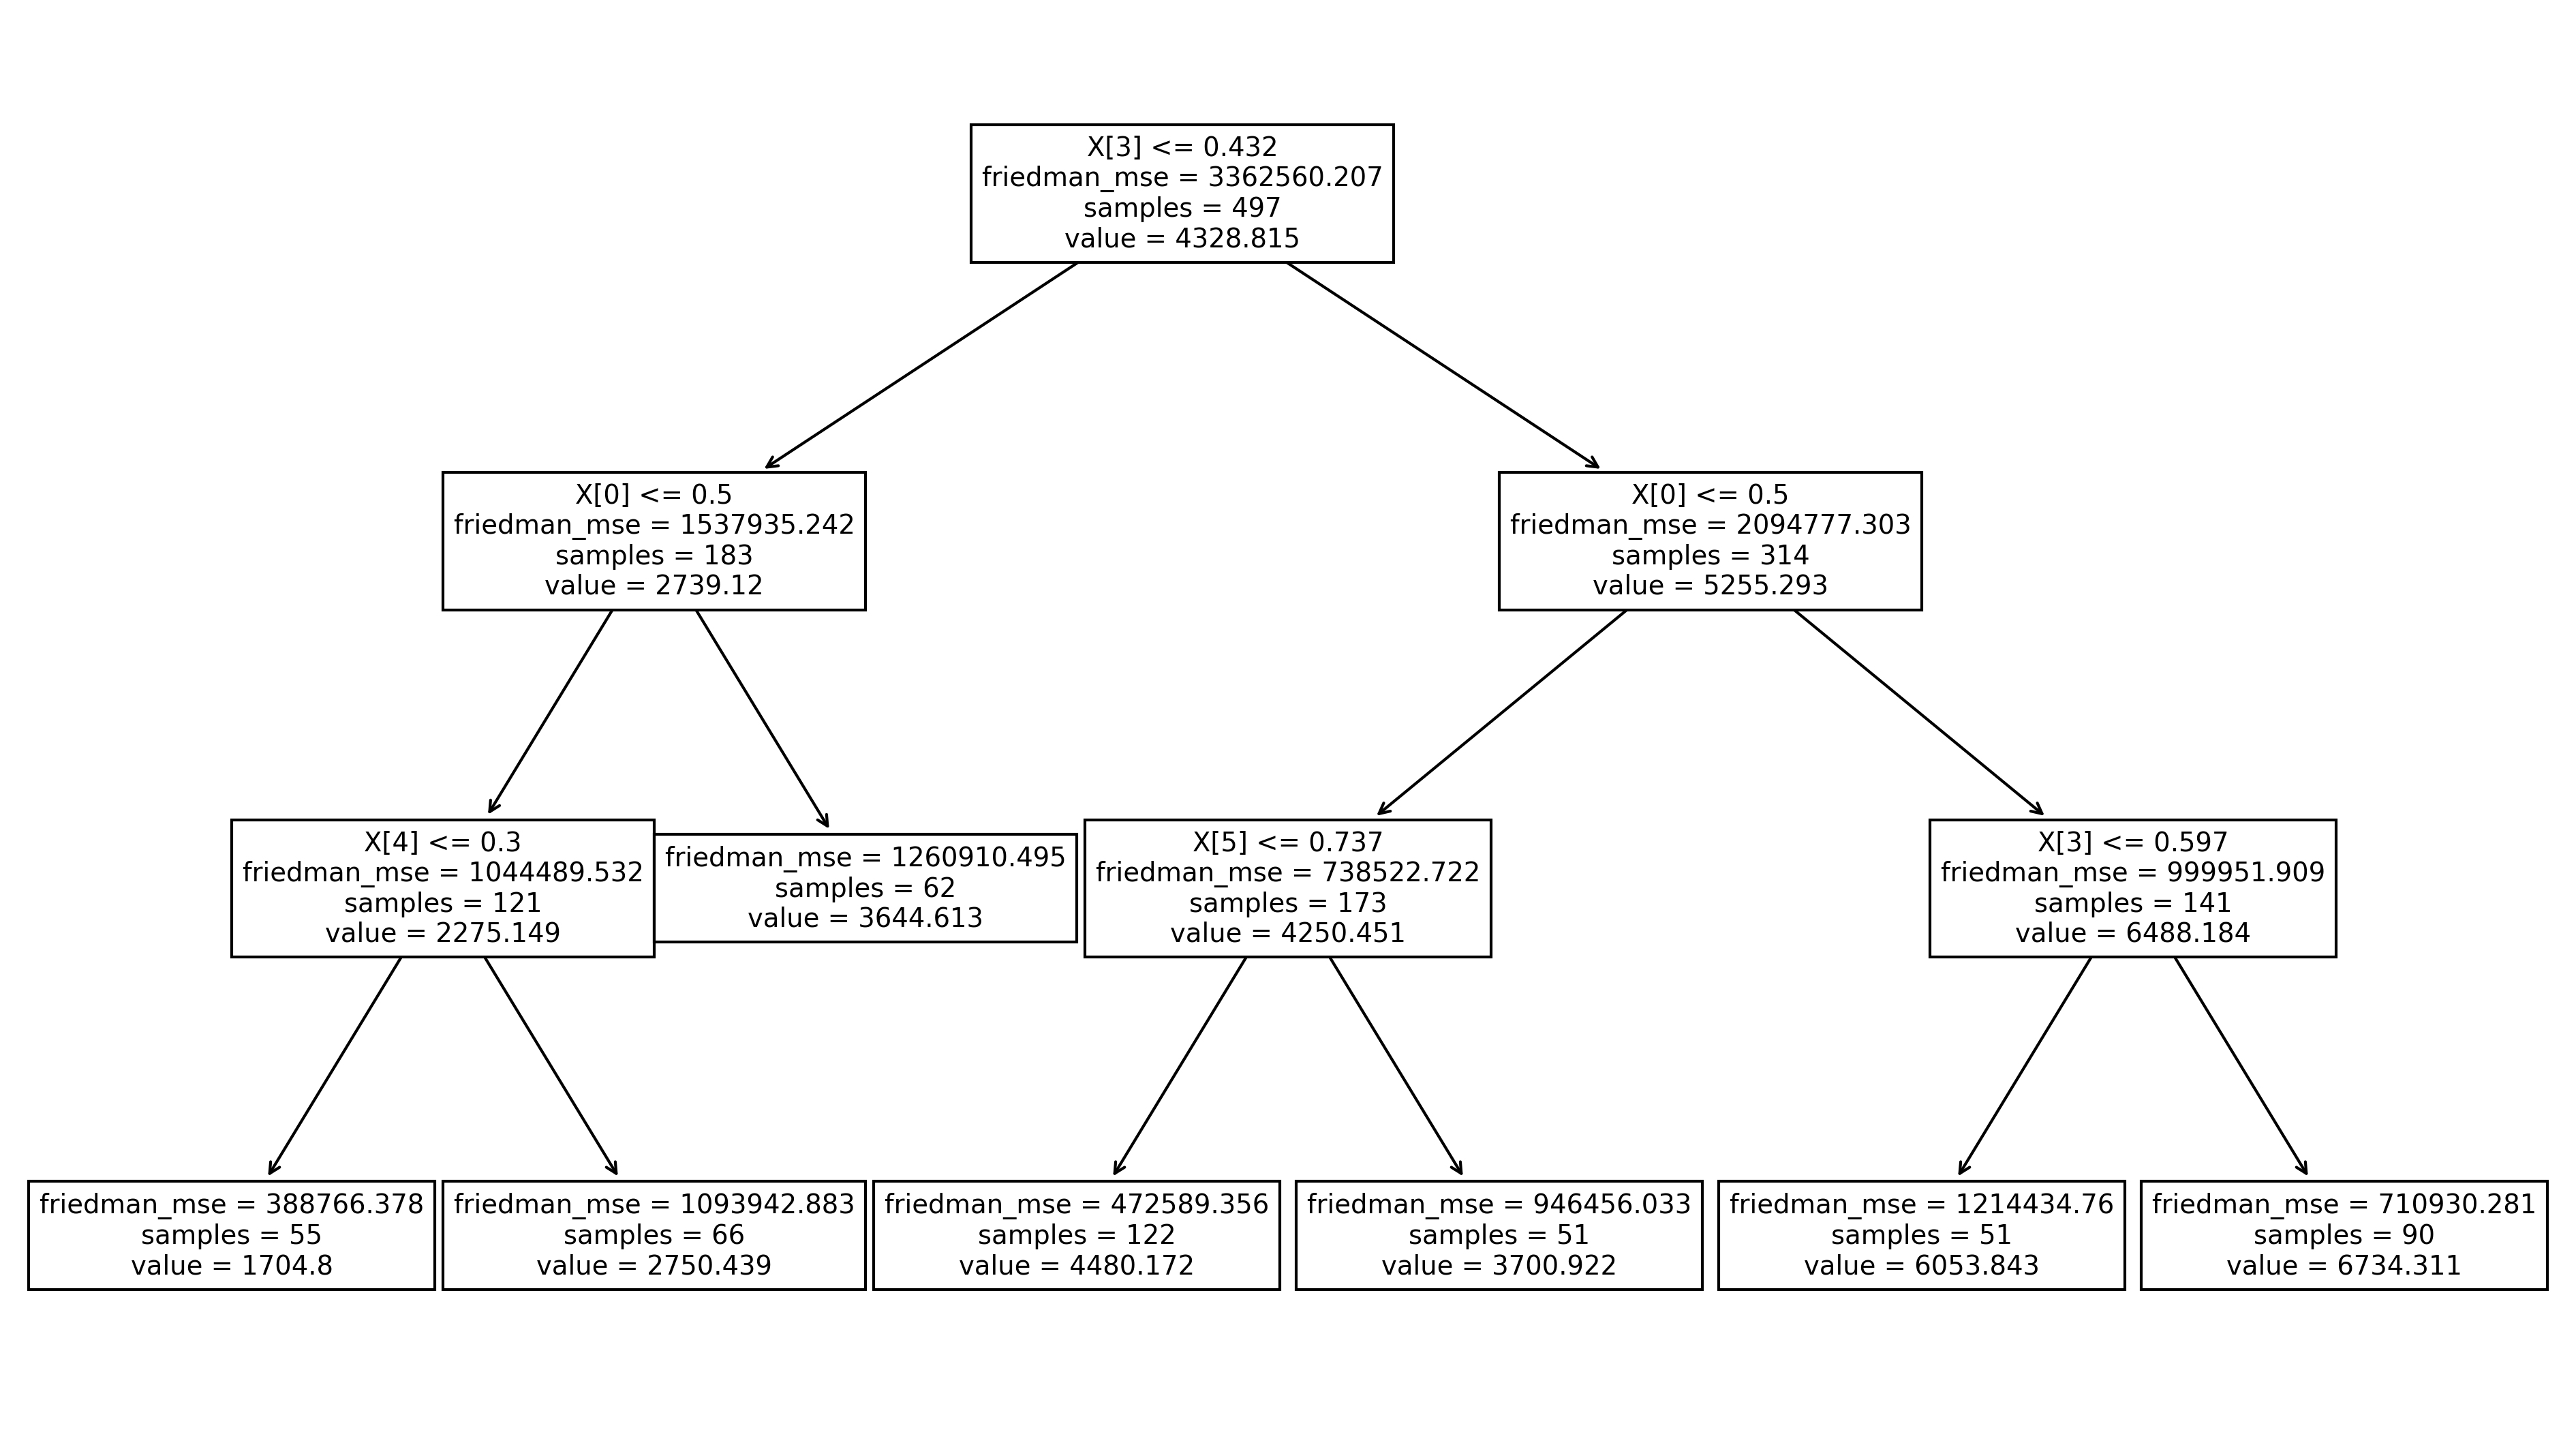

mse = 738016.7499924684
mae = 696.8600884154752
rmse = 859.0790126597602
r2 score = 0.8115850470938388
r2 adjusted = 0.7998847609390665





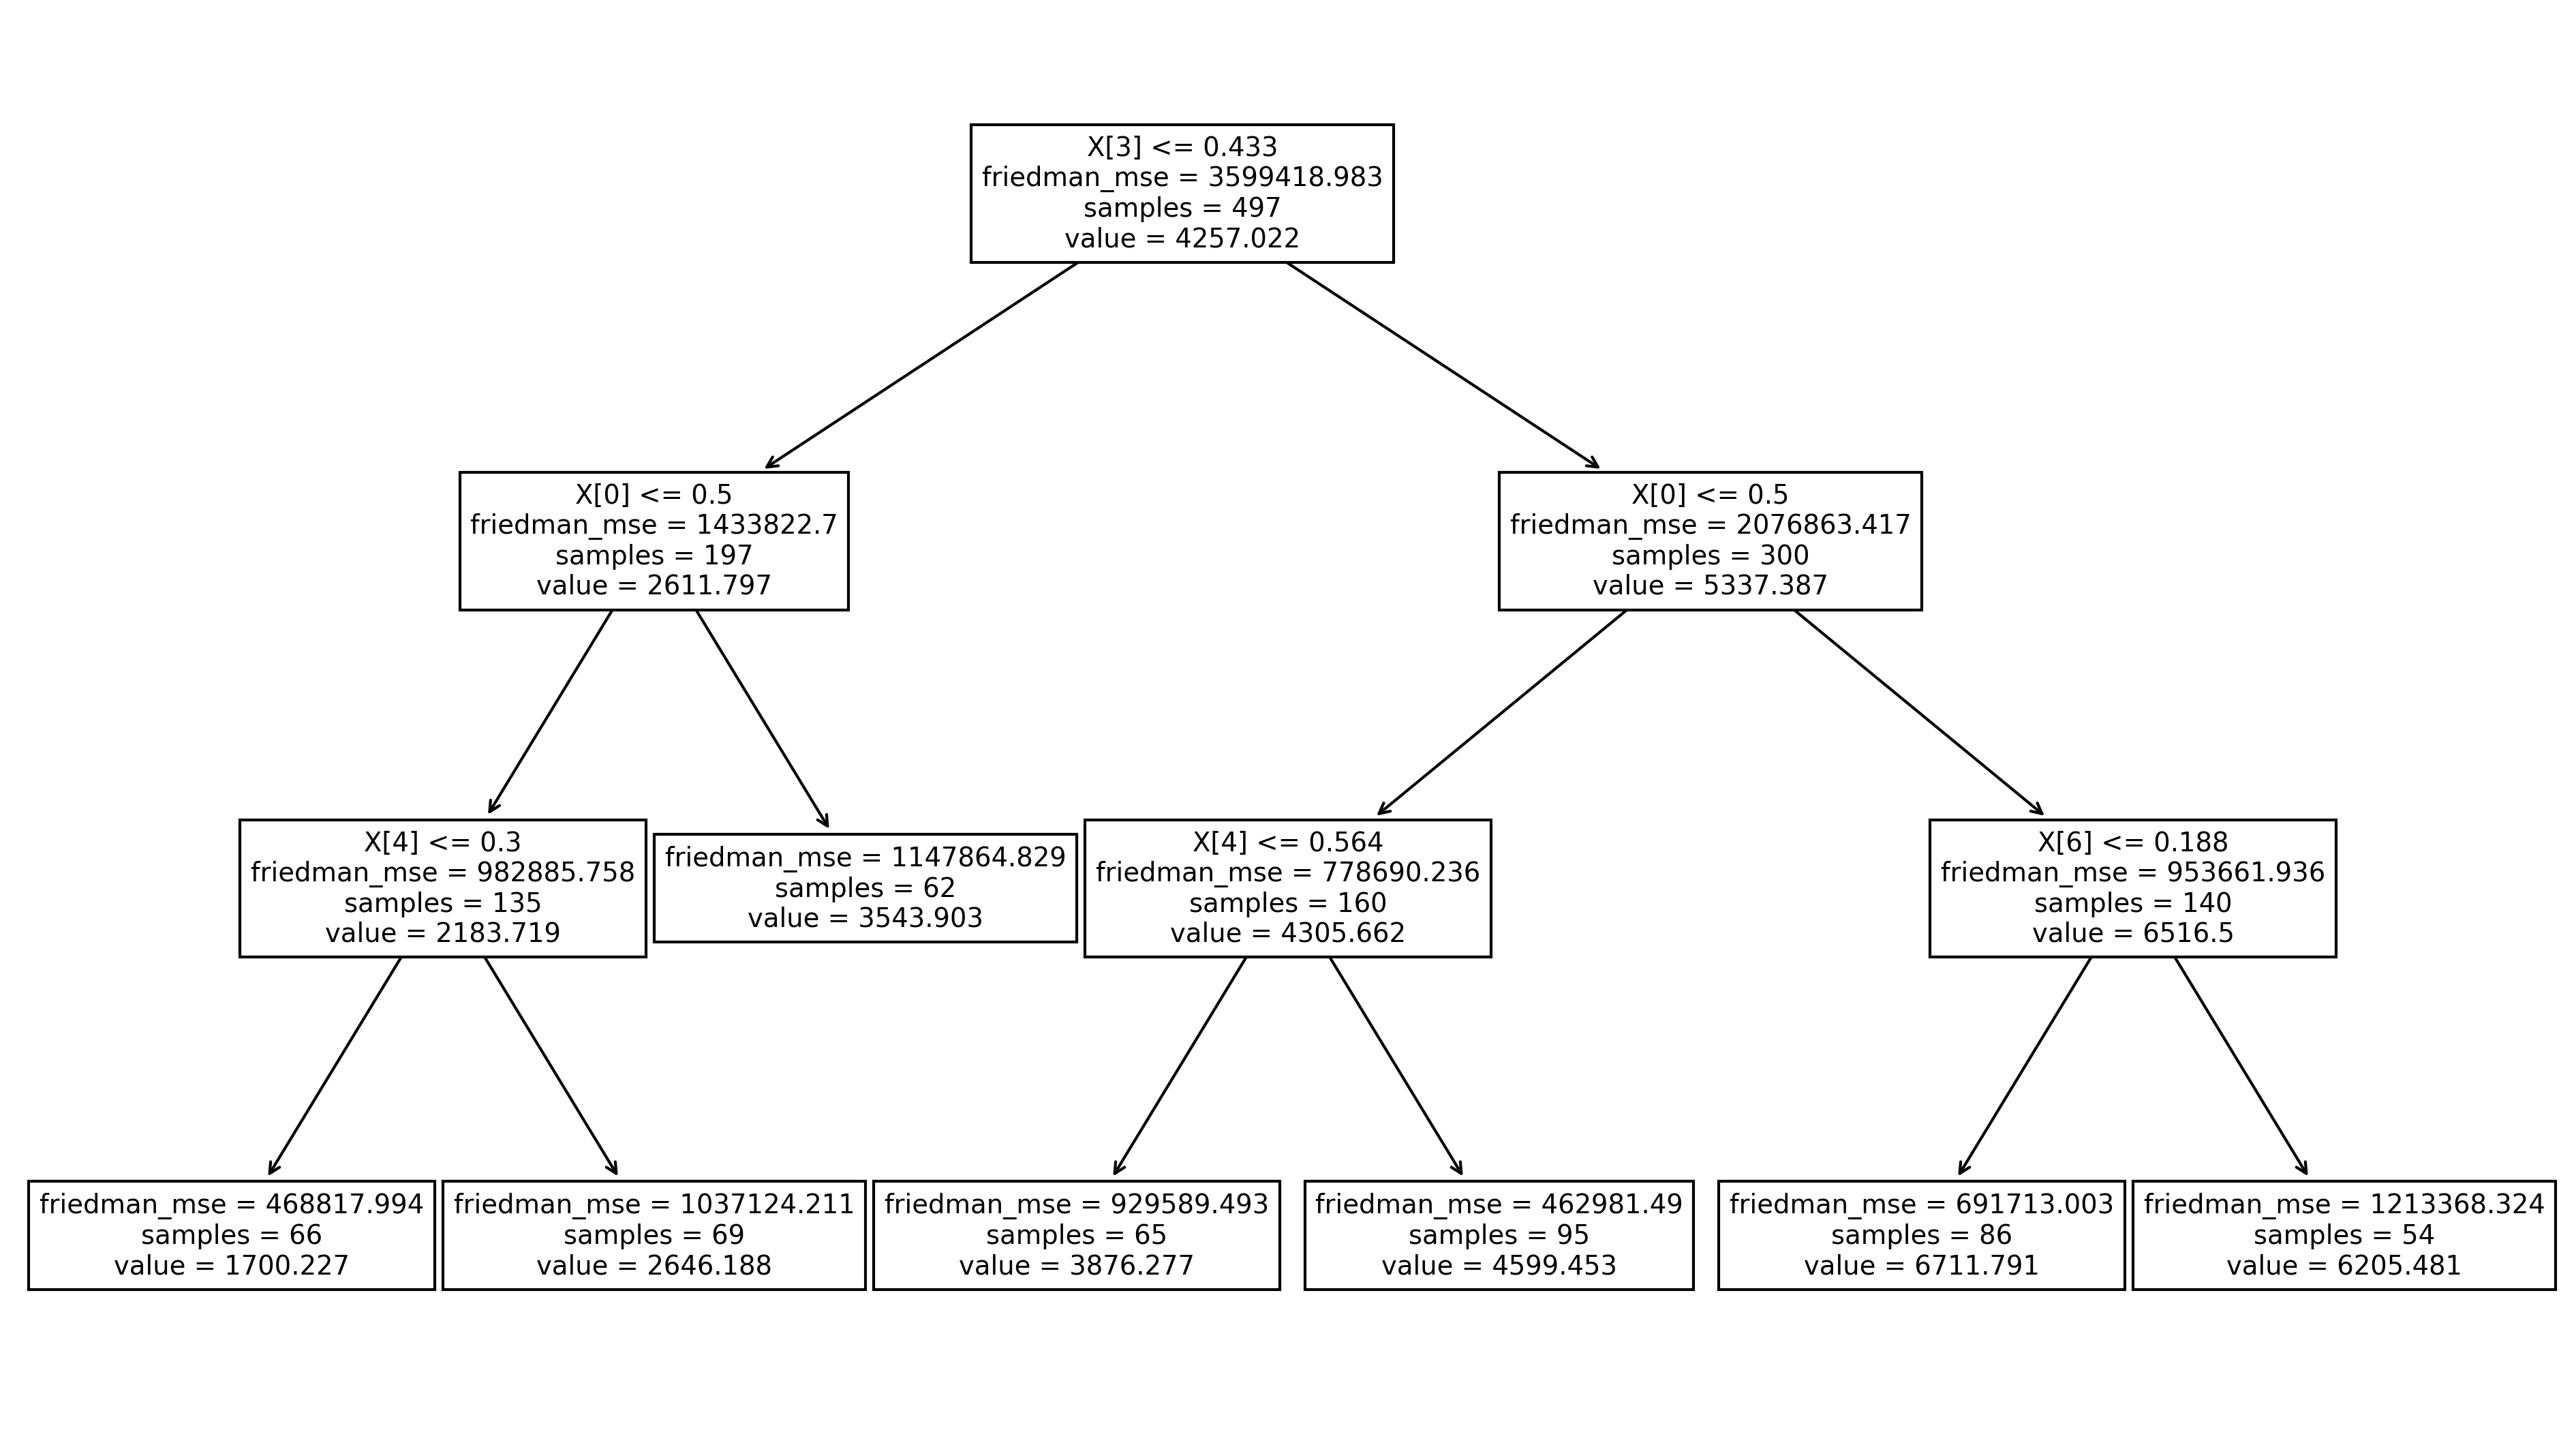

mse = 762718.6996605782
mae = 715.3005903888867
rmse = 873.3376779119163
r2 score = 0.7363836390813424
r2 adjusted = 0.7200134582105906





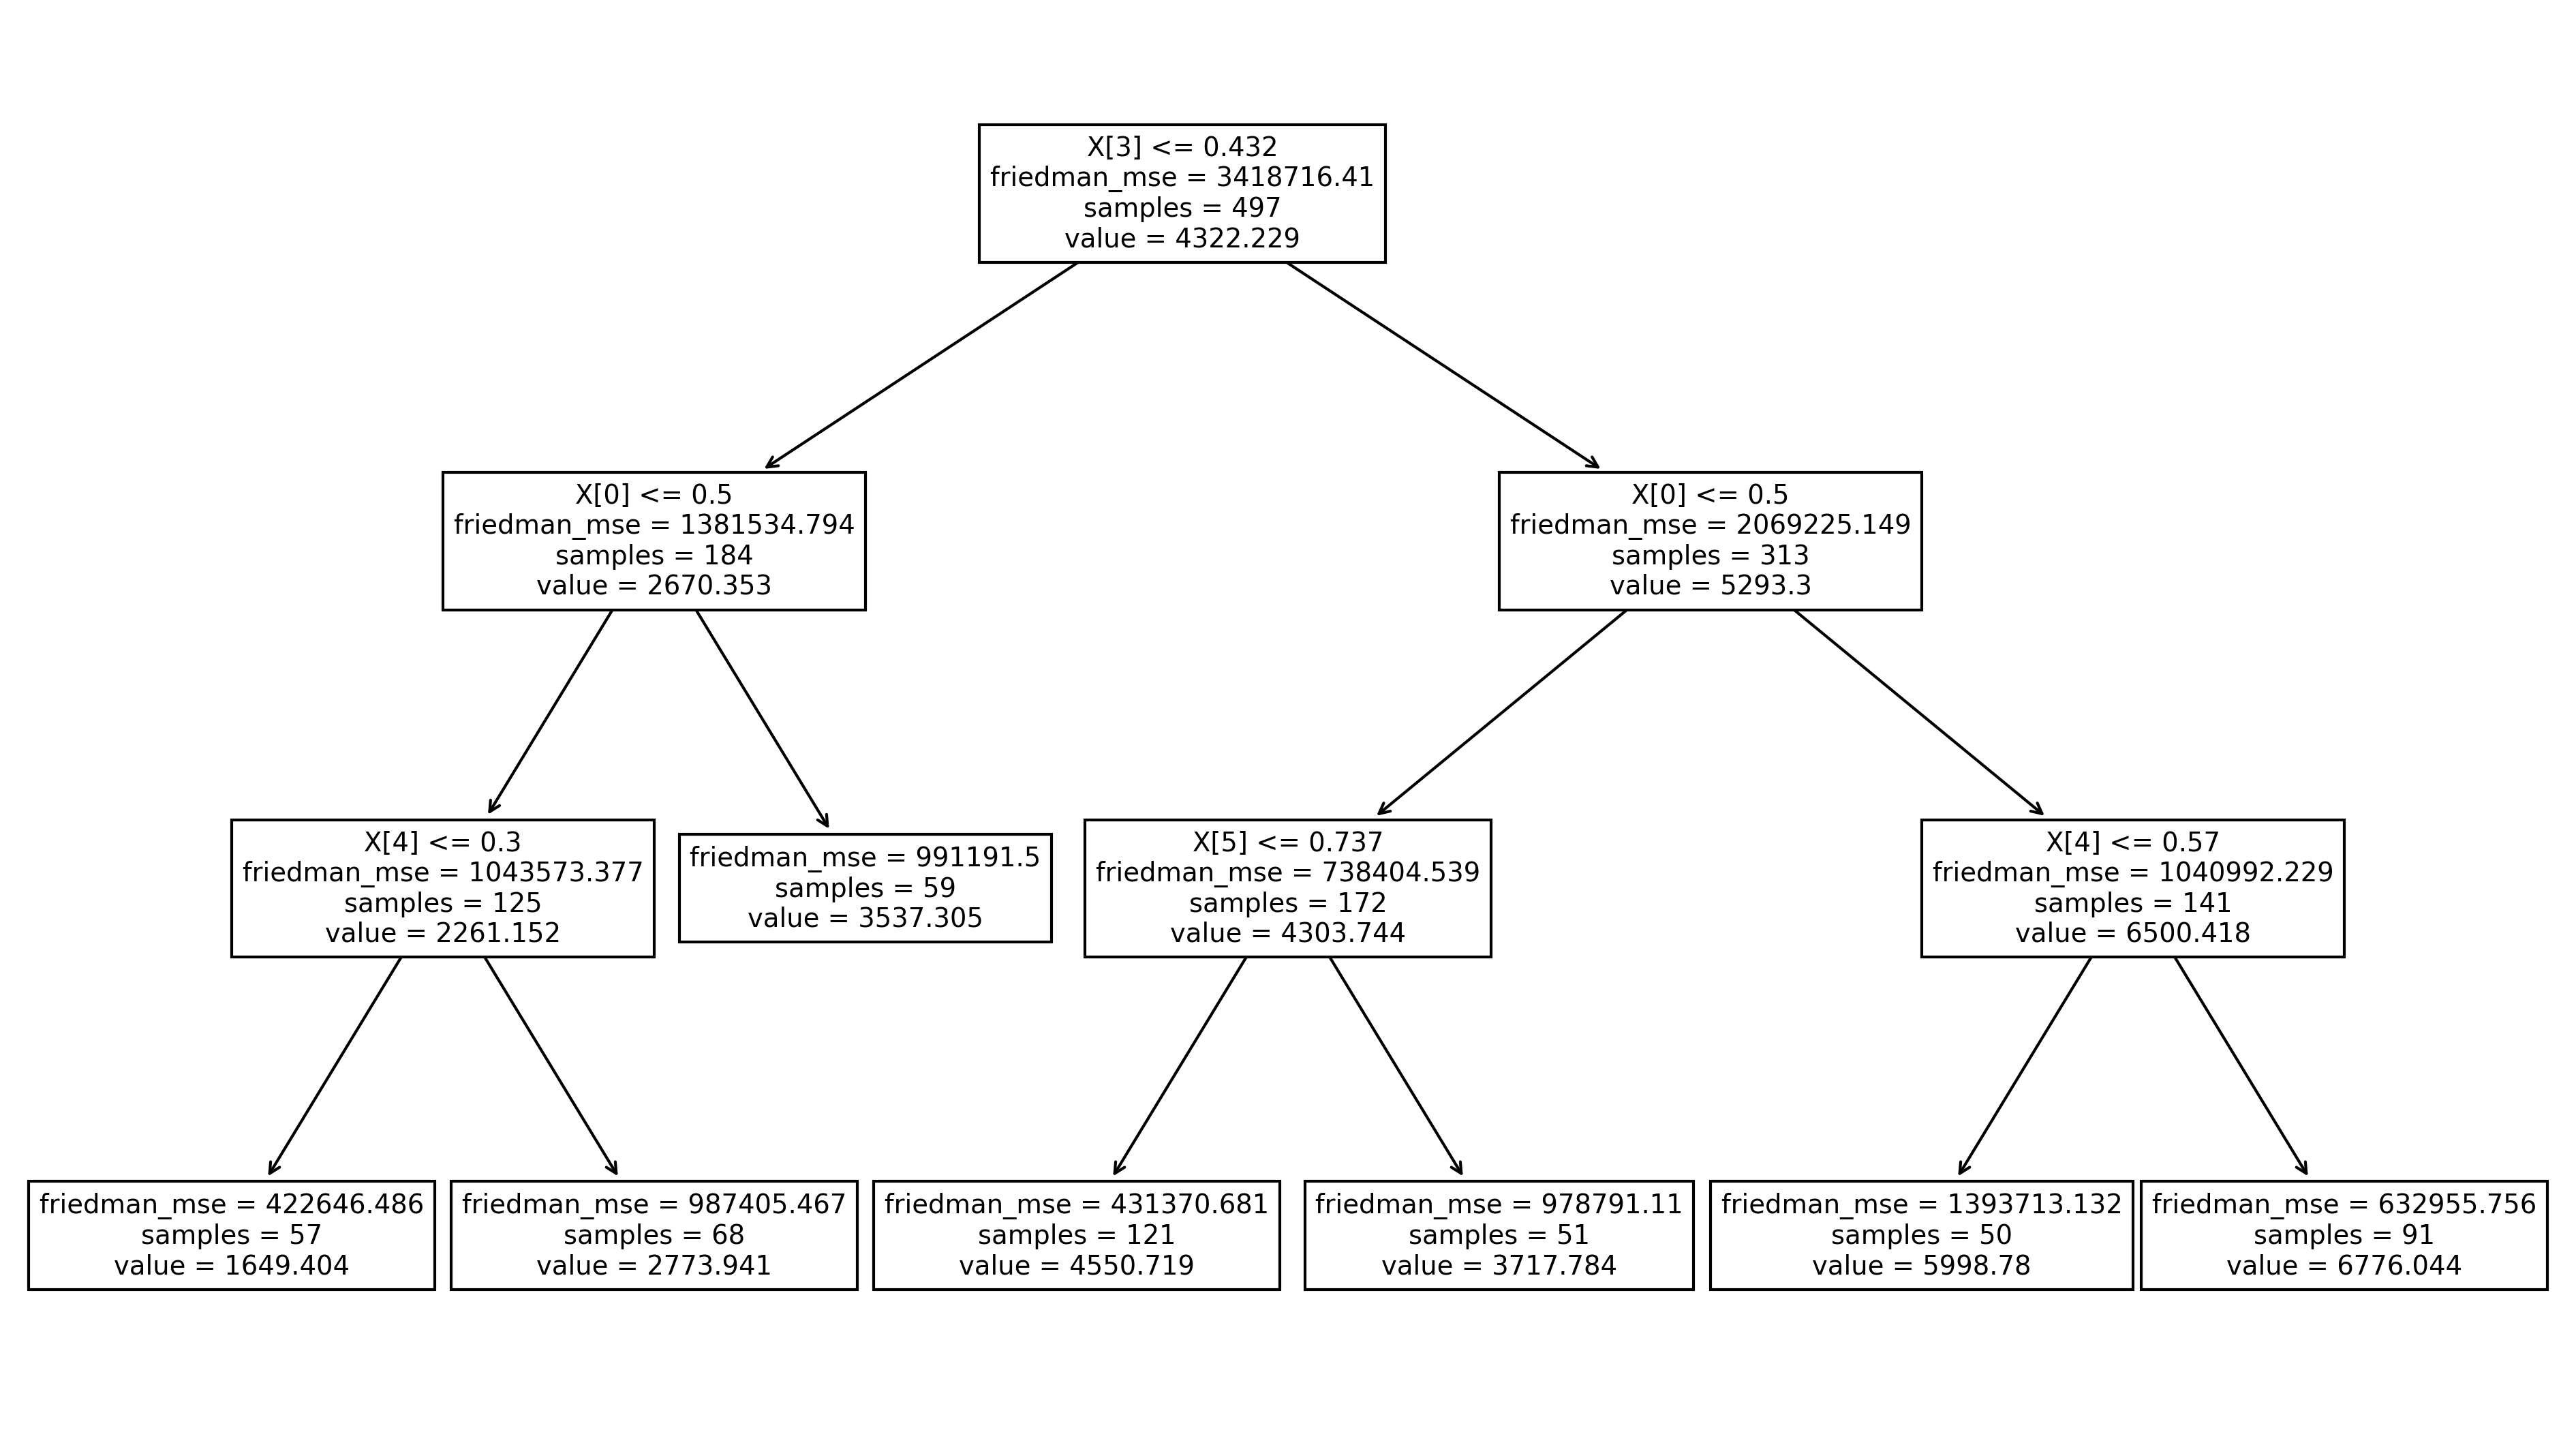

mse = 969828.117676759
mae = 740.6748881111942
rmse = 984.7985162848079
r2 score = 0.7374371054581561
r2 adjusted = 0.7211323432703328



prosek mse = 885320.7796700479
prosek mae = 732.1567696540609
prosek rmse = 938.0497988090026
prosek r2 = 0.7414532986935816
prosek r2 adjusted = 0.7253894488583844


In [73]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

#daje slican rezultat sa standardizacijom obelezja i bez iste

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(X1_train, Y1_train)

for train_index, test_index in indexes:

    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    
    
#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     x_inter_train = poly.fit_transform(X_train)
#     x_inter_test = poly.transform(X_test)
    
    

    regressor = DecisionTreeRegressor(max_depth=3,criterion='friedman_mse',max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='best')
    regressor.fit(X_train, Y_train)
    
    plt.figure(figsize=(16,9), dpi=300)
    tree.plot_tree(regressor)
    plt.show()

    Y_pred = regressor.predict(X_test)


    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj

print("prosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)

# Random forest

In [74]:

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0    
kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(X1_train, Y1_train)

for train_index, test_index in indexes:

    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    
    
#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     x_inter_train = poly.fit_transform(X_train)
#     x_inter_test = poly.transform(X_test)
    
    
    regressor = RandomForestRegressor(n_estimators=100, max_depth=5,max_features=None,max_leaf_nodes=50,min_samples_leaf=1,min_weight_fraction_leaf=0.1,criterion='friedman_mse')
    regressor.fit(X_train, Y_train)
    

    Y_pred = regressor.predict(X_test)


    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj
    
print("prosek mse =",mse_acc/5)
print("prosek mae =",mae_acc/5)
print("prosek rmse =",rmse_acc/5)
print("prosek r2 =",r2_acc/5)
print("prosek r2 adjusted =",r2_adj_acc/5)

mse = 906378.7740991323
mae = 709.482450998903
rmse = 952.0392713008914
r2 score = 0.7410829072742526
r2 adjusted = 0.7249700409887447



mse = 779894.4511934407
mae = 703.5227025872109
rmse = 883.116329366319
r2 score = 0.7592530160023021
r2 adjusted = 0.744302989158762



mse = 731058.4180309981
mae = 699.6598794065432
rmse = 855.0195424848475
r2 score = 0.813361502423395
r2 adjusted = 0.8017715314818071



mse = 628627.0239230596
mae = 645.5157340537347
rmse = 792.8600279513778
r2 score = 0.7827293752002288
r2 adjusted = 0.7692371950734764



mse = 803321.2924044735
mae = 683.2452785641638
rmse = 896.2819268536399
r2 score = 0.7825157263061399
r2 adjusted = 0.7690102789033091



prosek mse = 769855.9919302209
prosek mae = 688.2852091221112
prosek rmse = 875.863419591415
prosek r2 = 0.7757885054412637
prosek r2 adjusted = 0.7618584071212199


450


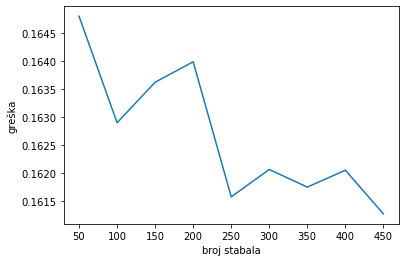

In [166]:
error_rate=[]
num_estimators = np.arange(50, 500, 50)
for i in num_estimators:
    regressor = RandomForestRegressor(n_estimators=i, max_depth=5, oob_score=True)
    regressor.fit(X1_train.values, Y1_train)
    oob_error = 1 - regressor.oob_score_
    error_rate.append(oob_error)

tmp = error_rate.index(min(error_rate))
print(num_estimators[tmp])
plt.plot(np.arange(50,500,50), error_rate)
plt.xlabel('broj stabala')
plt.ylabel('greška')
plt.show()

#ovde je dobijeno n_estimators 450, medjutim GridSearchCV je u kombinaciji sa mnogo vise parametara dao 100 tako da
#smo se odlucili za vrednost 100

In [ ]:
#procenjujemo najbolje parametre za decision tree
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':('squared_error', 'friedman_mse','absolute_error','poisson'),
              'splitter':('best', 'random'),
               "max_depth" : [3,5,10],
           "min_samples_leaf":[1,3,5],
           "min_weight_fraction_leaf":[0.1,0.3,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,30,50]}

dt = DecisionTreeRegressor()
clf=GridSearchCV(dt, parameters)
clf.fit(X1_train.values, Y1_train)

print(clf.best_score_)
print(clf.best_params_)

In [75]:

#procenjujemo najbolje parametre za random forest
parameters = {'criterion':('squared_error', 'friedman_mse','absolute_error','poisson'),
               "max_depth" : [3,5,10],
           "min_samples_leaf":[1,3,5],
           "min_weight_fraction_leaf":[0.1,0.3,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,30,50],
           "n_estimators":[100,200,300]
           }

dt = RandomForestRegressor()
clf=GridSearchCV(dt, parameters)
clf.fit(X1_train.values, Y1_train)

print(clf.best_score_)
print(clf.best_params_)


In [95]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree

regressor_dt = DecisionTreeRegressor(max_depth=3,criterion='friedman_mse',max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='best')
regressor_dt.fit(X1_train,Y1_train)

y_predicted_dt = regressor_dt.predict(X1_test)

model_evaluation(Y1_test, y_predicted_dt, X1_train.shape[0], X1_train.shape[1])

Mean squared error:  1101753.9194012198
Mean absolute error:  798.6720578403167
Root mean squared error:  1049.6446633986284
R2 score:  0.6891390349585036
R2 adjusted score:  0.6738852820207653
      y       y_pred
0    16  3813.322034
1    40  6200.298701
2    32  1756.920635
3    13  3813.322034
4     1  3927.954545
5     1  2710.637681
6     2  2710.637681
7     3  3927.954545
8     8  4536.387387
9    14  3813.322034
10   36  6911.623932
11   56  3813.322034
12   84  6911.623932
13   94  3813.322034
14  106  3813.322034
15  110  3813.322034
16   93  3927.954545
17   67  6200.298701
18   35  4536.387387
19   37  1756.920635


In [96]:
import time
start = time.time()

regressor_rf = RandomForestRegressor(n_estimators=100, max_depth=5,max_features=None,max_leaf_nodes=50,min_samples_leaf=1,min_weight_fraction_leaf=0.1,criterion='friedman_mse')
regressor_rf.fit(X1_train,Y1_train)

y_predicted_rf = regressor_rf.predict(X1_test)

model_evaluation(Y1_test, y_predicted_rf, X1_train.shape[0], X1_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

Mean squared error:  862395.5225525267
Mean absolute error:  698.9595678349899
Root mean squared error:  928.6525305799402
R2 score:  0.75667424488597
R2 adjusted score:  0.7447344024184457
      y       y_pred
0    16  3775.939644
1    40  6122.323991
2    32  2009.443880
3    13  3481.212245
4     1  3986.222880
5     1  2384.377370
6     2  3116.290904
7     3  4160.288898
8     8  4571.211964
9    14  3092.960896
10   36  6559.466803
11   56  3636.277372
12   84  6984.912689
13   94  3787.563254
14  106  3681.872746
15  110  3092.960896
16   93  3785.042626
17   67  6202.790821
18   35  4555.208075
19   37  2009.443880
vreme trajanja je:  0.299849271774292  sekundi.


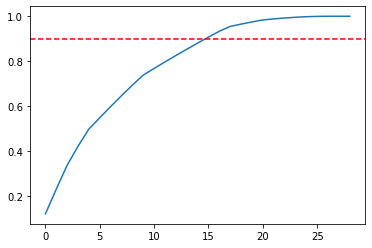

In [83]:
#obucavanje random forest s redukcijom dimenzionalnosti
from sklearn.decomposition import PCA


scaler = StandardScaler(with_std=False)
scaler.fit(X_train)
X1_train_std = scaler.transform(X1_train)
X1_test_std = scaler.transform(X1_test)

pca = PCA(n_components=None)
pca.fit(X1_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.show()



In [84]:
pca = PCA(n_components=0.9)
pca.fit(X1_train_std)
X_train_r = pca.transform(X1_train_std)
X_test_r = pca.transform(X1_test_std)
print('Redukovani prostor ima dimenziju: ', pca.n_components_)

Redukovani prostor ima dimenziju:  16


In [85]:
import time
start = time.time()



# y_predicted = regressor_rf.predict(X1_test)

# model_evaluation(Y1_test, y_predicted, X1_train.shape[0], X1_train.shape[1])

# print('vreme trajanja je: ', time.time() - start, ' sekundi.')

regressor_rf_pca = RandomForestRegressor(n_estimators=100, max_depth=5,criterion='friedman_mse',max_features=None,max_leaf_nodes=50,min_samples_leaf=1,min_weight_fraction_leaf=0.1)
regressor_rf_pca.fit(X_train_r,Y1_train)
y_predicted_pca = regressor_rf_pca.predict(X_test_r)
model_evaluation(Y1_test, y_predicted_pca, X1_train.shape[0], X1_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

Mean squared error:  995404.4267147541
Mean absolute error:  740.4701886066063
Root mean squared error:  997.6995673622165
R2 score:  0.7191456501799458
R2 adjusted score:  0.7053643030652561
       y       y_pred
0    985  6351.300030
1    801  5631.322495
2   1349  1727.670472
3   1562  4423.047247
4   1600  4372.442176
5   1606  3408.836473
6   1510  3832.475265
7    959  3541.162887
8    822  4225.063954
9   1321  3744.285057
10  1263  5601.198749
11  1162  3744.285057
12  1406  6904.527612
13  1421  3744.285057
14  1248  5487.372076
15  1204  3744.285057
16  1000  4094.406942
17   683  5631.322495
18  1650  4218.060259
19  1927  1727.670472
vreme trajanja je:  0.6106510162353516  sekundi.


0.6891390349585036

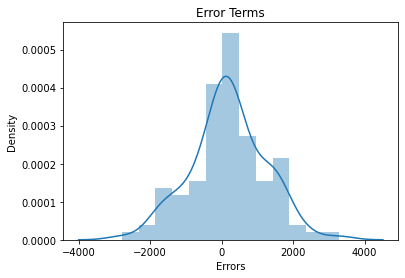

In [88]:


plot_res_dist(Y1_test, y_predicted_dt)
r2_score(Y1_test,y_predicted_dt)

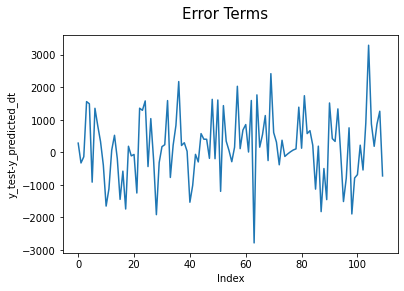

In [90]:
c = [i for i in range(0,len(X1_test),1)]
plt.plot(c,Y1_test-y_predicted_dt)
plt.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('y_test-y_predicted_dt')
plt.show()

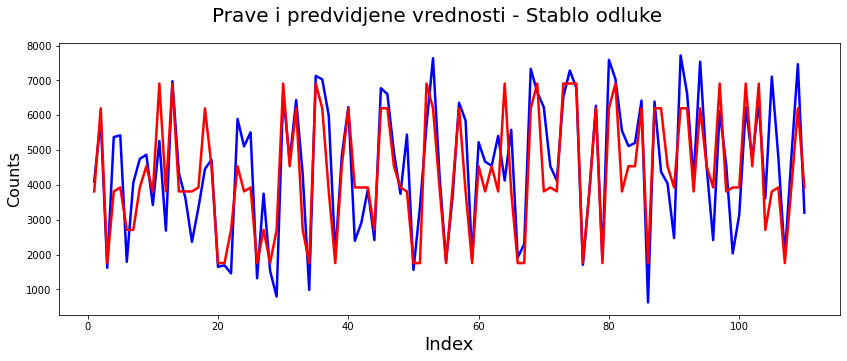

In [97]:
                                
plot_act_pred(Y1_test,y_predicted_dt,len(Y1_test)+1,'Stablo odluke')
#vidi se da ima vise odstupanja nego u slucaju s Ridge regresijom

0.7580045802175639

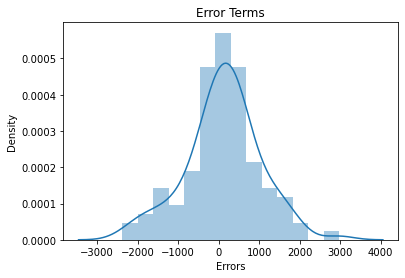

In [93]:
plot_res_dist(Y1_test, y_predicted_rf)
r2_score(Y1_test,y_predicted_rf)

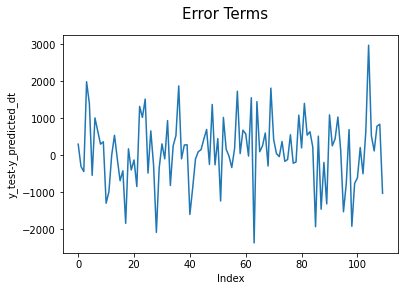

In [94]:
c = [i for i in range(0,len(X1_test),1)]
plt.plot(c,Y1_test-y_predicted_rf)
plt.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('y_test-y_predicted_dt')
plt.show()

Text(0, 0.5, 'y_test_pred')

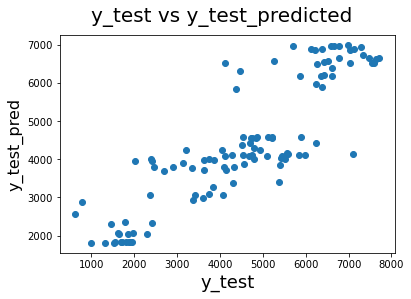

In [95]:
#dijagram rasipanja se moze ali ne bas precizno aproksimirati pravom jer postoji solidna doza rasipanja
fig = plt.figure()
plt.scatter(Y1_test, y_predicted_rf)
fig.suptitle('y_test vs y_test_predicted', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_test_pred', fontsize = 16)

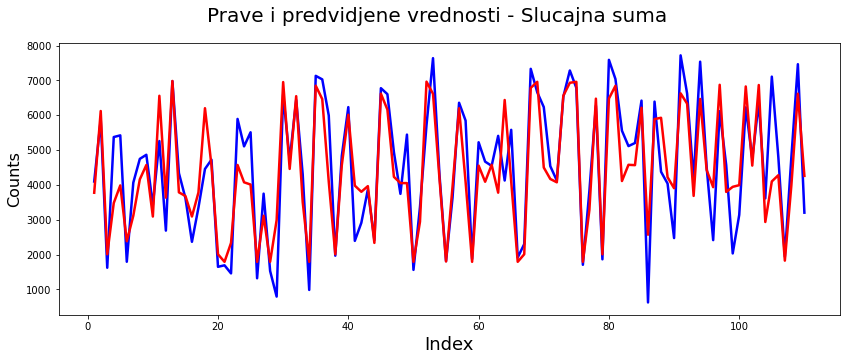

In [99]:
plot_act_pred(Y1_test,y_predicted_rf,len(Y1_test)+1,'Slucajna suma')
#vise odstupanja nego u Ridge a manje nego u DecisionTree

# Neuralna mreza

In [15]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier,MLPRegressor

day = pd.read_csv('day.csv')

day.drop("instant", axis=1, inplace=True)

day.drop("dteday", axis=1, inplace=True)
day.drop("casual", axis=1, inplace=True)
day.drop("registered", axis=1, inplace=True)
day

season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
0         1   0     1        0        6           0           2  0.344167   
1         1   0     1        0        0           0           2  0.363478   
2         1   0     1        0        1           1           1  0.196364   
3         1   0     1        0        2           1           1  0.200000   
4         1   0     1        0        3           1           1  0.226957   
..      ...  ..   ...      ...      ...         ...         ...       ...   
726       1   1    12        0        4           1           2  0.254167   
727       1   1    12        0        5           1           2  0.253333   
728       1   1    12        0        6           0           2  0.253333   
729       1   1    12        0        0           0           1  0.255833   
730       1   1    12        0        1           1           2  0.215833   

        atemp       hum  windspeed   cnt  
0    0.363625  0.805833   0.160446   985  
1    0.353739  0.696087   0.248539   801  
2    0.189405  0.437273   0.248309  1349  
3    0.212122  0.590435   0.160296  1562  
4    0.229270  0.436957   0.186900  1600  
..        ...       ...        ...   ...  
726  0.226642  0.652917   0.350133  2114  
727  0.255046  0.590000   0.155471  3095  
728  0.242400  0.752917   0.124383  1341  
729  0.231700  0.483333   0.350754  1796  
730  0.223487  0.577500   0.154846  2729  

[731 rows x 12 columns]

In [16]:
hour = pd.read_csv('hour.csv')

hour.drop("instant", axis=1, inplace=True)

hour.drop("dteday", axis=1, inplace=True)
hour.drop("casual", axis=1, inplace=True)
hour.drop("registered", axis=1, inplace=True)
hour

season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0           1   0     1   0        0        6           0           1  0.24   
1           1   0     1   1        0        6           0           1  0.22   
2           1   0     1   2        0        6           0           1  0.22   
3           1   0     1   3        0        6           0           1  0.24   
4           1   0     1   4        0        6           0           1  0.24   
...       ...  ..   ...  ..      ...      ...         ...         ...   ...   
17374       1   1    12  19        0        1           1           2  0.26   
17375       1   1    12  20        0        1           1           2  0.26   
17376       1   1    12  21        0        1           1           1  0.26   
17377       1   1    12  22        0        1           1           1  0.26   
17378       1   1    12  23        0        1           1           1  0.26   

        atemp   hum  windspeed  cnt  
0      0.2879  0.81     0.0000   16  
1      0.2727  0.80     0.0000   40  
2      0.2727  0.80     0.0000   32  
3      0.2879  0.75     0.0000   13  
4      0.2879  0.75     0.0000    1  
...       ...   ...        ...  ...  
17374  0.2576  0.60     0.1642  119  
17375  0.2576  0.60     0.1642   89  
17376  0.2576  0.60     0.1642   90  
17377  0.2727  0.56     0.1343   61  
17378  0.2727  0.65     0.1343   49  

[17379 rows x 13 columns]

In [ ]:
#ucitavanje podataka za rad sa DAY datasetom

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')


y=day.pop('cnt')

X=day

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=46)

Y_test

In [17]:
#ucitavanje podataka za rad sa HOUR datasetom

#ucitavanje podataka za rad sa DAY datasetom

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')


y=hour.pop('cnt')

X=hour

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=46)

Y_train



9580       4
10056      6
16181    109
16078    198
9633      78
        ... 
15083    495
5436     165
3787     337
17042    120
15549      6
Name: cnt, Length: 15641, dtype: int64

In [281]:
X_test.shape

(1738, 12)

In [101]:
#dobijamo jako lose rezultate jer je 730 uzoraka previse malo za nasu neuralnu mrezu
#rezultati su takodje losi i kada dodamo odredjene parametre
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

regressor = MLPRegressor()
regressor.fit(X_train_std, Y_train)
Y_pred = regressor.predict(X_test_std)


model_evaluation(Y_test, Y_pred, X_train_std.shape[0], X_train_std.shape[1])



Mean squared error:  19715301.415259562
Mean absolute error:  4098.549242776659
Root mean squared error:  4440.1915966835895
R2 score:  -4.84628058231962
R2 adjusted score:  -4.945984592250652
       y      y_pred
0    985  124.525847
1    801  311.284218
2   1349   55.974461
3   1562  353.230117
4   1600  333.715636
5   1606   34.592120
6   1510  158.410684
7    959  312.708645
8    822  427.616745
9   1321  122.050354
10  1263  296.913269
11  1162   82.603802
12  1406  321.078880
13  1421   80.953449
14  1248   62.585844
15  1204   91.976252
16  1000   28.633088
17   683  111.222178
18  1650  342.160452
19  1927   24.171389


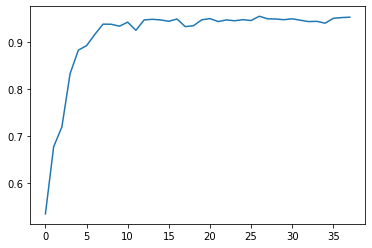

Mean squared error:  1747.9194229267632
Mean absolute error:  26.413738847593773
Root mean squared error:  41.808126278592816
R2 score:  0.9483060830020572
R2 adjusted score:  0.9482663896949177
      y      y_pred
0    16   11.147352
1    40   79.400042
2    32  374.315957
3    13   10.798687
4     1    4.571002
5     1   11.538496
6     2  384.503220
7     3  170.362582
8     8   24.234270
9    14    6.747164
10   36   76.609995
11   56   68.583857
12   84    3.847225
13   94  404.690417
14  106  417.725169
15  110   27.204655
16   93   30.663591
17   67    2.188136
18   35   40.918445
19   37   10.040214


In [20]:
#pokusaj neuralne mreze na hour datasetu jer ima mnogo vise uzoraka
#MLPRegressor u ovom slucaju daje dosta bolje rezultate
#uocava se da sto veci broj postavimo za velicinu skrivenih slojeva to ce bolji rezultat dati
#takodje, porastom broja neurona poboljsavaju se performanse
#kriva nam govori da relativno brzo mreza stigne do r2 skora nesto vise od 0.9 i tu stagnira pa to uzima za konacnu vrednost


scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

regressor_mlp = MLPRegressor(hidden_layer_sizes=(300,300,300,300), activation='relu',
                              solver='adam', batch_size=50, learning_rate='adaptive', 
                              learning_rate_init=0.001, max_iter=100, shuffle=True,
                              random_state=42, early_stopping=True, n_iter_no_change=10,
                              validation_fraction=0.1, verbose=False)
regressor_mlp.fit(X_train_std, Y_train)


Y_pred = regressor_mlp.predict(X_test_std)

plt.figure
plt.plot(regressor_mlp.validation_scores_)
#plt.plot(classifier.loss_curve_)
plt.show()

model_evaluation(Y_test, Y_pred, X_train_std.shape[0], X_train_std.shape[1])

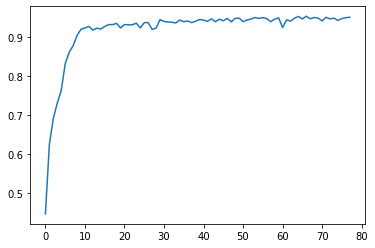

mse = 1432.780403403242
mae = 23.57388575403347
rmse = 37.85208585274056
r2 score = 0.9548008650123251
r2 adjusted = 0.9547487822756386





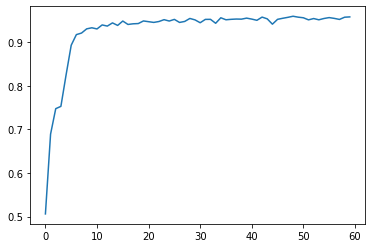

mse = 1671.4974548032517
mae = 25.34297223850463
rmse = 40.883951066442336
r2 score = 0.948462889419954
r2 adjusted = 0.9484035034657615





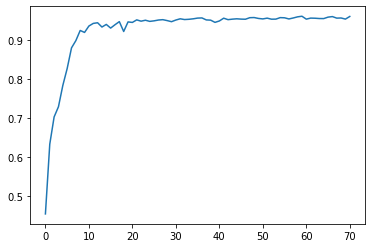

mse = 1717.9319070260153
mae = 25.747721781348986
rmse = 41.4479421325838
r2 score = 0.9489733072402836
r2 adjusted = 0.9489145150834793



prosek mse = 1607.403255077503
prosek mae = 24.88819325796236
prosek rmse = 40.0613263505889
prosek r2 = 0.9507456872241876
prosek r2 adjusted = 0.9506889336082932


In [250]:
#probati 300 300 300 300 za hidden layers

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

kf = KFold(n_splits=3, shuffle=True, random_state=42)
indexes = kf.split(X_train, Y_train)
for train_index, test_index in indexes:
    
    
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    regressor = MLPRegressor(hidden_layer_sizes=(300,300,300,300), activation='relu',
                              solver='adam', batch_size=50, learning_rate='adaptive', 
                              learning_rate_init=0.001, max_iter=100, shuffle=True,
                              random_state=42, early_stopping=True, n_iter_no_change=10,
                              validation_fraction=0.1, verbose=False)
    regressor.fit(X_train, Y_train)
    Y_pred = regressor.predict(X_test)
    #y_pred_p = classifier.predict_proba(X.iloc[test_index,:])
    plt.figure
    plt.plot(regressor.validation_scores_)
    #plt.plot(classifier.loss_curve_)
    plt.show()
    
    
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj

print("prosek mse =",mse_acc/3)
print("prosek mae =",mae_acc/3)
print("prosek rmse =",rmse_acc/3)
print("prosek r2 =",r2_acc/3)
print("prosek r2 adjusted =",r2_adj_acc/3)


In [106]:
#pokusaj redukcije obelezja PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(X_train_std)
X_train_r = pca.transform(X_train_std)
X_test_r = pca.transform(X_test_std)
print('Redukovani prostor ima dimenziju: ', pca.n_components_)

X_train_std.shape

Redukovani prostor ima dimenziju:  9


(15641, 12)

In [262]:
regressor_mlp_pca = MLPRegressor(hidden_layer_sizes=(300,300,300,300), activation='relu',
                              solver='adam', batch_size=50, learning_rate='adaptive', 
                              learning_rate_init=0.001, max_iter=50, shuffle=True,
                              random_state=42, early_stopping=True, n_iter_no_change=10,
                              validation_fraction=0.1, verbose=False)
regressor_mlp_pca.fit(X_train_r,Y_train)
y_predicted_pca = regressor_mlp_pca.predict(X_test_r)
model_evaluation(Y_test, y_predicted_pca, X_train.shape[0], X_train.shape[1])

Mean squared error:  2920.945429948335
Mean absolute error:  33.350384670728424
Root mean squared error:  54.04577161951095
R2 score:  0.9136143756796069
R2 adjusted score:  0.9135480442557622
      y      y_pred
0    16   14.298597
1    40   55.377260
2    32  380.857948
3    13   31.934452
4     1    8.482923
5     1   25.104403
6     2  420.022071
7     3  185.261614
8     8   34.052871
9    14    5.340000
10   36   80.011908
11   56  111.457212
12   84    6.797263
13   94  425.494146
14  106  369.602504
15  110   45.729169
16   93   18.649034
17   67    4.643738
18   35   40.537026
19   37   14.066399


In [ ]:
from sklearn.model_selection import GridSearchCV

check_parameters = {
    'hidden_layer_sizes': [(50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPRegressor()
clf=GridSearchCV(mlp, check_parameters)
clf.fit(X_train, Y_train)

print(clf.best_score_)
print(clf.best_params_)

#uoceno je da povecanjem broja skrivenih slojeva i broja neurona rastu performanse pa su zbog spore obuke u GRIDSEARCHCV
#neki parametri rucno isprobavani

0.9483060830020572

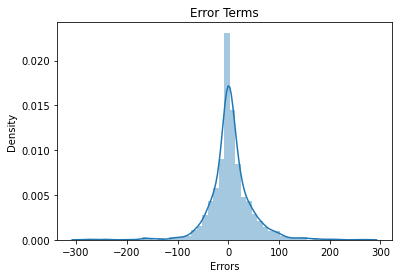

In [21]:
plot_res_dist(Y_test, Y_pred)
r2_score(Y_test,Y_pred)

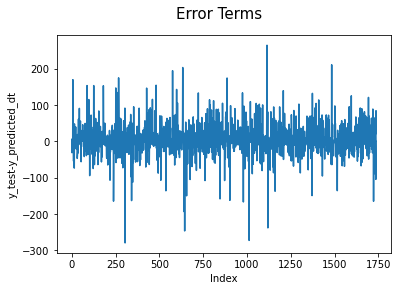

In [40]:
c = [i for i in range(0,len(X_test),1)]
plt.plot(c,Y_test-Y_pred)
plt.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('y_test-y_predicted_dt')
plt.show()

Text(0, 0.5, 'predvidjene vrednosti')

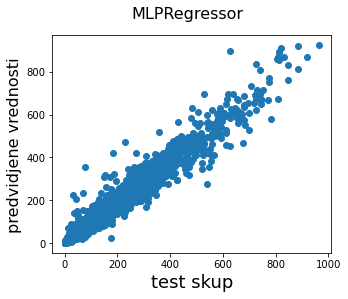

In [39]:
fig = plt.figure(figsize=(5,4))
plt.scatter(Y_test, Y_pred)
fig.suptitle('MLPRegressor', fontsize = 16)              
plt.xlabel('test skup', fontsize = 18)                          
plt.ylabel('predvidjene vrednosti', fontsize = 16)

In [37]:
def plot_act_pred(act,pred,scale,dataname):
    c = [i for i in range(1,scale,1)]
    fig = plt.figure(figsize=(7,4))
    plt.plot(c,act, color="blue", linewidth=2.5, linestyle="-")
    plt.plot(c,pred, color="red",  linewidth=2.5, linestyle="-")
    fig.suptitle('Prave i predvidjene vrednosti - '+dataname, fontsize=20)
    plt.legend(['prave','predvidjene'])
    

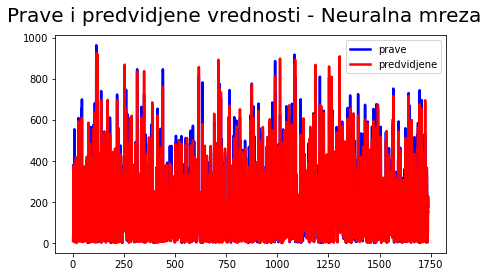

In [38]:
#fig = plt.figure(figsize=(8,4))
plot_act_pred(Y_test,Y_pred,len(Y_pred)+1,'Neuralna mreza')

# Ponovicemo iste algoritme na hour datasetu

In [64]:
hour = pd.read_csv('hour.csv')

hour.drop("instant", axis=1, inplace=True)

hour.drop("dteday", axis=1, inplace=True)
hour.drop("casual", axis=1, inplace=True)
hour.drop("registered", axis=1, inplace=True)
hour

season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0           1   0     1   0        0        6           0           1  0.24   
1           1   0     1   1        0        6           0           1  0.22   
2           1   0     1   2        0        6           0           1  0.22   
3           1   0     1   3        0        6           0           1  0.24   
4           1   0     1   4        0        6           0           1  0.24   
...       ...  ..   ...  ..      ...      ...         ...         ...   ...   
17374       1   1    12  19        0        1           1           2  0.26   
17375       1   1    12  20        0        1           1           2  0.26   
17376       1   1    12  21        0        1           1           1  0.26   
17377       1   1    12  22        0        1           1           1  0.26   
17378       1   1    12  23        0        1           1           1  0.26   

        atemp   hum  windspeed  cnt  
0      0.2879  0.81     0.0000   16  
1      0.2727  0.80     0.0000   40  
2      0.2727  0.80     0.0000   32  
3      0.2879  0.75     0.0000   13  
4      0.2879  0.75     0.0000    1  
...       ...   ...        ...  ...  
17374  0.2576  0.60     0.1642  119  
17375  0.2576  0.60     0.1642   89  
17376  0.2576  0.60     0.1642   90  
17377  0.2727  0.56     0.1343   61  
17378  0.2727  0.65     0.1343   49  

[17379 rows x 13 columns]

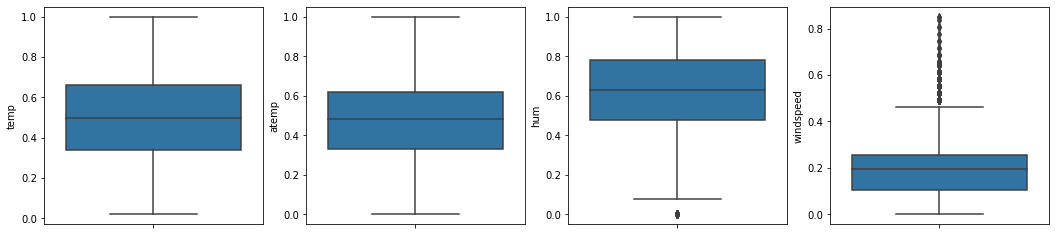

In [42]:
#crtanje boxplotova za kontinualne promenljive

cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=hour)
    i+=1
    
#primecujemo da u hour datasetu takodje postoje outlieri za obelezje windspeed i da ih ima dosta vise nego na day
#datasetu, sto je i logicno jer sam hour data set sadrzi mnogo vise uzoraka

<Figure size 1080x2160 with 0 Axes>

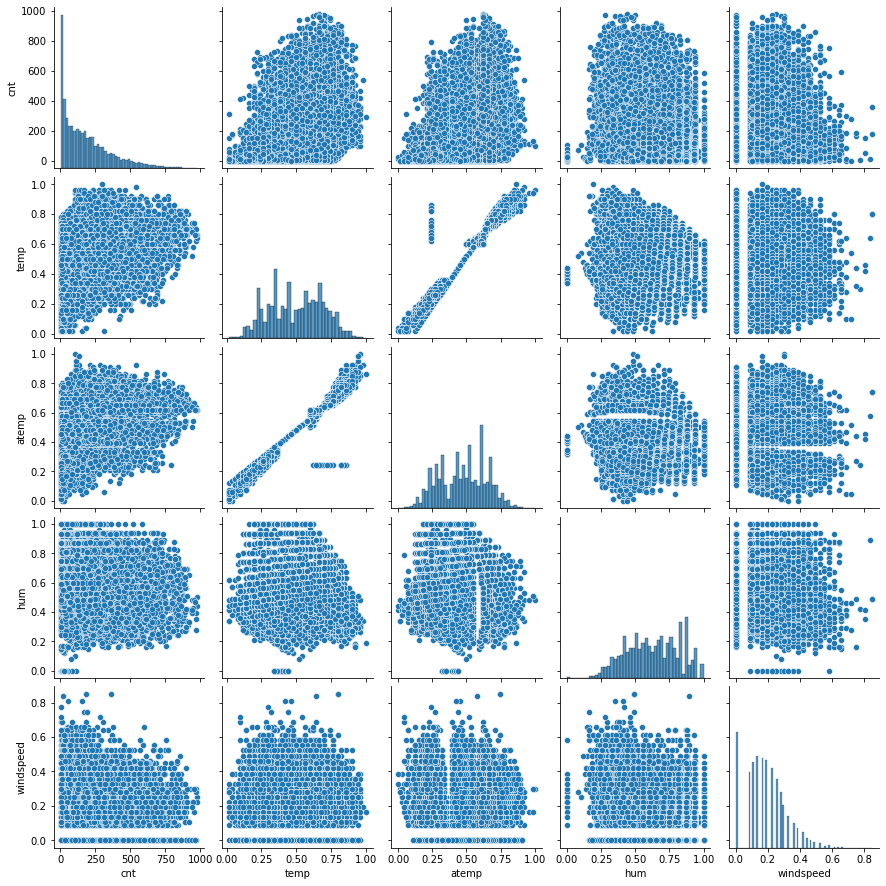

In [43]:
#veza izmedju numerickih obelezja

plt.figure(figsize = (15,30))
sns.pairplot(data=hour,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

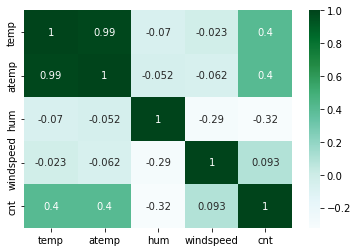

In [44]:
# heatmapa nekih numerickih obelezja
sns.heatmap(hour[['temp','atemp','hum','windspeed','cnt']].corr(), cmap='BuGn', annot = True)
plt.show()

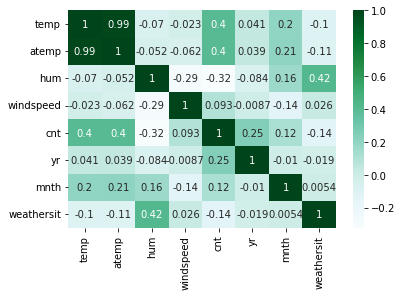

In [45]:
# heatmapa 
sns.heatmap(hour[['temp','atemp','hum','windspeed','cnt','yr','mnth','weathersit']].corr(), cmap='BuGn', annot = True)
plt.show()

Slicno kao i u day datasetu potraznja je veca tokom letnjih i jesenjih meseci, i moze se primetiti porast u 2012 godini, potraznja je najveca kad je vreme najbolje ocenjeno i nebitno je da li je radni dan ili vikend,praznik ili ne, koji je dan u nedelji.

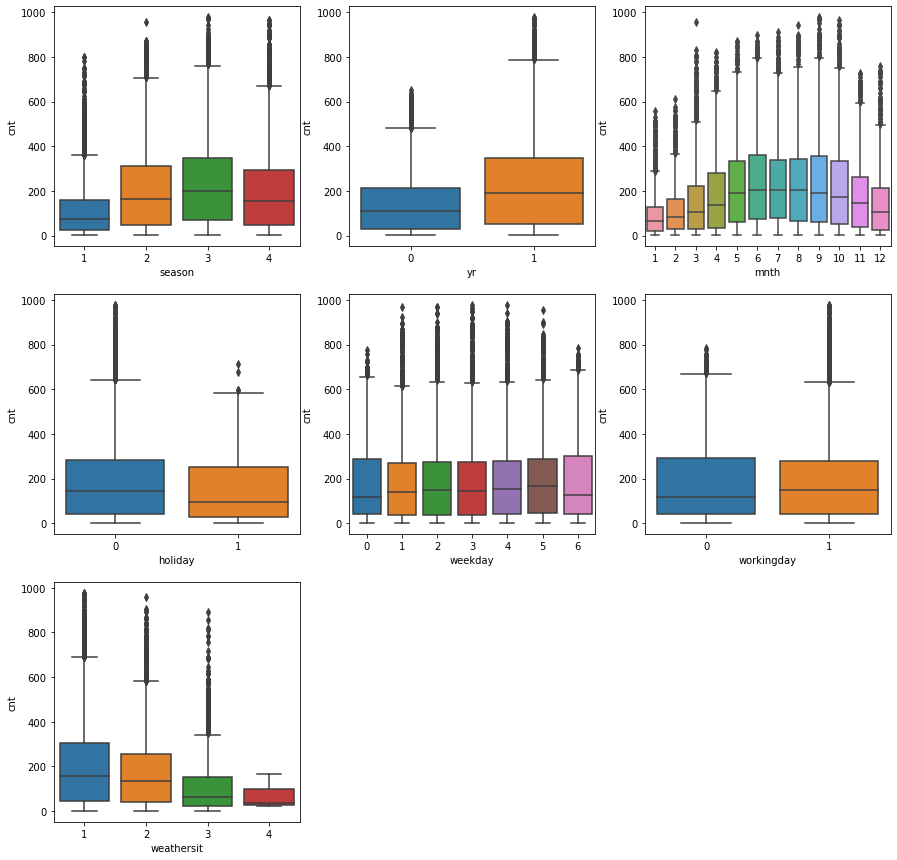

In [47]:
#boxplotovi posebno za kategoricke promenljive


vars_cat = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
plt.figure(figsize=(15, 15))
for i in enumerate(vars_cat):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data=hour, x=i[1], y='cnt')
plt.show()


In [49]:
#Prosecna iznajmljenost bicikala od APRILA-OKTOBRA I NOVEMBRA-MARTA
april_septembar = hour.loc[
               (hour["mnth"] >= 4) & (hour["mnth"] <= 9), 
                        :]

oktobar_mart = hour.loc[
               (hour["mnth"] < 4) | (hour["mnth"] > 10),
                      :]

print("APRIL  -  SEPTEMBAR")

working_day = april_septembar.loc[
              april_septembar["workingday"] == 1,
                              :]
print("Prosecno preuzimanje tokom RADNIH DANA",working_day.cnt.mean())

weekend = april_septembar.loc[
                     (april_septembar["weekday"] == 0) |
                     (april_septembar["weekday"] == 6),
                          :]

print("Prosecno preuzimanje tokom VIKENDA", weekend.cnt.mean())

holiday = april_septembar.loc[
                         (april_septembar["holiday"] == 1),
                          :]

print("Prosecno preuzimanje tokom PRAZNIKA",holiday.cnt.mean())
print("\n")

print("OKTOBAR  -  MART")

working_day = oktobar_mart.loc[
              oktobar_mart["workingday"] == 1,
                              :]
print("Prosecno preuzimanje tokom RADNIH DANA",working_day.cnt.mean())

weekend = oktobar_mart.loc[
                     (oktobar_mart["weekday"] == 0) |
                     (oktobar_mart["weekday"] == 6),
                          :]

print("Prosecno preuzimanje tokom VIKENDA", weekend.cnt.mean())

holiday = oktobar_mart.loc[
                         (oktobar_mart["holiday"] == 1),
                          :]

print("Prosecno preuzimanje tokom PRAZNIKA",holiday.cnt.mean())
print("\n")

APRIL  -  SEPTEMBAR
Prosecno preuzimanje tokom RADNIH DANA 226.54648862512363
Prosecno preuzimanje tokom VIKENDA 228.38292780215397
Prosecno preuzimanje tokom PRAZNIKA 221.1875


OKTOBAR  -  MART
Prosecno preuzimanje tokom RADNIH DANA 144.58202154101076
Prosecno preuzimanje tokom VIKENDA 124.17253012048192
Prosecno preuzimanje tokom PRAZNIKA 97.58461538461539




Text(0.5, 1.0, 'Praznici')

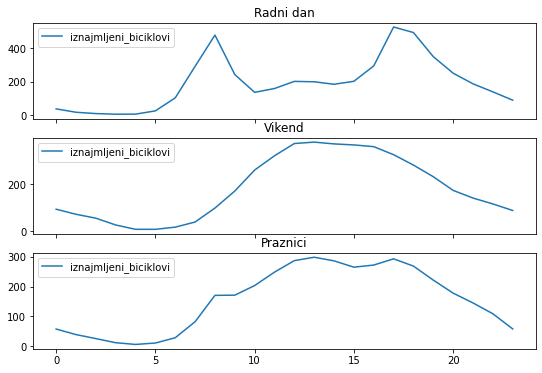

In [55]:
import seaborn as sb
from scipy.stats import norm

radni_dan = hour[hour["workingday"] == 1]

vikend = hour[ (hour["weekday"] == 0) | (hour["weekday"] == 6)]

praznik = hour[hour["holiday"] == 1]

work_day = hour[
                 hour["workingday"] == 1
               ].groupby("hr").aggregate({
                            
                            "cnt": "mean"
                                         })
                  
weekend = hour[
                (hour["weekday"] == 0) | (hour["weekday"] == 6)
              ].groupby("hr").aggregate({
                                
                                "cnt" : "mean"
                                        })
                 
holiday =    hour[
                   hour["holiday"] == 1
                 ].groupby("hr").aggregate({
                                     
                                     "cnt": "mean"
                                           })

work_day_count = radni_dan.cnt
weekend_count =  vikend.cnt
holiday_count = praznik.cnt

               
fig, ax = plt.subplots(3, 1, figsize = (9,6), sharex="all")

  
# Za radne dane

ax[0].plot(work_day.cnt, label = "iznajmljeni_biciklovi")

ax[0].legend(loc = "best")
ax[0].set_title("Radni dan")

# Za vikende

ax[1].plot(weekend.cnt, label = "iznajmljeni_biciklovi")

ax[1].legend(loc = "best")
ax[1].set_title("Vikend")

# Za praznike

ax[2].plot(holiday.cnt, label = "iznajmljeni_biciklovi")


ax[2].legend(loc  = "best")
ax[2].set_title("Praznici")

Text(0.5, 1.0, 'Vlaznost vazduha od 18-24')

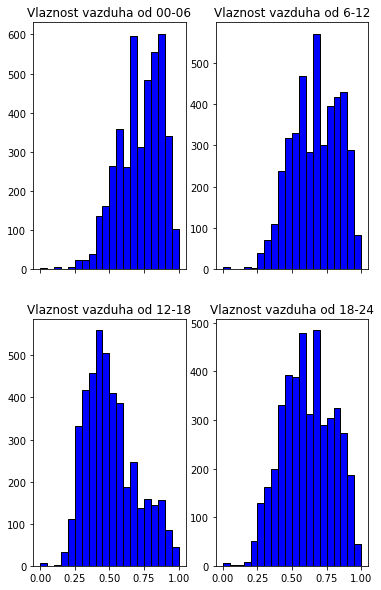

In [56]:
fig, ax = plt.subplots(2,2, figsize = (6,10), sharex = "all")



period1 = hour[
            (hour["hr"] < 6)
              ]




period2 = hour[
            (hour["hr"] >= 6) & (hour["hr"] < 12)
              ]

period3 = hour[
            (hour["hr"] >= 12) & (hour["hr"] < 18)
              ]

period4 = hour[
            (hour["hr"] >= 18)
              ] 

ax[0,0].hist(period1.hum, bins = 20, color = "blue", 
                                  edgecolor = "black")

ax[0,0].set_title("Vlaznost vazduha od 00-06")

ax[0,1].hist(period2.hum, bins = 20, color = "blue", 
                                  edgecolor = "black")

ax[0,1].set_title("Vlaznost vazduha od 6-12")

ax[1,0].hist(period3.hum, bins = 20, color = "blue", 
                                  edgecolor = "black")

ax[1,0].set_title("Vlaznost vazduha od 12-18")

ax[1,1].hist(period4.hum, bins = 20, color = "blue", 
                                  edgecolor = "black")

ax[1,1].set_title("Vlaznost vazduha od 18-24")

# Priprema podataka za regresiju

In [65]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')


y=hour.pop('cnt')

X=hour

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=46)


In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [67]:
#skaliranje obelezja

scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)
x_train_std = pd.DataFrame(x_train_std)
x_test_std = pd.DataFrame(x_test_std)
x_train_std.columns = list(X.columns)
x_test_std.columns = list(X.columns)
x_train_std.head()

season        yr      mnth        hr   holiday   weekday  workingday  \
0 -1.357385  0.996108 -1.320792 -1.235354 -0.172113  0.496815    0.683061   
1 -1.357385  0.996108 -1.320792 -1.524494 -0.172113 -0.001785    0.683061   
2  1.352015  0.996108  1.296675  1.656040 -0.172113 -1.497586   -1.463997   
3  1.352015  0.996108  1.296675  0.499482 -0.172113 -0.001785    0.683061   
4 -1.357385  0.996108 -1.320792 -0.512506 -0.172113  1.494015   -1.463997   

   weathersit      temp     atemp       hum  windspeed  
0   -0.662583 -1.438419 -1.531988  0.900679   0.755598  
1   -0.662583 -0.918933 -0.827277 -0.709561  -0.705429  
2   -0.662583 -0.399447 -0.298743  0.433190   0.024676  
3    0.906924 -0.918933 -1.003455 -0.501788   0.877146  
4    2.476431 -1.438419 -1.443609  1.575941  -0.462333

Mean squared error:  21146.123488254456
Mean absolute error:  108.15032115482624
Root mean squared error:  145.41706738981657
R2 score:  0.3746130753557765
R2 adjusted score:  0.3741328703970018
      y      y_pred
0    16  -37.342974
1    40   42.545288
2    32  352.943579
3    13  202.615339
4     1   99.983615
5     1  230.220787
6     2  242.691845
7     3  217.369082
8     8  124.163603
9    14  -54.710466
10   36  142.805228
11   56   -5.143362
12   84   12.092413
13   94  328.341674
14  106  302.480785
15  110  119.405670
16   93  159.040018
17   67    7.387141
18   35  196.334942
19   37  199.248352


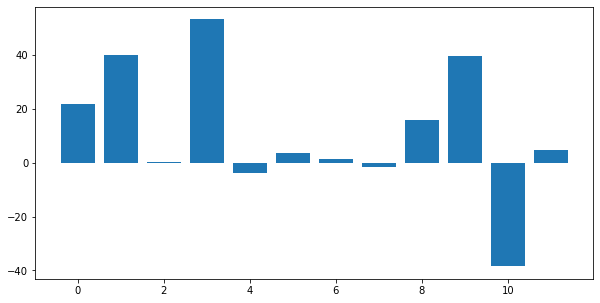

koeficijenti:  [ 22.01583485  39.99560074   0.12934484  53.29431939  -3.89584745
   3.51804134   1.28352609  -1.5216014   15.99719945  39.64345957
 -38.50278482   4.75813133]


In [68]:
#osnovni model linearne regresije


first_regression_model = LinearRegression(fit_intercept=True)

# Obuka
first_regression_model.fit(x_train_std, y_train)

# Testiranje
y_predicted = first_regression_model.predict(x_test_std)

# Evaluacija
model_evaluation(y_test, y_predicted, x_train_std.shape[0], x_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(first_regression_model.coef_)),first_regression_model.coef_)
plt.show()
print("koeficijenti: ", first_regression_model.coef_)

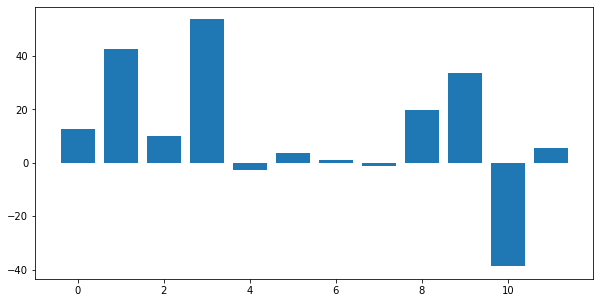

koeficijenti:  [ 12.71993517  42.74719497  10.0574882   53.67675742  -2.80444501
   3.77065709   0.99981247  -1.33038154  19.64229557  33.40791448
 -38.82807865   5.44995106]
mse = 19141.612317513962
mae = 103.52632596582431
rmse = 138.35321578306
r2 score = 0.3864804733500169





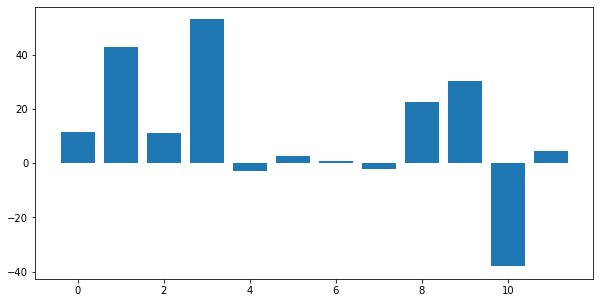

koeficijenti:  [ 11.3579091   42.63662262  11.16966243  52.96371663  -2.82105213
   2.78793913   0.59554871  -2.1813099   22.53663284  30.28189317
 -38.07833127   4.55578296]
mse = 19263.711317808687
mae = 103.83178021792571
rmse = 138.79377261897844
r2 score = 0.4026701028274424





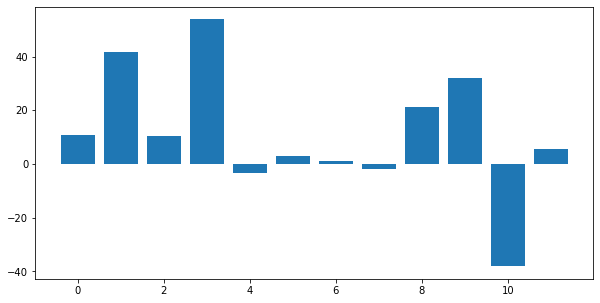

koeficijenti:  [ 10.81946631  41.58457113  10.54899513  53.87983815  -3.30462345
   3.06587812   1.18069649  -1.81167551  21.28848488  31.89024544
 -38.17293494   5.7134747 ]
mse = 19252.58979789559
mae = 103.70961158202097
rmse = 138.75370192501384
r2 score = 0.4047307763721171





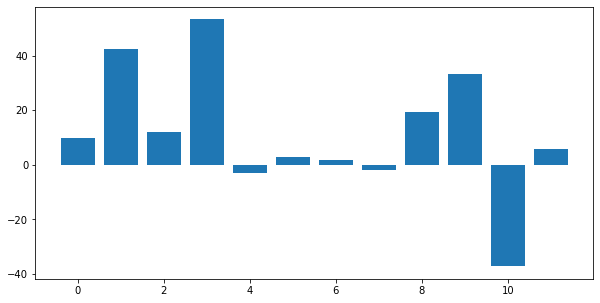

koeficijenti:  [  9.95800767  42.33169495  12.17154896  53.3028635   -2.92336492
   3.01041179   1.91372621  -1.83585103  19.22333314  33.29277706
 -37.23639772   5.87296194]
mse = 20761.28119655677
mae = 107.36630447705927
rmse = 144.0877551929961
r2 score = 0.39986426008883635





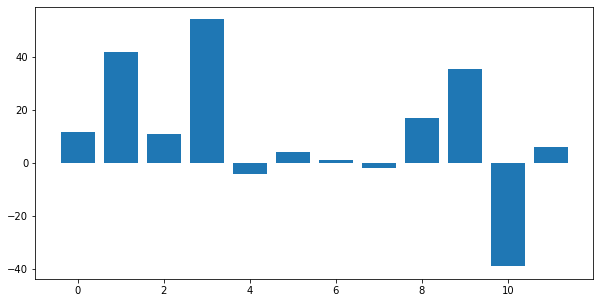

koeficijenti:  [ 11.43859869  41.53744324  10.7921828   54.0170552   -4.39972517
   3.88542846   1.20845331  -2.11719848  16.91438855  35.22307276
 -39.08497802   5.9152995 ]
mse = 19632.35999649808
mae = 104.34379344012557
rmse = 140.11552375271657
r2 score = 0.39724980340505545





In [69]:
#osnovni model linearne regresije kros validacija

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold


kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    
    first_regression_model = LinearRegression(fit_intercept=True)
    # Obuka
    first_regression_model.fit(X_train, Y_train)

    # Testiranje
    Y_pred = first_regression_model.predict(X_test)
    
    # Ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(first_regression_model.coef_)),first_regression_model.coef_)
    plt.show()
    print("koeficijenti: ", first_regression_model.coef_)
    
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("\n\n")

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x8 x9', 'x8 x10', 'x8 x11', 'x9 x10', 'x9 x11', 'x10 x11']
Mean squared error:  19571.653532059885
Mean absolute error:  101.52977469107361
Root mean squared error:  139.8987259844059
R2 score:  0.42117730375424245
R2 adjusted score:  0.4182761232949719
      y      y_pred
0    16   73.263153
1    40  -69.048340
2    32  407.400436
3    13  234.219757
4     1   78.9

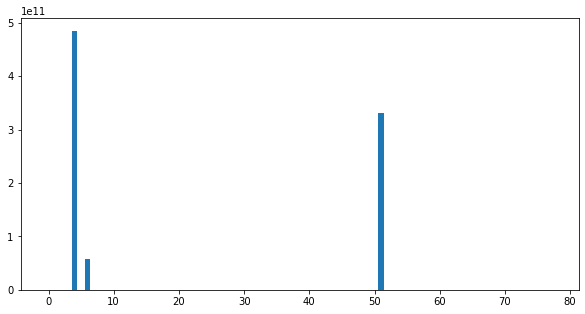

koeficijenti:  [-3.17528843e+00  3.88339061e+01  2.70638642e+01  5.54388230e+01
  4.84815087e+11  2.17911808e+00  5.69966010e+10 -2.01364148e+00
  4.73738804e+01  9.73186493e+00 -3.99159775e+01  5.83580017e+00
 -1.33506775e+00  7.82676506e+00  5.67523193e+00  1.70015717e+00
  2.60107803e+00 -1.91340256e+00  4.23600006e+00 -4.18924675e+01
  2.72055550e+01 -4.19828796e+00  3.29372311e+00  3.89706421e+00
  9.93486595e+00 -7.58041382e-01  3.32081103e+00  3.97040749e+00
  8.32431793e-01 -1.53602142e+01  2.42794342e+01 -8.24843597e+00
  3.25851440e+00 -2.49026489e+00 -1.37037086e+00 -2.06074333e+00
  3.01744080e+00 -1.04141998e+00  7.04176998e+00  1.57925510e+01
 -8.49979401e+00 -2.78546667e+00 -6.40016556e-01  1.38293839e+00
  8.93567848e+00 -3.44108391e+00  2.73097839e+01 -4.89878845e+00
 -5.86547852e+00  2.52546692e+00 -4.32448387e+00  3.31158481e+11
  7.96512604e-01  4.72918701e+00 -4.83245850e+00  3.35258389e+00
  5.44479370e-01 -5.31845093e-01  2.78873062e+00 -4.67852974e+00
  4.119270

In [131]:
#drugacija hipoteza, samo interakcije

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

print(poly.get_feature_names())

# Linearna regresija sa hipotezom y=b0+b1x1+b2x2+...+bnxn+c1x1x2+c2x1x3+...

# Inicijalizacija
regression_model_inter = LinearRegression()

# Obuka modela
regression_model_inter.fit(x_inter_train, y_train)

# Testiranje
y_predicted = regression_model_inter.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_inter.coef_)),regression_model_inter.coef_)
plt.show()
print("koeficijenti: ", regression_model_inter.coef_)

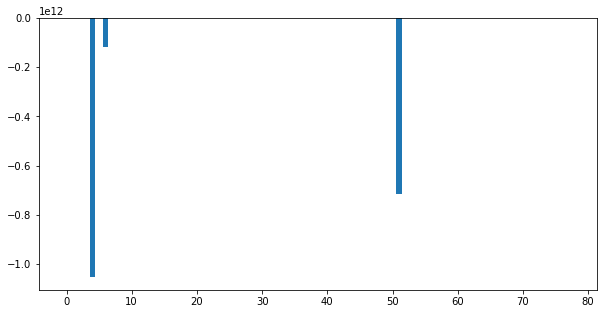

mse = 17469.3050850523
mae = 96.24865984040429
rmse = 132.17149876222294
r2 score = 0.4400806155247945





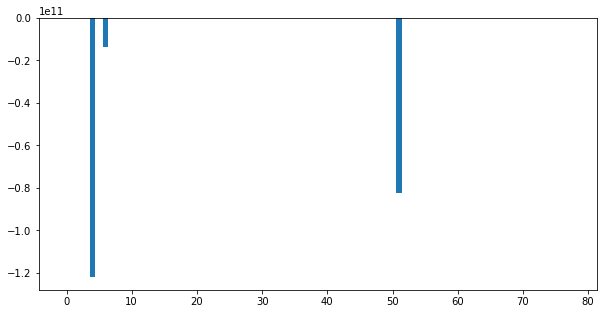

mse = 17013.382194488622
mae = 94.99891676012513
rmse = 130.43535638195888
r2 score = 0.47244839433425745





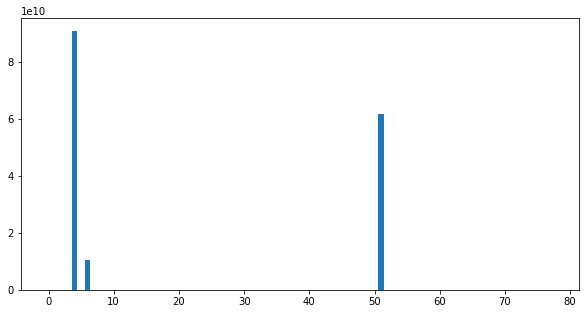

mse = 17335.302839534714
mae = 95.5492854246398
rmse = 131.66359724515624
r2 score = 0.4640112124670105





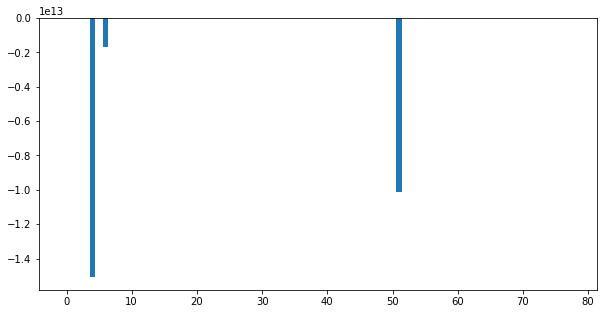

mse = 18645.59593540034
mae = 98.75447507892423
rmse = 136.5488774593198
r2 score = 0.4610212921429967





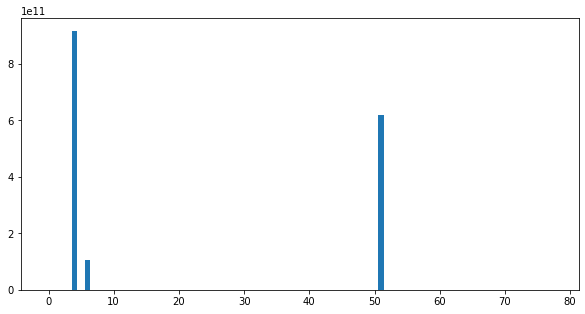

mse = 18136.15583422759
mae = 97.14796306288152
rmse = 134.67054553326645
r2 score = 0.4431860715417225





In [70]:
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold


kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)

    x_inter_train.shape
    #print(poly.get_feature_names())
    
        # Inicijalizacija
    regression_model_inter = LinearRegression()

    # Obuka modela
    regression_model_inter.fit(x_inter_train, Y_train)
    
    plt.figure(figsize=(10,5))
    plt.bar(range(len(regression_model_inter.coef_)),regression_model_inter.coef_)
    plt.show()

    # Testiranje
    Y_pred = regression_model_inter.predict(x_inter_test)
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("\n\n")

Mean squared error:  15804.370187915236
Mean absolute error:  94.36462528768699
Root mean squared error:  125.71543337202174
R2 score:  0.5325929845605456
R2 adjusted score:  0.5298877349535005
      y      y_pred
0    16    8.851562
1    40    9.703125
2    32  436.117188
3    13  216.125000
4     1   73.937500
5     1   64.789062
6     2  254.984375
7     3  250.031250
8     8  119.617188
9    14  -75.531250
10   36  160.304688
11   56  -30.359375
12   84   89.343750
13   94  336.937500
14  106  377.257812
15  110    9.390625
16   93  165.585938
17   67   53.515625
18   35  197.179688
19   37  144.234375


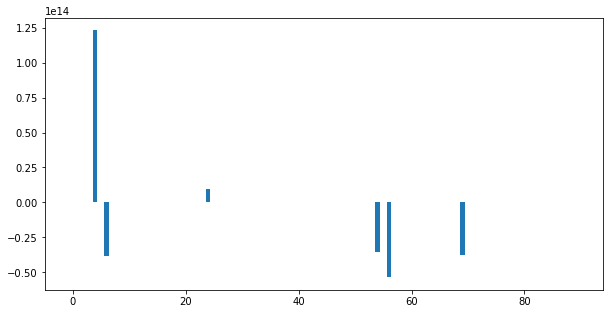

koeficijenti:  [ 6.52119173e+00  7.44669958e+10  1.49591259e+01  6.32863935e+01
  1.23015325e+14  2.94266946e+00 -3.85388388e+13 -3.04612230e+00
  5.99841565e+01 -1.50898438e+01 -2.49804688e+01 -1.14941406e+00
  7.40234375e-01  9.14062500e-01  8.86718750e-01  5.81591797e+00
  7.50000000e-01  1.29101562e+00 -2.29296875e+00 -7.63671875e-01
 -7.09765625e+00 -6.37500000e+00 -7.36328125e-01  2.74609375e+00
  9.54696248e+12  2.14062500e+00  9.78808594e+00 -1.65820312e+00
  2.87988281e+00  3.80566406e+00  1.72851562e+00 -2.21855469e+01
  3.15507812e+01 -9.17675781e+00  3.58007812e+00 -4.10156250e+00
 -1.04785156e+00 -1.24218750e+00 -7.51953125e-01  3.24023438e+00
 -3.51562500e-02 -6.24218750e+00  2.47187500e+01 -4.70117188e+00
 -1.86718750e+00 -6.71948242e+01 -6.78710938e-02  1.00292969e+00
  9.30200195e+00 -2.88134766e+00  2.84960938e+01 -2.46875000e+00
 -1.18574219e+01  2.18164062e+00 -3.57332571e+13 -3.30371094e+00
 -5.35861058e+13  1.97033691e+00  2.33105469e+00 -2.34277344e+00
  4.570312

In [71]:
#hipoteza interakcije i kvadrata

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

# Linearna regresija sa hipotezom y=b0+b1x1+b2x2+...+bnxn+c1x1x2+c2x1x3+...+d1x1^2+d2x2^2+...+dnxn^2

# Inicijalizacija
regression_model_degree = LinearRegression()

# Obuka modela
regression_model_degree.fit(x_inter_train, y_train)

# Testiranje
y_predicted = regression_model_degree.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_degree.coef_)),regression_model_degree.coef_)
plt.show()
print("koeficijenti: ", regression_model_degree.coef_)

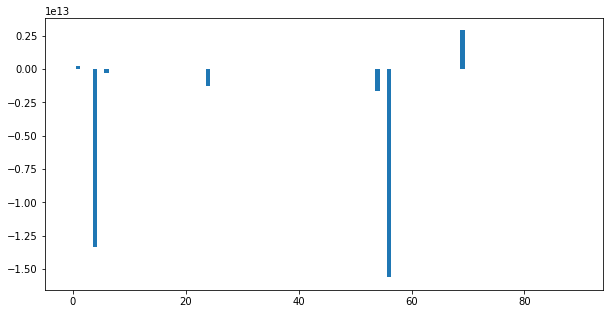

mse = 14375.919612045675
mae = 90.6524000841423
rmse = 119.89962306882234
r2 score = 0.5392286057601042





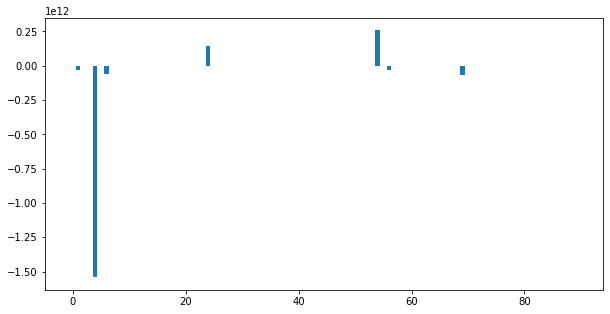

mse = 14248.0519303379
mae = 90.30453089253066
rmse = 119.3652040183315
r2 score = 0.5581958609092088





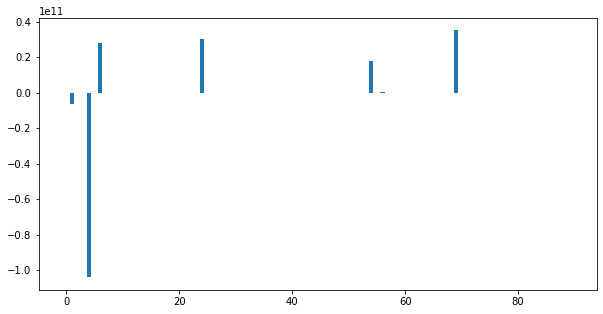

mse = 14287.31261318796
mae = 89.76264242382001
rmse = 119.52954702996226
r2 score = 0.5582517689172979





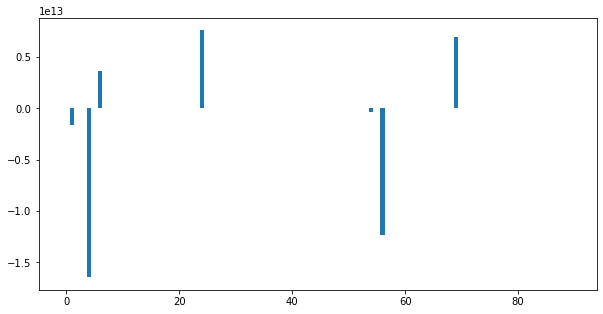

mse = 15446.045214105445
mae = 93.20472284107257
rmse = 124.2821194464652
r2 score = 0.5535090688523678





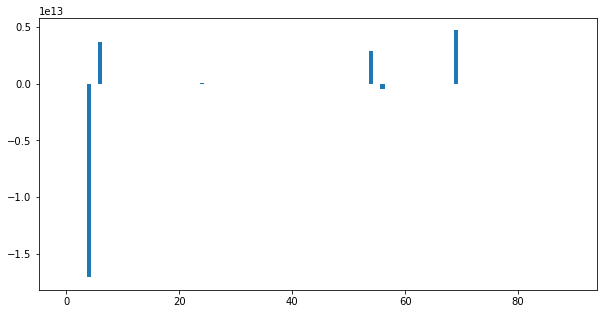

mse = 14615.914438737018
mae = 89.47620503067056
rmse = 120.89629621595948
r2 score = 0.5512640710064881





In [72]:
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold


kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)

    #print(poly.get_feature_names())
    
        # Inicijalizacija
    regression_model_degree = LinearRegression()

    # Obuka modela
    regression_model_degree.fit(x_inter_train, Y_train)
    
    # Ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(regression_model_degree.coef_)),regression_model_degree.coef_)
    plt.show()

    # Testiranje
    Y_pred = regression_model_degree.predict(x_inter_test)
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("\n\n")

Mean squared error:  15778.614463323347
Mean absolute error:  94.3119595861052
Root mean squared error:  125.61295499797522
R2 score:  0.5333546983282464
R2 adjusted score:  0.5306538573539404
      y      y_pred
0    16   17.587625
1    40    1.383352
2    32  435.275681
3    13  219.902738
4     1   75.357263
5     1   65.528808
6     2  255.980945
7     3  249.718259
8     8  121.257454
9    14  -73.638306
10   36  164.894116
11   56  -33.436174
12   84   90.494156
13   94  334.259019
14  106  373.296193
15  110   17.556022
16   93  163.835196
17   67   54.706089
18   35  196.148081
19   37  151.027397
vreme trajanja je:  0.21787762641906738  sekundi.


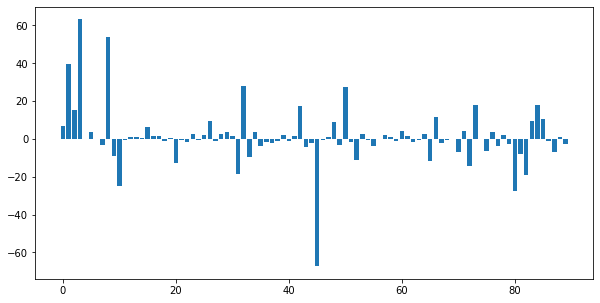

koeficijenti:  [  6.63618116  39.71147905  15.13423117  63.24034405  -0.12577956
   3.46985424  -0.18235042  -3.06851826  53.9610457   -9.11600251
 -25.05628358  -0.69732479   1.02139962   1.09357703   0.52424429
   6.58140808   1.70973204   1.62387475  -1.30567746   0.42821318
 -12.81935021  -0.49839429  -1.37592975   2.74874105  -0.3097524
   1.88930988   9.74107235  -0.92488148   2.68750684   3.66093606
   1.82832598 -18.40062238  27.90499437  -9.35189583   3.80718903
  -3.78315044  -1.82390734  -1.89728785  -1.09870966   2.02894912
  -1.02286384   1.67201138  17.34165285  -4.02019454  -2.38248253
 -67.40223345  -0.48869382   1.0848882    9.19066522  -2.98975014
  27.2756663   -1.53379292 -11.27317887   2.58495218  -0.70914915
  -3.50717307   0.21552576   2.03221894   0.93848925  -0.92203518
   4.09727826   1.44068464  -1.74832174  -0.30113674   2.63321603
 -11.51439867  11.67097415  -2.01855103  -0.48249309   0.14240396
  -7.09907669   4.19793828 -14.42285878  18.13498369   0.23624

In [93]:
#ridge regresija
from sklearn.linear_model import RidgeCV



#ovde odredjujemo koje je alpha najbolje za ridge regresiju
regr_cv = RidgeCV(alphas=[0.1, 1.0, 5.0, 10.0 ,11.0,12.0,13.0,14.0, 15.0,16.0,17.0,18.0,19.0, 20.0,30.0,40.0,50.0,60.0,80.0,100.0,110.0,200.0,500.0,1000.0])
model_cv = regr_cv.fit(x_train_std, y_train)
model_cv.alpha_

import time
start = time.time()

x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

#Inicijalizacija
ridge_model = Ridge(alpha=15)

# Obuka modela
ridge_model.fit(x_inter_train, y_train)

# Testiranje
y_predicted = ridge_model.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
plt.show()
print("koeficijenti: ", ridge_model.coef_)

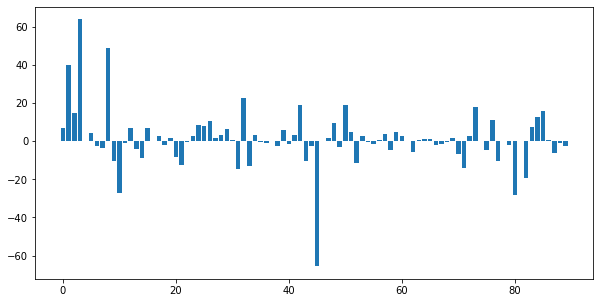

koeficijenti:  [ 6.79185559e+00  4.01612297e+01  1.50236802e+01  6.39089867e+01
 -7.27676296e-02  4.26725261e+00 -2.37016218e+00 -3.38907981e+00
  4.88811662e+01 -1.04877926e+01 -2.70792075e+01 -8.40999584e-01
  7.11516952e+00 -4.13402396e+00 -8.86884404e+00  6.99101690e+00
  3.03125936e-01  2.50068698e+00 -2.06273500e+00  1.61171956e+00
 -8.29902614e+00 -1.23699947e+01 -2.73960994e-01  2.60860165e+00
  8.32569629e+00  8.16234994e+00  1.03738877e+01  1.64870445e+00
  3.31274112e+00  6.37576401e+00  6.62449091e-01 -1.48049343e+01
  2.27563857e+01 -1.32537163e+01  3.31759373e+00 -6.26804175e-01
 -1.08890525e+00  2.41951923e-01 -2.28230578e+00  5.68332156e+00
 -1.69525811e+00  3.05697255e+00  1.90190526e+01 -1.03361363e+01
 -2.50010331e+00 -6.57173155e+01 -1.94883552e-02  1.78030389e+00
  9.45799664e+00 -3.09464956e+00  1.89382019e+01  4.72511880e+00
 -1.13877009e+01  2.46275867e+00 -4.22554423e-01 -1.49820484e+00
  5.04020072e-01  3.67126345e+00 -4.65542611e+00  4.67056398e+00
  2.738852

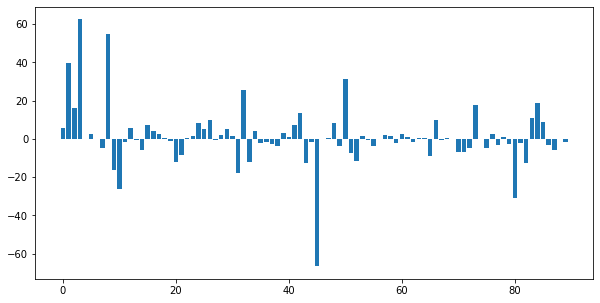

koeficijenti:  [ 5.83093466e+00  3.95072128e+01  1.60795895e+01  6.25135391e+01
 -1.11562131e-01  2.81322054e+00  8.89429476e-02 -4.73541397e+00
  5.46254899e+01 -1.61083703e+01 -2.61935876e+01 -1.79414259e+00
  5.87133887e+00 -7.05404973e-01 -5.73579419e+00  7.39262538e+00
  3.93864203e+00  2.35804534e+00  3.72440693e-01 -9.59090287e-01
 -1.21878611e+01 -8.23380237e+00  6.52583764e-01  1.62790218e+00
  8.34991825e+00  4.94788049e+00  9.67314191e+00 -3.52206370e-01
  2.28216200e+00  5.22451743e+00  1.64845781e+00 -1.80312547e+01
  2.54941529e+01 -1.20510789e+01  3.91966513e+00 -1.90255254e+00
 -1.39797772e+00 -2.39837747e+00 -3.56316340e+00  3.05314527e+00
  9.22548988e-01  7.15081127e+00  1.36836167e+01 -1.27634295e+01
 -1.51679499e+00 -6.66589766e+01 -1.58987788e-01  3.61289214e-01
  8.53031423e+00 -3.94477062e+00  3.15662110e+01 -7.47324875e+00
 -1.17387703e+01  1.68292060e+00 -6.46827761e-01 -3.65885865e+00
  1.49868270e-01  2.29023592e+00  1.39712511e+00 -2.18779350e+00
  2.620245

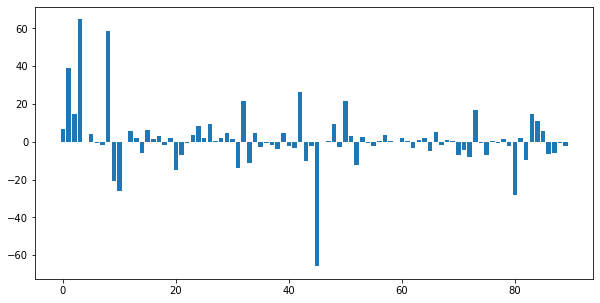

koeficijenti:  [ 6.55711644e+00  3.91735491e+01  1.47850302e+01  6.47402383e+01
 -7.41292177e-02  4.32849459e+00 -8.18740009e-01 -1.92644395e+00
  5.86419168e+01 -2.06205855e+01 -2.59979088e+01 -6.39381531e-02
  5.92818737e+00  2.10561536e+00 -5.95208828e+00  6.11810169e+00
  1.73051852e+00  3.24435552e+00 -1.57546602e+00  2.13623017e+00
 -1.50233474e+01 -7.11437061e+00 -5.75946866e-01  3.76127152e+00
  8.11392506e+00  2.09307886e+00  9.38233883e+00  4.04545730e-01
  2.01741662e+00  4.78644669e+00  1.26610858e+00 -1.36315673e+01
  2.14309678e+01 -1.14352098e+01  4.67184867e+00 -2.88897973e+00
 -6.02668148e-01 -1.57158600e+00 -3.81271361e+00  4.80507171e+00
 -2.29121180e+00 -3.40882777e+00  2.62460622e+01 -1.00665649e+01
 -2.12734357e+00 -6.59025227e+01  3.78453419e-02  3.67314600e-01
  9.28783996e+00 -2.84197660e+00  2.15481306e+01  3.04766906e+00
 -1.23184518e+01  2.64945805e+00 -4.29794907e-01 -2.09602937e+00
  2.46087705e-01  3.84860887e+00  4.90963665e-01  4.73925622e-02
  2.138437

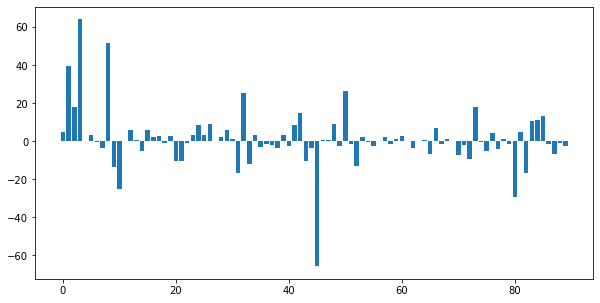

koeficijenti:  [ 4.64488418e+00  3.94065899e+01  1.80295894e+01  6.41802846e+01
 -7.29475975e-02  3.24833813e+00 -4.69424542e-01 -3.63479336e+00
  5.20008681e+01 -1.37226029e+01 -2.52787377e+01  1.90820109e-02
  5.72567555e+00  8.65397168e-01 -5.15062581e+00  5.86525344e+00
  2.13989569e+00  2.90068363e+00 -7.26592518e-01  2.91876890e+00
 -1.05305425e+01 -1.05340875e+01 -9.16834841e-01  3.46128170e+00
  8.50803640e+00  3.25811791e+00  9.27228190e+00  5.87938394e-02
  2.31321999e+00  5.73792467e+00  1.25762376e+00 -1.68532542e+01
  2.55227511e+01 -1.20331975e+01  3.36971106e+00 -2.72375448e+00
 -1.17903817e+00 -2.01693371e+00 -3.31108841e+00  3.27102404e+00
 -2.55656516e+00  8.46710343e+00  1.51186924e+01 -1.03110051e+01
 -3.55289785e+00 -6.58376923e+01  6.68072726e-01  6.09314445e-01
  9.22749956e+00 -2.64409968e+00  2.64164486e+01 -1.24613197e+00
 -1.31105200e+01  2.29689048e+00 -4.26342614e-01 -2.29061176e+00
  1.86765629e-01  2.49155766e+00 -1.18734738e+00  1.04112872e+00
  2.549146

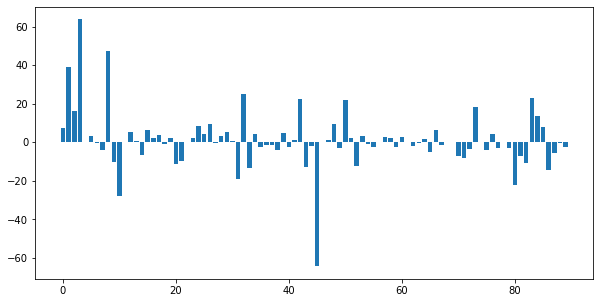

koeficijenti:  [ 7.40220779e+00  3.90737454e+01  1.63384322e+01  6.37585663e+01
 -1.19215734e-01  3.37083428e+00 -3.21549155e-01 -3.96300263e+00
  4.73378993e+01 -1.01869499e+01 -2.79999390e+01  6.01712728e-02
  5.36033104e+00  4.40604194e-01 -6.82267281e+00  6.40990457e+00
  2.08886009e+00  3.59882377e+00 -1.12519249e+00  2.15611819e+00
 -1.10541026e+01 -9.90796581e+00  8.35428927e-02  2.32516196e+00
  8.53787190e+00  4.28517191e+00  9.57067443e+00 -2.51312690e-01
  3.48488569e+00  5.12620932e+00  8.44263558e-01 -1.89369107e+01
  2.49795467e+01 -1.32570402e+01  4.42056282e+00 -2.40055556e+00
 -1.56113047e+00 -1.62431898e+00 -3.94528656e+00  4.87717642e+00
 -2.55423041e+00  9.56429118e-01  2.24828715e+01 -1.28201010e+01
 -1.92155606e+00 -6.44591694e+01 -1.38213362e-01  1.29037235e+00
  9.42681197e+00 -2.78116880e+00  2.18185232e+01  2.34755801e+00
 -1.24654722e+01  3.28641663e+00 -6.78342470e-01 -2.32050884e+00
  2.30947708e-01  2.72232261e+00  2.12975935e+00 -2.26428972e+00
  2.861904

In [73]:
#Ridge regresija kros validacija

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, KFold


kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)

    #Inicijalizacija
    ridge_model = Ridge(alpha=15)

    # Obuka modela
    ridge_model.fit(x_inter_train, Y_train)

    # Testiranje
    Y_pred = ridge_model.predict(x_inter_test)

    plt.figure(figsize=(10,5))
    plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
    plt.show()
    print("koeficijenti: ", ridge_model.coef_)
    
    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("\n\n")

In [74]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.9)
pca.fit(x_train_std)
X_train_r = pca.transform(x_train_std)
X_test_r = pca.transform(x_test_std)
print('Redukovani prostor ima dimenziju: ', pca.n_components_)

Redukovani prostor ima dimenziju:  9


In [75]:
import time
start = time.time()

# start = time.time()
# regressor_rf_pca = RandomForestRegressor(n_estimators=100, max_depth=5,criterion='absolute_error',max_features=None,max_leaf_nodes=50,min_samples_leaf=1,min_weight_fraction_leaf=0.1)
# regressor_rf_pca.fit(X_train_r,Y1_train)
# y_predicted_pca = regressor_rf_pca.predict(X_test_r)
# model_evaluation(Y1_test, y_predicted_pca, X1_train.shape[0], X1_train.shape[1])

#Inicijalizacija
ridge_model_pca = Ridge(alpha=15)

x_inter_train = poly.fit_transform(X_train_r)
x_inter_test = poly.transform(X_test_r)

# Obuka modela
ridge_model_pca.fit(x_inter_train, y_train)

# Testiranje
y_predicted_pca = ridge_model_pca.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted_pca, x_inter_train.shape[0], x_inter_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

Mean squared error:  16713.28920758587
Mean absolute error:  96.46977139147344
Root mean squared error:  129.27988709612129
R2 score:  0.505712120520468
R2 adjusted score:  0.5039995871256333
      y      y_pred
0    16  -33.507909
1    40   23.590553
2    32  436.227683
3    13  234.882962
4     1  103.997682
5     1   77.946729
6     2  234.083380
7     3  237.588509
8     8   86.115611
9    14  -48.001241
10   36  163.465060
11   56  -64.474727
12   84   77.830267
13   94  388.087235
14  106  311.116968
15  110   12.635888
16   93  176.639544
17   67   64.083696
18   35  206.179139
19   37  138.613274
vreme trajanja je:  0.04797077178955078  sekundi.


0.5325929845605456

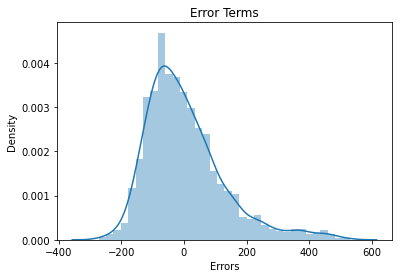

In [76]:
plot_res_dist(y_test, y_predicted)
r2_score(y_test,y_predicted)

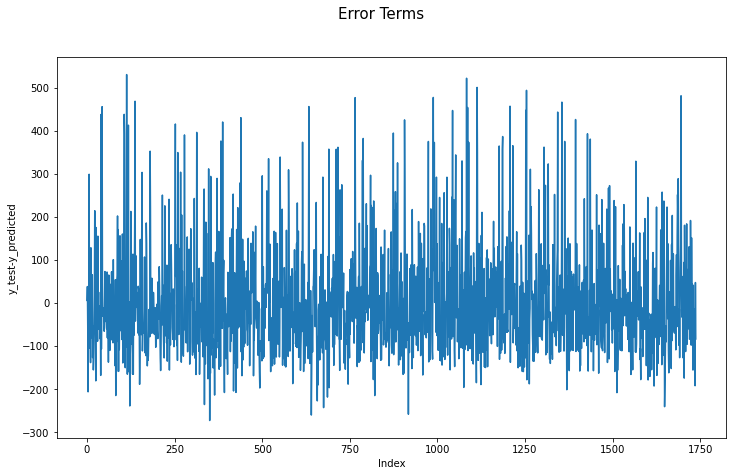

In [77]:
fig = plt.figure(figsize=(12,7))

c = [i for i in range(0,len(x_test_std),1)]
plt.plot(c,y_test-y_predicted)
plt.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('y_test-y_predicted')
plt.show()

Text(0, 0.5, 'y_test_pred')

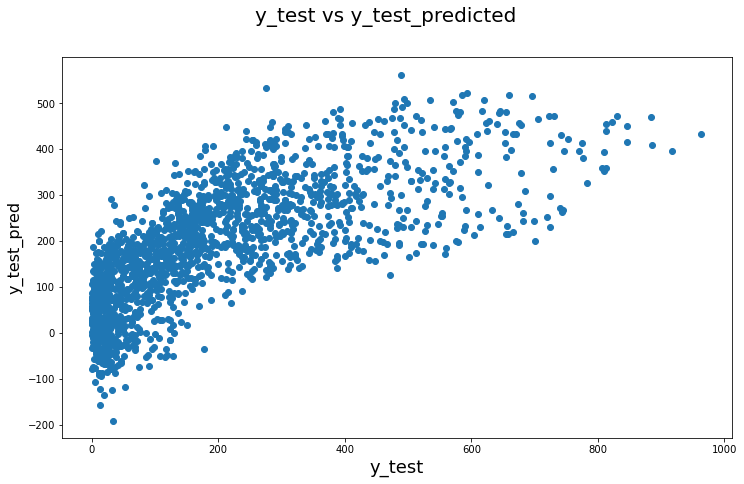

In [78]:
# vidimo da predictovane vrednosti dosta odstupaju od pravih, ne mogu se adekvatno aproksimirati pravom
fig = plt.figure(figsize=(12,7))
plt.scatter(y_test, y_predicted)
fig.suptitle('y_test vs y_test_predicted', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_test_pred', fontsize = 16)

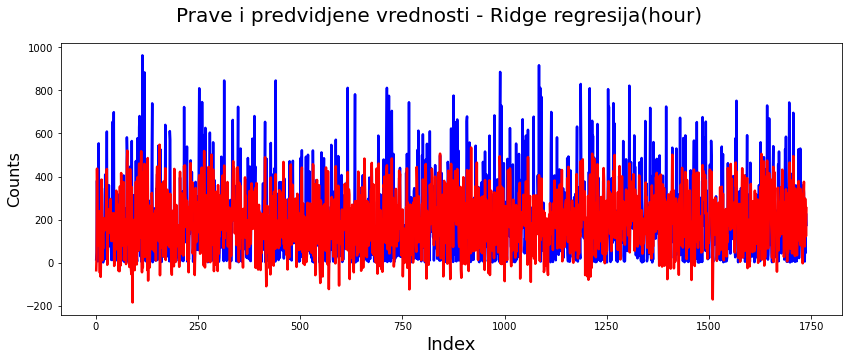

In [83]:

def plot_act_pred(act,pred,scale,dataname):
    c = [i for i in range(1,scale,1)]
    fig = plt.figure(figsize=(14,5))
    plt.plot(c,act, color="blue", linewidth=2.5, linestyle="-")
    plt.plot(c,pred, color="red",  linewidth=2.5, linestyle="-")
    fig.suptitle('Prave i predvidjene vrednosti - '+dataname, fontsize=20)               
    plt.xlabel('Index', fontsize=18)                              
    plt.ylabel('Counts', fontsize=16)                              
    
plot_act_pred(y_test,y_predicted,len(y_test)+1,'Ridge regresija(hour)')

Mean squared error:  16752.41224605844
Mean absolute error:  96.61067649499597
Root mean squared error:  129.43111003950494
R2 score:  0.5045550745622956
R2 adjusted score:  0.5028385324107727
      y      y_pred
0    16  -35.569911
1    40   30.655119
2    32  436.442031
3    13  236.548231
4     1  104.365021
5     1   78.186983
6     2  233.785800
7     3  239.283755
8     8   85.210596
9    14  -47.416131
10   36  164.726903
11   56  -66.174843
12   84   77.770365
13   94  385.784922
14  106  315.015722
15  110   11.308097
16   93  176.936283
17   67   65.128894
18   35  206.777173
19   37  146.272770


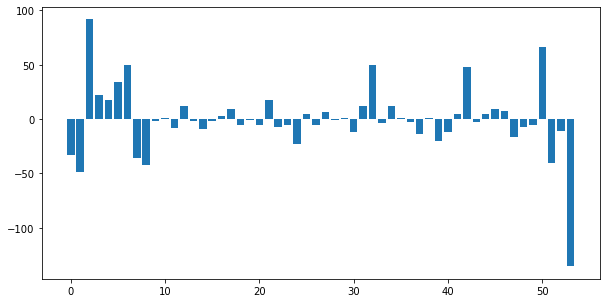

koeficijenti:  [ -33.59006516  -48.93757692   91.63325658   21.8396316    17.33730667
   33.58235224   50.04757388  -35.4868218   -41.98562482   -2.11185974
    1.06709876   -8.45031253   11.6227882    -2.00626554   -8.8872111
   -2.32810924    2.56960359    9.07932589   -5.26582803   -0.66992523
   -5.39015194   17.69692901   -7.25887615   -5.81705114  -22.819275
    4.26709375   -5.37265088    6.82516798   -0.6634023     0.66875359
  -11.91561788   11.63532888   49.91631323   -3.42301786   11.8284564
    0.58564699   -2.8281772   -13.91737139    0.45482342  -19.9848073
  -12.13669212    4.81738767   47.63185325   -3.12312185    4.83959745
    9.1400014     6.98148103  -16.25351691   -7.78993288   -5.52854626
   66.01605964  -40.20817766  -10.94052725 -135.71318093]


In [81]:
#Lasso regresija

# Model initialization
lasso_model = Lasso(alpha=0.01)

# Fit the data(train the model)
lasso_model.fit(x_inter_train, y_train)

# Predict
y_predicted = lasso_model.predict(x_inter_test)

# Evaluation
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


#ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
plt.show()
print("koeficijenti: ", lasso_model.coef_)

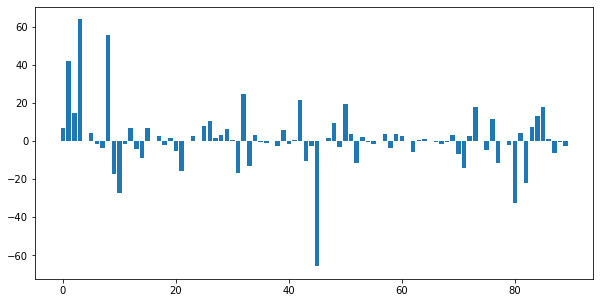

koeficijenti:  [ 6.70592107e+00  4.19203295e+01  1.49493116e+01  6.39770719e+01
 -0.00000000e+00  4.25308031e+00 -1.47078270e+00 -3.40584439e+00
  5.58240581e+01 -1.72934130e+01 -2.71357844e+01 -1.29898193e+00
  6.99156293e+00 -3.88976350e+00 -8.63514089e+00  6.97599641e+00
  2.24069970e-01  2.46852358e+00 -2.01409179e+00  1.45739028e+00
 -5.27242354e+00 -1.54455158e+01 -9.41538944e-02  2.49312816e+00
  0.00000000e+00  8.01680509e+00  1.03632921e+01  1.72743593e+00
  3.28839462e+00  6.39780475e+00  6.73918484e-01 -1.65489154e+01
  2.45023386e+01 -1.33116515e+01  3.42772813e+00 -4.73838288e-01
 -1.05198099e+00  3.00326307e-01 -2.30752858e+00  5.62137614e+00
 -1.56674020e+00  3.73815570e-01  2.16585832e+01 -1.04827364e+01
 -2.29684415e+00 -6.58228493e+01  0.00000000e+00  1.77104312e+00
  9.45992189e+00 -3.08992105e+00  1.97498076e+01  3.93023269e+00
 -1.14260469e+01  2.43884154e+00 -5.48369931e-01 -1.34019961e+00
  0.00000000e+00  3.68326313e+00 -3.72314982e+00  3.76115488e+00
  2.747477

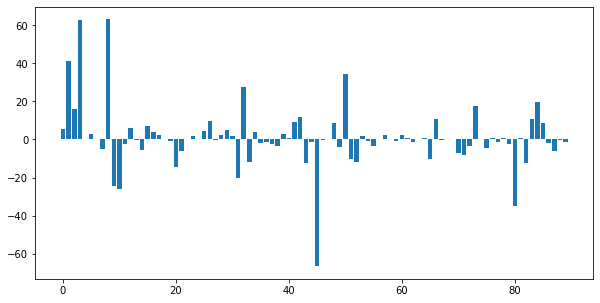

koeficijenti:  [ 5.67741522e+00  4.12555869e+01  1.60039158e+01  6.25767624e+01
 -0.00000000e+00  2.78773574e+00  1.35008669e-01 -4.78327153e+00
  6.31432495e+01 -2.43920719e+01 -2.62533144e+01 -2.35400872e+00
  5.81137851e+00 -3.81705585e-01 -5.47325131e+00  7.29399107e+00
  3.82354149e+00  2.20601062e+00  3.08926243e-01 -8.53317666e-01
 -1.44973923e+01 -5.99660665e+00  4.91442261e-01  1.65661285e+00
  0.00000000e+00  4.67652272e+00  9.65248212e+00 -3.09744208e-01
  2.26180834e+00  5.23918934e+00  1.64635361e+00 -2.02655254e+01
  2.77746361e+01 -1.20958093e+01  4.05468964e+00 -1.76700780e+00
 -1.31094975e+00 -2.30520533e+00 -3.46337856e+00  3.10136558e+00
  8.05879899e-01  9.09284207e+00  1.17399179e+01 -1.26058793e+01
 -1.47218705e+00 -6.67537482e+01 -1.56479905e-01  3.39886382e-01
  8.53659753e+00 -3.96285212e+00  3.44265905e+01 -1.02516329e+01
 -1.17835428e+01  1.57567524e+00 -6.95100152e-01 -3.58925718e+00
  0.00000000e+00  2.31742487e+00  0.00000000e+00 -7.72515737e-01
  2.591441

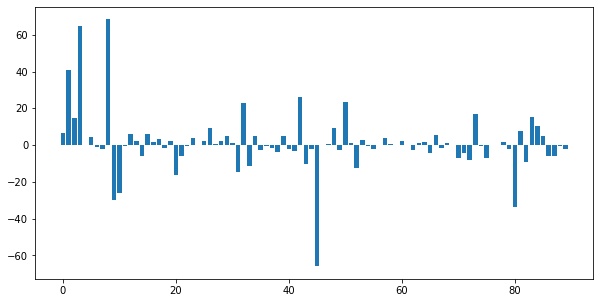

koeficijenti:  [ 6.46345249e+00  4.08762496e+01  1.45844716e+01  6.47927899e+01
 -0.00000000e+00  4.32217436e+00 -1.18672883e+00 -1.95174997e+00
  6.83550009e+01 -3.00295088e+01 -2.60750041e+01 -6.03655318e-01
  5.97448362e+00  2.25890197e+00 -5.90812049e+00  6.06464041e+00
  1.64109305e+00  3.14871267e+00 -1.54774690e+00  2.01544608e+00
 -1.62826841e+01 -6.03464463e+00 -5.39238900e-01  3.78503153e+00
  0.00000000e+00  1.99296024e+00  9.37928920e+00  4.69208355e-01
  1.98048397e+00  4.80206608e+00  1.25328447e+00 -1.47905850e+01
  2.26152710e+01 -1.14580112e+01  4.78108581e+00 -2.60730995e+00
 -5.42803986e-01 -1.48072238e+00 -3.77739446e+00  4.78424440e+00
 -2.20336624e+00 -3.30290469e+00  2.61977942e+01 -1.00847794e+01
 -2.00593513e+00 -6.59963403e+01  4.22336245e-02  3.61635995e-01
  9.28221833e+00 -2.85160068e+00  2.35967316e+01  1.04415800e+00
 -1.23495440e+01  2.56900712e+00 -4.86664787e-01 -1.96546833e+00
  0.00000000e+00  3.87978160e+00  5.48526082e-01  0.00000000e+00
  2.115096

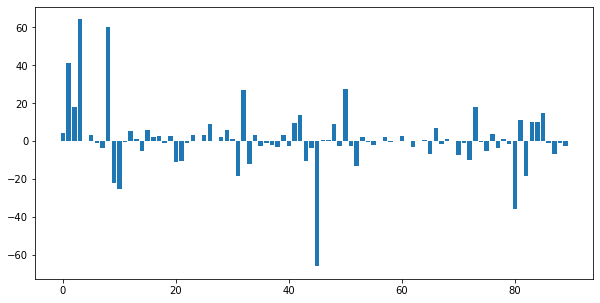

koeficijenti:  [  4.43110183  41.27642803  18.08158785  64.24807306  -0.
   3.25457396  -0.65039409  -3.66143971  60.2048321  -21.77356902
 -25.34155627  -0.48781971   5.65294308   0.96815148  -4.94130264
   5.78483964   2.03193428   2.77962188  -0.66656907   2.80059568
 -10.95879613 -10.12553819  -0.87800076   3.4716292    0.
   3.22753002   9.26805043   0.12355882   2.28883118   5.74918749
   1.26905545 -18.44962204  27.1300724  -12.08727493   3.48603932
  -2.55930472  -1.09346794  -1.92535655  -3.26317753   3.21246548
  -2.46077715   9.7690462   13.75124845 -10.31277791  -3.51440033
 -65.93666368   0.66595371   0.60090048   9.22575343  -2.64876581
  27.75708795  -2.54722972 -13.15158875   2.23874986  -0.46870915
  -2.14376354   0.           2.52281986  -0.10863426   0.
   2.53849442   0.          -3.23168716   0.38311316   0.82340111
  -6.58407009   7.11785609  -1.4807503    1.01195649   0.
  -6.97072941  -1.12579903  -9.95140298  17.88903168  -0.33214107
  -5.06545817   3.76573748 

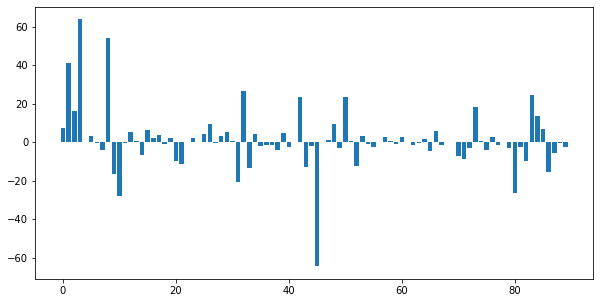

koeficijenti:  [ 7.30802864e+00  4.09621057e+01  1.62863818e+01  6.38203492e+01
 -0.00000000e+00  3.37483034e+00 -4.30148858e-01 -4.00696844e+00
  5.41060844e+01 -1.67117439e+01 -2.80528098e+01 -3.33236675e-01
  5.34105071e+00  4.87384820e-01 -6.72687178e+00  6.33968054e+00
  2.00849442e+00  3.50168952e+00 -1.08224855e+00  2.08584725e+00
 -9.77231139e+00 -1.12808525e+01  3.48168332e-02  2.19696451e+00
  0.00000000e+00  4.30172473e+00  9.55539173e+00 -2.26031213e-01
  3.45827486e+00  5.14289896e+00  8.37332825e-01 -2.06638800e+01
  2.67061012e+01 -1.33095211e+01  4.51471673e+00 -2.18849526e+00
 -1.49594395e+00 -1.57442393e+00 -3.89359211e+00  4.83734687e+00
 -2.49787490e+00 -4.80445918e-03  2.34790627e+01 -1.27960541e+01
 -1.76060399e+00 -6.45494616e+01 -1.36825097e-01  1.27851300e+00
  9.43033289e+00 -2.78242160e+00  2.37391784e+01  4.74541185e-01
 -1.25101791e+01  3.20615984e+00 -7.42129833e-01 -2.25391340e+00
  0.00000000e+00  2.74559651e+00  7.97365272e-01 -9.06448905e-01
  2.848990

In [82]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(x_train, y_train)

for train_index, test_index in indexes:

    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    x_inter_train = poly.fit_transform(X_train)
    x_inter_test = poly.transform(X_test)
    
    
    # Model initialization
    lasso_model = Lasso(alpha=0.01)

    # Fit the data(train the model)
    lasso_model.fit(x_inter_train, Y_train)

    # Predict
    Y_pred = lasso_model.predict(x_inter_test)

    #ilustracija koeficijenata
    plt.figure(figsize=(10,5))
    plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
    plt.show()
    print("koeficijenti: ", lasso_model.coef_)

    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("\n\n")

# Stabla odluke na hour datasetu

In [110]:
hour = pd.read_csv('hour.csv')

hour.drop("instant", axis=1, inplace=True)

hour.drop("dteday", axis=1, inplace=True)
hour.drop("casual", axis=1, inplace=True)
hour.drop("registered", axis=1, inplace=True)
hour

season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0           1   0     1   0        0        6           0           1  0.24   
1           1   0     1   1        0        6           0           1  0.22   
2           1   0     1   2        0        6           0           1  0.22   
3           1   0     1   3        0        6           0           1  0.24   
4           1   0     1   4        0        6           0           1  0.24   
...       ...  ..   ...  ..      ...      ...         ...         ...   ...   
17374       1   1    12  19        0        1           1           2  0.26   
17375       1   1    12  20        0        1           1           2  0.26   
17376       1   1    12  21        0        1           1           1  0.26   
17377       1   1    12  22        0        1           1           1  0.26   
17378       1   1    12  23        0        1           1           1  0.26   

        atemp   hum  windspeed  cnt  
0      0.2879  0.81     0.0000   16  
1      0.2727  0.80     0.0000   40  
2      0.2727  0.80     0.0000   32  
3      0.2879  0.75     0.0000   13  
4      0.2879  0.75     0.0000    1  
...       ...   ...        ...  ...  
17374  0.2576  0.60     0.1642  119  
17375  0.2576  0.60     0.1642   89  
17376  0.2576  0.60     0.1642   90  
17377  0.2727  0.56     0.1343   61  
17378  0.2727  0.65     0.1343   49  

[17379 rows x 13 columns]

In [111]:
#kreiranje dummy varijabli
hour = pd.get_dummies(data=hour,columns=["season","mnth","weekday"],drop_first=True)
hour = pd.get_dummies(data=hour,columns=["weathersit"])

In [119]:
hour

yr  hr  holiday  workingday  temp   atemp   hum  windspeed  cnt  \
0       0   0        0           0  0.24  0.2879  0.81     0.0000   16   
1       0   1        0           0  0.22  0.2727  0.80     0.0000   40   
2       0   2        0           0  0.22  0.2727  0.80     0.0000   32   
3       0   3        0           0  0.24  0.2879  0.75     0.0000   13   
4       0   4        0           0  0.24  0.2879  0.75     0.0000    1   
...    ..  ..      ...         ...   ...     ...   ...        ...  ...   
17374   1  19        0           1  0.26  0.2576  0.60     0.1642  119   
17375   1  20        0           1  0.26  0.2576  0.60     0.1642   89   
17376   1  21        0           1  0.26  0.2576  0.60     0.1642   90   
17377   1  22        0           1  0.26  0.2727  0.56     0.1343   61   
17378   1  23        0           1  0.26  0.2727  0.65     0.1343   49   

       season_2  ...  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
0             0  ...          0          0          0          0          0   
1             0  ...          0          0          0          0          0   
2             0  ...          0          0          0          0          0   
3             0  ...          0          0          0          0          0   
4             0  ...          0          0          0          0          0   
...         ...  ...        ...        ...        ...        ...        ...   
17374         0  ...          1          0          0          0          0   
17375         0  ...          1          0          0          0          0   
17376         0  ...          1          0          0          0          0   
17377         0  ...          1          0          0          0          0   
17378         0  ...          1          0          0          0          0   

       weekday_6  weathersit_1  weathersit_2  weathersit_3  weathersit_4  
0              1             1             0             0             0  
1              1             1             0             0             0  
2              1             1             0             0             0  
3              1             1             0             0             0  
4              1             1             0             0             0  
...          ...           ...           ...           ...           ...  
17374          0             0             1             0             0  
17375          0             0             1             0             0  
17376          0             1             0             0             0  
17377          0             1             0             0             0  
17378          0             1             0             0             0  

[17379 rows x 33 columns]

In [112]:
Y=hour.pop('cnt')

X=hour

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.1, random_state=46)



In [180]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree

mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0

kf = KFold(n_splits=3, shuffle=True, random_state=42)
indexes = kf.split(X1_train, Y1_train)

for train_index, test_index in indexes:

    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    
    
#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     x_inter_train = poly.fit_transform(X_train)
#     x_inter_test = poly.transform(X_test)
    
    

    regressor = DecisionTreeRegressor(max_depth=12,max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,splitter='best',criterion='friedman_mse')
    regressor.fit(X_train, Y_train)
    
#     plt.figure(figsize=(16,9), dpi=300)
#     tree.plot_tree(regressor)
#     plt.show()

    Y_pred = regressor.predict(X_test)


    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))
    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj

print("prosek mse =",mse_acc/3)
print("prosek mae =",mae_acc/3)
print("prosek rmse =",rmse_acc/3)
print("prosek r2 =",r2_acc/3)
print("prosek r2 adjusted =",r2_adj_acc/3)

mse = 3141.5266965817254
mae = 33.679358199119484
rmse = 56.04932378344743
r2 score = 0.9008959859522736
r2 adjusted = 0.9005908744985958



mse = 3162.94422487483
mae = 34.23259762119444
rmse = 56.240058898216226
r2 score = 0.9024772632423307
r2 adjusted = 0.9021770200658591



mse = 3330.681233676801
mae = 33.94160015750428
rmse = 57.71205449190664
r2 score = 0.9010707890712659
r2 adjusted = 0.9007662450837989



prosek mse = 3211.7173850444524
prosek mae = 33.9511853259394
prosek rmse = 56.66714572452344
prosek r2 = 0.9014813460886234
prosek r2 adjusted = 0.9011780465494179


In [156]:
regressor_dt = DecisionTreeRegressor(max_depth=12,max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,splitter='best',criterion='friedman_mse')
regressor_dt.fit(X1_train,Y1_train)

y_predicted = regressor_dt.predict(X1_test)

model_evaluation(Y1_test, y_predicted, X1_train.shape[0], X1_train.shape[1])

Mean squared error:  3447.3221715206355
Mean absolute error:  33.87221044955214
Root mean squared error:  58.7139010075181
R2 score:  0.8946714344941559
R2 adjusted score:  0.8944427545229103
      y      y_pred
0    16   18.200000
1    40   53.750000
2    32  382.210526
3    13   12.500000
4     1    5.142857
5     1   10.228070
6     2  511.816425
7     3  189.925373
8     8   25.000000
9    14    4.324324
10   36   50.680000
11   56   80.500000
12   84    2.558824
13   94  304.500000
14  106  376.088889
15  110   41.000000
16   93   38.333333
17   67    2.833333
18   35   33.333333
19   37   15.000000


In [ ]:
#procenjujemo najbolje parametre za decision tree
# from sklearn.model_selection import GridSearchCV

# parameters = {'criterion':('squared_error', 'friedman_mse','absolute_error','poisson'),
#               'splitter':('best', 'random'),
#                "max_depth" : [3,5,10,None],
#            "min_samples_leaf":[1,3,5],
#            "min_weight_fraction_leaf":[0.1,0.3,0.5],
#            "max_features":["auto","log2","sqrt",None],
#            "max_leaf_nodes":[None,10,30,50]}

# dt = DecisionTreeRegressor()
# clf=GridSearchCV(dt, parameters)
# clf.fit(X1_train.values, Y1_train)

# print(clf.best_score_)
# print(clf.best_params_)

# Random forest

In [107]:
import time
start = time.time()

regressor_rf = RandomForestRegressor(n_estimators=350, max_depth=None,criterion='friedman_mse',max_features='auto',max_leaf_nodes=None,min_samples_leaf=1)
regressor_rf.fit(X1_train,Y1_train)

y_predicted = regressor_rf.predict(X1_test)

model_evaluation(Y1_test, y_predicted, X1_train.shape[0], X1_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

Mean squared error:  1900.4639270431828
Mean absolute error:  26.256466765302207
Root mean squared error:  43.594310718753
R2 score:  0.9437946491047883
R2 adjusted score:  0.9436794151716356
      y      y_pred
0    16   14.302857
1    40   70.914286
2    32  371.488571
3    13   11.120000
4     1    5.165714
5     1    9.862857
6     2  501.757143
7     3  191.217143
8     8   24.517143
9    14    5.205714
10   36   74.805714
11   56   70.105714
12   84    2.731429
13   94  358.957143
14  106  383.755238
15  110   74.802857
16   93   34.394286
17   67    1.905714
18   35   34.617143
19   37   14.197143
vreme trajanja je:  36.470022678375244  sekundi.


In [222]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
indexes = kf.split(X1_train, Y1_train)
mse_acc=0
mae_acc=0
rmse_acc=0
r2_acc=0
r2_adj_acc=0


for train_index, test_index in indexes:

    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    
    
#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     x_inter_train = poly.fit_transform(X_train)
#     x_inter_test = poly.transform(X_test)
    
    
# {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 100}
    regressor = RandomForestRegressor(n_estimators=350, max_depth=None,criterion='friedman_mse',max_features='auto',max_leaf_nodes=None,min_samples_leaf=1)
    regressor.fit(X_train, Y_train)
    

    Y_pred = regressor.predict(X_test)


    mse = mean_squared_error(Y_test, Y_pred) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(Y_test, Y_pred) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    r2_adj = 1-(1-r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    print("mse = {}".format(mse))
    print("mae = {}".format(mae))
    print("rmse = {}".format(rmse))
    print("r2 score = {}".format(r2))
    print("r2 adjusted = {}".format(r2_adj))

    print("\n\n")
    
    mse_acc+=mse
    mae_acc+=mae
    rmse_acc+=rmse
    r2_acc+=r2
    r2_adj_acc+=r2_adj
    
print("prosek mse =",mse_acc/3)
print("prosek mae =",mae_acc/3)
print("prosek rmse =",rmse_acc/3)
print("prosek r2 =",r2_acc/3)
print("prosek r2 adjusted =",r2_adj_acc/3)

mse = 1745.9137779965745
mae = 25.705780663780665
rmse = 41.784133088967806
r2 score = 0.9449226187480879
r2 adjusted = 0.9447530520557595



mse = 1872.9628428517842
mae = 26.44426187997255
rmse = 43.27774073183331
r2 score = 0.9422511276538369
r2 adjusted = 0.9420733362438815



mse = 2032.7138167976113
mae = 27.191083892832022
rmse = 45.08562760789309
r2 score = 0.9396235304938712
r2 adjusted = 0.9394376673842804



prosek mse = 1883.8634792153232
prosek mae = 26.447042145528414
prosek rmse = 43.3825004762314
prosek r2 = 0.9422657589652653
prosek r2 adjusted = 0.9420880185613072


In [199]:
from sklearn.model_selection import GridSearchCV



parameters = {'criterion':('friedman_mse','squared_error'),
           "max_depth" : [10,12,15,None],
           "min_samples_leaf":[1,3,5],
           "max_features":["auto",None],
           "n_estimators":[50,100,200,300]
           }

dt = RandomForestRegressor()
clf=GridSearchCV(dt, parameters)
clf.fit(X1_train.values, Y1_train)

print(clf.best_score_)
print(clf.best_params_)

0.9439904570763641
{'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}


350


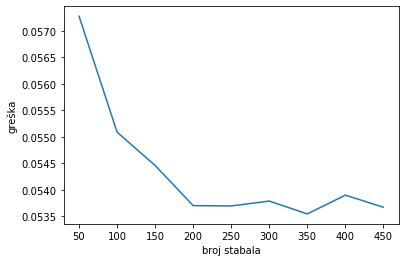

In [206]:
error_rate=[]
num_estimators = np.arange(50, 500, 50)
for i in num_estimators:
    regressor = RandomForestRegressor(n_estimators=i,  max_depth=None,criterion='friedman_mse',max_features='auto',max_leaf_nodes=None,min_samples_leaf=1, oob_score=True)
    regressor.fit(X1_train.values, Y1_train)
    oob_error = 1 - regressor.oob_score_
    error_rate.append(oob_error)

tmp = error_rate.index(min(error_rate))
print(num_estimators[tmp])
plt.plot(np.arange(50,500,50), error_rate)
plt.xlabel('broj stabala')
plt.ylabel('greška')
plt.show()

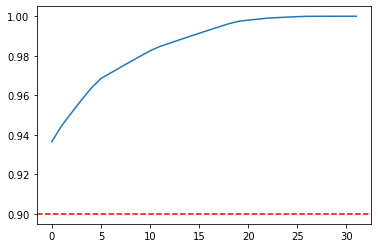

In [182]:
#obucavanje random forest s redukcijom dimenzionalnosti
from sklearn.decomposition import PCA



scaler = StandardScaler(with_std=False)
scaler.fit(X1_train)
X1_train_std = scaler.transform(X1_train)
X1_test_std = scaler.transform(X1_test)

pca = PCA(n_components=None)
pca.fit(X1_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.show()

In [231]:
X1_train_std.shape

(14772, 32)

In [183]:
pca = PCA(n_components=0.9)
pca.fit(X1_train)
X_train_r = pca.transform(X1_train)
X_test_r = pca.transform(X1_test)
print('Redukovani prostor ima dimenziju: ', pca.n_components_)

Redukovani prostor ima dimenziju:  1


In [184]:
import time
start = time.time()



# y_predicted = regressor_rf.predict(X1_test)

# model_evaluation(Y1_test, y_predicted, X1_train.shape[0], X1_train.shape[1])

# print('vreme trajanja je: ', time.time() - start, ' sekundi.')

regressor_rf_pca = RandomForestRegressor(n_estimators=350, max_depth=None,criterion='friedman_mse',max_features='auto',max_leaf_nodes=None,min_samples_leaf=1)
regressor_rf_pca.fit(X_train_r,Y1_train)
y_predicted_pca = regressor_rf_pca.predict(X_test_r)
model_evaluation(Y1_test, y_predicted_pca, X1_train.shape[0], X1_train.shape[1])

print('vreme trajanja je: ', time.time() - start, ' sekundi.')

Mean squared error:  20950.575658505968
Mean absolute error:  97.20676524545377
Root mean squared error:  144.74313682695276
R2 score:  0.3803963129281469
R2 adjusted score:  0.37912598245747164
      y      y_pred
0    16   15.194286
1    40  242.582857
2    32  323.222857
3    13   27.662857
4     1    5.462857
5     1   13.314286
6     2  590.191429
7     3  265.345714
8     8   14.497143
9    14   17.937143
10   36  225.122857
11   56   16.414286
12   84    4.991429
13   94  388.145714
14  106  344.508571
15  110  284.266755
16   93   41.862857
17   67    6.045714
18   35   15.582857
19   37   13.337143
vreme trajanja je:  10.698456525802612  sekundi.


0.9437946491047883

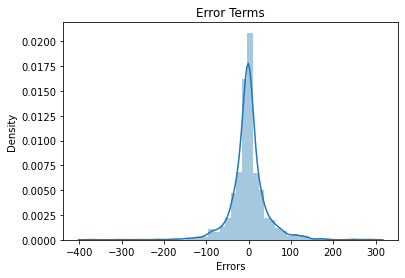

In [114]:
y_predicted_rf = regressor_rf.predict(X1_test)
plot_res_dist(Y1_test, y_predicted)
r2_score(Y1_test,y_predicted)

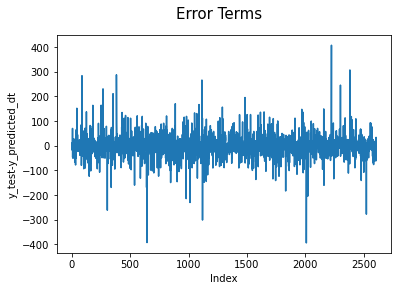

In [244]:
c = [i for i in range(0,len(X1_test),1)]
plt.plot(c,Y1_test-y_predicted_rf)
plt.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('y_test-y_predicted_rf')
plt.show()

Text(0, 0.5, 'predvidjene vrednosti')

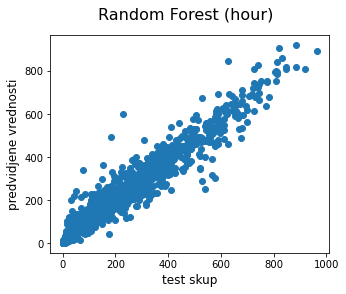

In [115]:
#nema puno odstupanja pravih od predvidjenih vrednosti
fig = plt.figure(figsize=(5,4))
plt.scatter(Y1_test, y_predicted)
fig.suptitle('Random Forest (hour)', fontsize = 16)              
plt.xlabel('test skup', fontsize = 12)                          
plt.ylabel('predvidjene vrednosti', fontsize = 12)

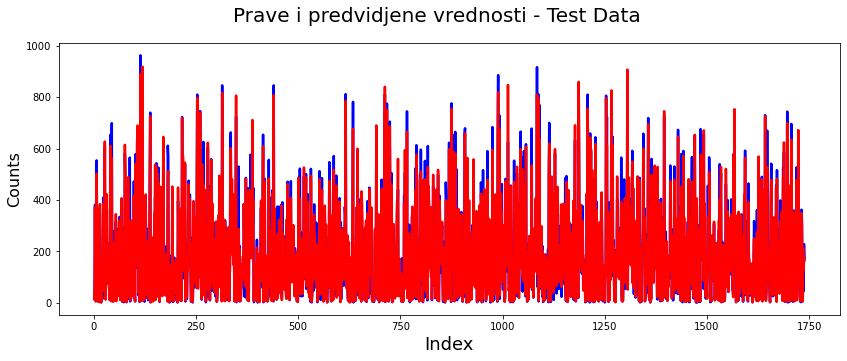

In [116]:
#veliki procenat poklapanja pravih i predvidjenih vrednosti
plot_act_pred(Y1_test,y_predicted,len(Y1_test)+1,'Test Data')